# State Punishment Analysis Notebook
# ===================================

This notebook provides tools for analyzing TensorBoard results from state punishment experiments.
It includes data processing, visualization, and statistical analysis functions.

## Table of Contents
1. [Imports and Dependencies](#1-imports-and-dependencies)
2. [TensorBoard Data Processing](#2-tensorboard-data-processing)
3. [Data Analysis Utilities](#3-data-analysis-utilities)
4. [Visualization Functions](#4-visualization-functions)
5. [Statistical Analysis](#5-statistical-analysis)
6. [Data Processing Pipeline](#6-data-processing-pipeline)
7. [Example Analysis](#7-example-analysis)


## 1. Imports and Dependencies


In [1]:
# Core data processing and visualization
from scipy.stats import zscore

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import time
from collections import defaultdict

# TensorFlow for TensorBoard processing
import tensorflow as tf
from tensorflow.python.framework.errors_impl import DataLossError

# Statistical analysis
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import pingouin as pg

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("All imports successful!")


/Users/socialai/miniconda3/envs/sorrel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/socialai/miniconda3/envs/sorrel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/socialai/miniconda3/envs/sorrel/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/resource_han

All imports successful!


## 2. TensorBoard Data Processing


In [2]:
def tensorboard_to_csv(event_file, csv_file):
    """
    Convert TensorBoard event file data to a CSV format.

    Args:
        event_file (str): Path to the TensorBoard event file (e.g., events.out.tfevents.xxx).
        csv_file (str): Path where the output CSV file should be saved.
    """
    data_rows = []
    
    # Use tf.compat.v1 to access the summary_iterator in TensorFlow 2.x
    for e in tf.compat.v1.train.summary_iterator(event_file):
        for v in e.summary.value:
            # Only consider scalar summaries
            if v.HasField('simple_value'):
                tag = v.tag
                value = v.simple_value
                step = e.step
                data_rows.append([step, tag, value])
    
    # Write the extracted data into a CSV file
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Step', 'Tag', 'Value'])
        writer.writerows(data_rows)
    
    print(f"Data from {event_file} has been written to {csv_file}")


In [3]:
def tensorboard_to_separate_csv(event_file, output_dir):
    """
    Convert TensorBoard event file to separate CSV files for each metric.
    
    Args:
        event_file (str): Path to the TensorBoard event file
        output_dir (str): Directory where CSV files should be saved
    """
    tag_data = defaultdict(list)

    try:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            try:
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        tag = v.tag
                        value = v.simple_value
                        step = e.step
                        tag_data[tag].append([step, value])
            except Exception as record_error:
                print(f"Skipped a corrupt record in file: {event_file}")
    except DataLossError:
        print(f"Encountered DataLossError. Possibly due to incomplete writes in file: {event_file}")

    # Save tag data to CSV files
    for tag, data_rows in tag_data.items():
        filename = f"{output_dir}/{tag.replace('/', '_')}_data.csv"
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Step', 'Value'])
            writer.writerows(data_rows)
        print(f"Data for tag '{tag}' has been written to {filename}")


In [4]:
def is_file_stable(file_path, wait_time=1.0):
    """Check if a file is stable (not being written to)."""
    initial_size = os.path.getsize(file_path)
    time.sleep(wait_time)
    final_size = os.path.getsize(file_path)
    return initial_size == final_size

def process_tensorboard_results(parent_dir, output_parent_dir):
    """
    Process all TensorBoard files in a directory structure.
    
    Args:
        parent_dir (str): Parent directory containing TensorBoard event files
        output_parent_dir (str): Parent directory where CSV files should be saved
    """
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "tfevents" in file:
                event_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, parent_dir)
                output_dir = os.path.join(output_parent_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                try:
                    tensorboard_to_separate_csv(event_file, output_dir)
                    print(f"Processed {event_file} -> {output_dir}")
                except Exception as e:
                    print(f"Failed to process {event_file}: {e}")


## 3. Data Analysis Utilities


In [5]:
# define a rolling window correlation function
from scipy.stats import pearsonr

def moving_avg(x, k):
    if k <= 1:
        return x.copy()
    return np.convolve(x, np.ones(k) / k, mode="same")

def check_percentage_of_above_threshold(array, threshold, prop):
    proportion = np.mean(array > threshold)
    if proportion >= prop:
        return 1
    elif np.mean(array < threshold) >= prop:
        return -1
    else:
        return 0

def rolling_window_correlation(x, y, window):
    """
    Calculate the rolling window correlation and p-value between two 1D arrays.

    Args:
        x (array-like): First time series.
        y (array-like): Second time series.
        window (int): Window size for rolling correlation.

    Returns:
        tuple: (corrs, pvals)
            corrs: np.ndarray of correlation coefficients, length = len(x) - window + 1
            pvals: np.ndarray of p-values, same length
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    if window < 1 or window > len(x):
        raise ValueError("Window size must be between 1 and the length of the input arrays.")

    corrs = []
    pvals = []
    prop =[]
    for i in range(len(x) - window + 1):
        x_win = x[i:i+window]
        y_win = y[i:i+window]
        # Remove nan pairs
        mask = ~np.isnan(x_win) & ~np.isnan(y_win)
        if np.sum(mask) < 2:
            corrs.append(np.nan)
            pvals.append(np.nan)
            prop.append(np.nan)
        else:
            r, p = pearsonr(x_win[mask], y_win[mask])
            corrs.append(r)
            pvals.append(p)
            prop.append(check_percentage_of_above_threshold(x_win[mask], 0.3, 0.6))
    return np.array(corrs), np.array(pvals), np.array(prop)



In [6]:
def trim_and_calculate_mean(array_list):
    """
    Trim arrays to the same length and calculate mean.
    
    Args:
        array_list: List of arrays to process
        
    Returns:
        numpy.ndarray: Array of trimmed arrays
    """
    min_length = min(len(arr) for arr in array_list)
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    return np.array(trimmed_arrays)

def exponential_moving_average(data, alpha):
    """
    Calculate the exponential moving average (EMA) of a 1D array.

    Args:
        data (array-like): The input data
        alpha (float): The smoothing factor (0 < alpha <= 1)

    Returns:
        numpy.ndarray: The EMA values
    """
    if not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
    return np.array(ema)

def rolling_average(data, window_size):
    """
    Calculate the rolling average of a 1D array.

    Args:
        data (array-like): The input data
        window_size (int): The size of the rolling window

    Returns:
        numpy.ndarray: The rolling average values
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Data length must be at least equal to the window size.")
    
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')


## 4. Visualization Functions


In [7]:
def plot_average_trajectory(time_series, error_type='std', time_points=None, 
                           xlabel='Time', ylabel='Value', title='Average Trajectory'):
    """
    Plot the average trajectory of a set of time series with error bars.

    Parameters:
    - time_series (2D array-like): A set of time series, shape (n_series, n_time_points)
    - error_type (str): Either 'std' for standard deviation or 'sem' for standard error
    - time_points (1D array-like, optional): Time points corresponding to the time series
    - xlabel (str): Label for the x-axis
    - ylabel (str): Label for the y-axis
    - title (str): Title of the plot
    """
    time_series = np.array(time_series)
    if time_points is None:
        time_points = np.arange(time_series.shape[1])
    else:
        time_points = np.array(time_points)
    
    if time_series.shape[1] != len(time_points):
        raise ValueError("Length of time_points must match the number of columns in time_series.")
    
    # Compute average and error
    mean_trajectory = np.mean(time_series, axis=0)
    if error_type == 'std':
        error = np.std(time_series, axis=0)
    elif error_type == 'sem':
        error = np.std(time_series, axis=0) / np.sqrt(time_series.shape[0])
    else:
        raise ValueError("error_type must be 'std' or 'sem'.")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory', color='blue')
    plt.fill_between(time_points, mean_trajectory - error, mean_trajectory + error, 
                     alpha=0.3, color='blue', label='Error')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_multiple_conditions(data_list, labels, window_size=200, title="Comparison"):
    """
    Plot multiple conditions with rolling average smoothing.
    
    Args:
        data_list: List of data arrays for each condition
        labels: List of labels for each condition
        window_size: Window size for rolling average
        title: Plot title
    """
    plt.figure(figsize=(12, 6))
    
    for i, (data, label) in enumerate(zip(data_list, labels)):
        if len(data) > window_size:
            smoothed = rolling_average(data, window_size)
            plt.plot(smoothed, label=label, alpha=0.8)
        else:
            plt.plot(data, label=label, alpha=0.8)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## 5. Statistical Analysis


In [8]:
def coefficient_of_variation(timestamps):
    """
    Calculate the coefficient of variation (CV) of inter-visit intervals.
    
    Parameters:
    - timestamps: A list or array of timestamps representing the times of visits or events
    
    Returns:
    - CV: The coefficient of variation (standard deviation / mean) of inter-visit intervals
    """
    inter_visit_intervals = np.diff(timestamps)
    mean_interval = np.mean(inter_visit_intervals)
    std_dev_interval = np.std(inter_visit_intervals)
    cv = std_dev_interval / mean_interval
    return cv

def fourier_transform_periodicity(data):
    """
    Perform a Fourier Transform to find the dominant frequency and quantify periodicity.
    
    Parameters:
    - data: A list or array representing the time series data
    
    Returns:
    - dominant_period: The period corresponding to the dominant frequency
    - power_at_dominant_frequency: The strength of the dominant frequency
    """
    fft_result = np.fft.fft(data)
    frequencies = np.fft.fftfreq(len(data))
    power = np.abs(fft_result)
    
    dominant_frequency = frequencies[np.argmax(power)]
    dominant_period = 1 / dominant_frequency
    
    return dominant_period, power[np.argmax(power)]

def correlation_analysis(x, y, method='spearman'):
    """
    Perform correlation analysis between two variables.
    
    Args:
        x, y: Arrays to correlate
        method: 'pearson' or 'spearman'
        
    Returns:
        correlation coefficient and p-value
    """
    if method == 'pearson':
        return pearsonr(x, y)
    elif method == 'spearman':
        return spearmanr(x, y)
    else:
        raise ValueError("Method must be 'pearson' or 'spearman'")

def multiple_regression_analysis(data_dict, target_var):
    """
    Perform multiple regression analysis.
    
    Args:
        data_dict: Dictionary with variable names as keys and arrays as values
        target_var: Name of the target variable
        
    Returns:
        Dictionary with regression results
    """
    df = pd.DataFrame(data_dict)
    
    # Separate features and target
    feature_vars = [col for col in df.columns if col != target_var]
    X = df[feature_vars]
    y = df[target_var]
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {
        'intercept': model.intercept_,
        'coefficients': dict(zip(feature_vars, model.coef_)),
        'mse': mse,
        'r2': r2
    }


## 6. Data Processing Pipeline


In [9]:
def load_experiment_data(folders, entity_names, agent_filter=None):
    """
    Load and process data from multiple experiment folders.
    
    Args:
        folders: List of experiment folder names
        entity_names: List of entity/metric names to load
        agent_filter: Optional filter for specific agents (e.g., 'Agent_0')
        
    Returns:
        Dictionary with processed data for each folder and entity
    """
    results = {}
    
    for folder in folders:
        results[folder] = {}
        parent_dir = os.path.join('res', folder)
        
        if not os.path.exists(parent_dir):
            print(f"Warning: Directory {parent_dir} does not exist")
            continue
            
        files = os.listdir(parent_dir)
        
        for entity_name in entity_names:
            entity_data = []
            
            for f in files:
                if entity_name in f:
                    if agent_filter is None or agent_filter in f:
                        file_path = os.path.join(parent_dir, f)
                        try:
                            data = pd.read_csv(file_path)
                            entity_data.append(data['Value'].to_numpy())
                        except Exception as e:
                            print(f"Error reading {file_path}: {e}")
            
            if entity_data:
                # Calculate mean across runs
                processed_data = np.mean(trim_and_calculate_mean(entity_data), axis=0)
                results[folder][entity_name] = processed_data
            else:
                print(f"No data found for {entity_name} in {folder}")
    
    return results

def compare_conditions(data_dict, metric_name, labels=None, window_size=200):
    """
    Compare a specific metric across different conditions.
    
    Args:
        data_dict: Dictionary with experiment data
        metric_name: Name of the metric to compare
        labels: Optional labels for conditions
        window_size: Window size for smoothing
    """
    data_list = []
    condition_labels = []
    
    for folder, metrics in data_dict.items():
        if metric_name in metrics:
            data_list.append(metrics[metric_name])
            condition_labels.append(folder if labels is None else labels[len(data_list)-1])
    
    if data_list:
        plot_multiple_conditions(data_list, condition_labels, window_size, f"{metric_name} Comparison")
    else:
        print(f"No data found for metric: {metric_name}")


### 6.5 system_analysis plots

In [10]:
def system_analysis(f, include_controls,smooth_social_harm_window, smooth_punishment_window, window_size, step_size, lag, start_timepoint, xlim=None):
    # load the data
    social_harm = pd.read_csv(f'{f}/Mean_mean_social_harm_received_data.csv')[:xlim]
    punishment_levels = pd.read_csv(f'{f}/Global_average_punishment_level_data.csv')[:xlim]
    vote_increase_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_increase_data.csv')[:xlim]
    vote_decrease_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')[:xlim]


    # remove missing values
    social_harm = social_harm.rename(columns={'Value': 'social_harm'})
    punishment_levels = punishment_levels.rename(columns={'Value': 'punishment_levels'})
    vote_increase_freq = vote_increase_freq.rename(columns={'Value': 'vote_increase_freq'})
    vote_decrease_freq = vote_decrease_freq.rename(columns={'Value': 'vote_decrease_freq'})
    df_harm_and_punishment = pd.concat([social_harm, punishment_levels], axis=1)
    df_harm_and_punishment = df_harm_and_punishment.dropna()
    social_harm = df_harm_and_punishment['social_harm']
    punishment_levels = df_harm_and_punishment['punishment_levels']

    # collective harm at time t ~ punishment at time t
    correlations = []
    p_values = []
    window_centers = []

    sh_win = social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean()
    p_win = punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean()

    for start in range(0, len(sh_win) - window_size + 1, step_size):
        end = start + window_size
        x_win = p_win[start:end]
        y_win = sh_win[start:end]
        # Only compute correlation if window has varied data
        if np.std(x_win) > 0 and np.std(y_win) > 0:
            corr, pval = pearsonr(x_win, y_win)
        else:
            corr, pval = np.nan, np.nan
        correlations.append(corr)
        p_values.append(pval)
        window_centers.append(start + window_size // 2)

    correlations = np.array(correlations)
    p_values = np.array(p_values)
    window_centers = np.array(window_centers)

    # Create a single figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Rolling window correlation: Social harm vs. punishment (no lag)
    mask_sig = p_values < 0.05
    mask_nonsig = ~mask_sig

    ax1.plot(window_centers[mask_nonsig], correlations[mask_nonsig], 'o', color='blue', label='Nonsignificant (p >= 0.05)', markersize=3)
    ax1.plot(window_centers[mask_sig], correlations[mask_sig], 'o', color='red', label='Significant (p < 0.05)', markersize=3)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Correlation coefficient")
    ax1.set_title("Rolling window correlation: Social harm vs. punishment (no lag)")
    ax1.legend()
    ax1.axhline(0, color='black', linewidth=1)
    ax1.set_ylim(-1, 1)
    if xlim is not None:
        ax1.set_xlim((None, xlim))
    ax1.grid(alpha=0.3)
    
    # punishment at time t ~ delta collective harm at time t 
    mode = 'regression'
    correlations = []
    p_values = []
    window_centers = []

    social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean())
    punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean())

    # social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
    social_harm_diff = social_harm_arr[start_timepoint+lag:] - social_harm_arr[start_timepoint:-lag]
    punishment_for_corr = punishment_arr[start_timepoint:][:-lag]
    social_harm_for_corr = social_harm_arr[start_timepoint:][:-lag]

    s_coefs = []
    s_pvalues = []
    window_centers = []

    for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
        end = start + window_size
        x_win = social_harm_for_corr[start:end]
        s_win = punishment_for_corr[start:end]
        y_win = social_harm_diff[start:end]

        # z-score all variables
        x_win_z = zscore(x_win)
        s_win_z = zscore(s_win)
        y_win_z = zscore(y_win)

        # Check for invalid values (inf or nan) that can occur when variance is zero
        if (np.any(~np.isfinite(y_win_z)) or 
            np.any(~np.isfinite(x_win_z)) or 
            np.any(~np.isfinite(s_win_z))):
            # Skip this window if any variable has invalid values
            s_coefs.append(np.nan)
            s_pvalues.append(np.nan)
            window_centers.append(start + window_size // 2)
            continue

        if mode == 'regression':
            if include_controls:
            # Prepare regression matrix: Δx_{t+1} ~ x_t + s
                X = np.column_stack([x_win_z, s_win_z])
                X = sm.add_constant(X)
                model = sm.OLS(y_win_z, X).fit()
                # Store coefficient and p-value of s (punishment)
                s_coefs.append(model.params[2])
                s_pvalues.append(model.pvalues[2])
            else:
                # Prepare regression matrix: Δx_{t+1} ~ s
                X = np.column_stack([s_win_z])
                X = sm.add_constant(X)
                model = sm.OLS(y_win_z, X).fit()
                # Store coefficient and p-value of s (punishment)
                s_coefs.append(model.params[1])
                s_pvalues.append(model.pvalues[1])
        elif mode == 'partial_corr':
            if include_controls:
                # Partial correlation: Δx_{t+1} with s, controlling for x_t
                df_win = pd.DataFrame({'y': y_win_z, 'x': x_win_z, 's': s_win_z})
                try:
                    partial_corr_result = pg.partial_corr(data=df_win, x='y', y='s', covar='x')
                    s_coefs.append(partial_corr_result['r'].values[0])
                    s_pvalues.append(partial_corr_result['p-val'].values[0])
                except:
                    s_coefs.append(np.nan)
                    s_pvalues.append(np.nan)
            else:
                # Partial correlation: Δx_{t+1} with s, controlling for x_t
                df_win = pd.DataFrame({'y': y_win_z, 's': s_win_z})
                try:
                    partial_corr_result = pg.partial_corr(data=df_win, x='y', y='s')
                    s_coefs.append(partial_corr_result['r'].values[0])
                    s_pvalues.append(partial_corr_result['p-val'].values[0])
                except:
                    s_coefs.append(np.nan)
                    s_pvalues.append(np.nan)
        
        window_centers.append(start + window_size // 2)

    # Convert to arrays for plotting
    s_coefs = np.array(s_coefs)
    s_pvalues = np.array(s_pvalues)
    window_centers = np.array(window_centers)

    # Plot 2: Rolling coefficient for punishment (s) with significance
    alpha = 0.05
    is_significant = s_pvalues < alpha
    ax2.axhline(0, color='k', linestyle='--', alpha=0.7)
    ax2.scatter(window_centers[is_significant], s_coefs[is_significant], color='red', label='Significant (p < 0.05)', s=1)
    ax2.scatter(window_centers[~is_significant], s_coefs[~is_significant], color='blue', label='Not significant', s=1)
    ax2.set_xlabel("Timepoint (window center)")
    ax2.set_ylabel("Regression coefficient (punishment)")
    ax2.set_title(f"Rolling window regression (Δ social harm at T+{lag} ~ punishment at T + social harm at T)")
    ax2.legend()
    ax2.set_ylim(-1, 1)
    if xlim is not None:
        ax2.set_xlim((None, xlim))
    ax2.grid(alpha=0.3)


    # collective_harm_at_t ~ delta_punishment_at_t+1
    regression_coefs = []
    regression_pvals = []
    window_centers = []

    y_label = f"Δ punishment at T+{lag}"
    x_label = "social_harm at T"

    social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean())
    punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean())

    for start in range(0, len(social_harm_arr) - window_size - lag + 1, step_size):
        stop = start + window_size
        # The outcome: difference in punishment at T+lag vs T
        y = punishment_arr[start+lag:stop] - punishment_arr[start:stop-lag]
        # The regressors: social harm at T, punishment at T
        x1 = social_harm_arr[start:stop-lag]
        x2 = punishment_arr[start:stop-lag]  

        # z-score
        y = zscore(y)
        x1 = zscore(x1)
        x2 = zscore(x2)
    
        # Check for invalid values (inf or nan) or zero variance that can occur when variance is zero
        if (np.any(~np.isfinite(y)) or np.any(~np.isfinite(x1)) or np.any(~np.isfinite(x2)) or
            np.var(y) == 0 or np.var(x1) == 0 or np.var(x2) == 0):
            regression_coefs.append(np.nan)
            regression_pvals.append(np.nan)
        else:
            if mode == 'regression':
                if include_controls:
                    X = np.column_stack([x1, x2])
                    X = sm.add_constant(X)
                    model = sm.OLS(y, X).fit()
                    # coef for "social_harm at T" is at index 1 (const, x1, x2)
                    regression_coefs.append(model.params[1])
                    regression_pvals.append(model.pvalues[1])
                else:
                    X = np.column_stack([x1])
                    X = sm.add_constant(X)
                    model = sm.OLS(y, X).fit()
                    regression_pvals.append(model.pvalues[1])
                    # coef for "social_harm at T" is at index 1 (const, x1, x2)
                    regression_coefs.append(model.params[1])
            elif mode == 'partial_corr':
                # Partial correlation: y (Δ punishment) with x1 (social harm), controlling for x2 (punishment)
                df_win = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})
                try:
                    partial_corr_result = pg.partial_corr(data=df_win, x='y', y='x1', covar='x2')
                    regression_coefs.append(partial_corr_result['r'].values[0])
                    regression_pvals.append(partial_corr_result['p-val'].values[0])
                except:
                    regression_coefs.append(np.nan)
                    regression_pvals.append(np.nan)
    

        window_centers.append(start + window_size//2)

    regression_coefs = np.array(regression_coefs)
    regression_pvals = np.array(regression_pvals)
    window_centers = np.array(window_centers)

    # Plot 3: Rolling window regression for punishment
    alpha = 0.05
    is_significant = regression_pvals < alpha

    ax3.scatter(window_centers[is_significant], regression_coefs[is_significant], s=2, color='red', label="Significant (p < 0.05)")
    ax3.scatter(window_centers[~is_significant], regression_coefs[~is_significant], s=2, color='blue', label="Not significant (p ≥ 0.05)")
    ax3.axhline(0, color='black', linewidth=1)
    ax3.set_ylim(-1, 1)
    ax3.set_xlabel("Timepoint (window center)")
    if mode == 'regression':
        ax3.set_ylabel("Regression coefficient for social harm at T")
        ax3.set_title(f"Rolling window regression: Δ punishment at T+{lag} ~ social harm at T + punishment at T")
    elif mode == 'partial_corr':
        ax3.set_ylabel("Partial correlation coefficient (social harm at T | punishment at T)")
        ax3.set_title(f"Rolling window partial correlation: Δ punishment at T+{lag} with social harm at T (controlling for punishment at T)")
    ax3.legend()
    if xlim is not None:
        ax3.set_xlim((None, xlim))
    ax3.grid()

    # delta punishment ~ delta social harm
    dx = social_harm_arr[1:] - social_harm_arr[:-1]
    dx = dx[1:]
    xvals = social_harm_arr[1:-1]
    svals = punishment_arr[:-1]
    ds = svals[1:] - svals[:-1]


    dx = dx[:]
    x_t = xvals[:]
    ds_t = ds[:]

    n_points = len(x_t)
    rolling_coefs = []
    rolling_pvalues = []
    window_centers = []

    for start in range(0, n_points - window_size + 1, step_size):
        end = start + window_size

        # Prepare variables for regression in the window
        y_win = dx[start:end]
        x_win = x_t[start:end]
        ds_win = ds_t[start:end]
        
        # z-score all variables
        y_win_z = zscore(y_win)
        x_win_z = zscore(x_win)
        ds_win_z = zscore(ds_win)

        # Check for invalid values (inf or nan) that can occur when variance is zero
        if (np.any(~np.isfinite(y_win_z)) or 
            np.any(~np.isfinite(x_win_z)) or 
            np.any(~np.isfinite(ds_win_z))):
            # Skip this window if any variable has invalid values
            rolling_coefs.append(np.nan)
            rolling_pvalues.append(np.nan)
            window_centers.append(start + window_size // 2)
            continue
        if include_controls:
            # Design matrix: x_t, Δs_t (with constant intercept)
            X = np.column_stack([x_win_z, ds_win_z])
            X = sm.add_constant(X)
            model = sm.OLS(y_win_z, X).fit()
            rolling_coefs.append(model.params[2])        # coefficients [x_t, Δs_t]
            rolling_pvalues.append(model.pvalues[2])     # p-values [x_t, Δs_t]
        else:
            X = np.column_stack([ds_win_z])
            X = sm.add_constant(X)
            model = sm.OLS(y_win_z, X).fit()
            rolling_coefs.append(model.params[1])        # coefficients [Δs_t]
            rolling_pvalues.append(model.pvalues[1])     # p-values [Δs_t]
        window_centers.append(start + window_size // 2)

    rolling_coefs = np.array(rolling_coefs)     # shape: [windows, 2]
    rolling_pvalues = np.array(rolling_pvalues) # shape: [windows, 2]
    window_centers = np.array(window_centers)

    # Plot 4: Rolling window regression for delta punishment ~ delta social harm
    alpha = 0.05
    # Filter out nan values for plotting
    valid_mask = np.isfinite(rolling_coefs) & np.isfinite(rolling_pvalues)
    is_significant_ds = (rolling_pvalues < alpha) & valid_mask

    ax4.scatter(window_centers[is_significant_ds], rolling_coefs[is_significant_ds], s=2, color='red', label="Δs_t significant (p<0.05)")
    ax4.scatter(window_centers[valid_mask & ~is_significant_ds], rolling_coefs[valid_mask & ~is_significant_ds], s=2, color='blue', label="Δs_t not significant")
    ax4.axhline(0, color='black', linewidth=1)
    ax4.set_ylim(-1, 1)
    ax4.set_xlabel("Timepoint (window center)")
    ax4.set_ylabel("Beta coefficient")
    ax4.set_title(r"Rolling window regression: $\Delta x_t+1 \sim x_t + \Delta s_t$")
    ax4.legend()
    if xlim is not None:
        ax4.set_xlim((None, xlim))
    ax4.grid()
    
    # Adjust layout and show all subplots together
    plt.tight_layout()
    plt.show()

In [11]:
def system_analysis_multi(f, smooth_social_harm_window, smooth_punishment_window, window_size, step_size, lag, start_timepoint, xlim=None):
    # load the data
    social_harm = pd.read_csv(f'{f}/Mean_mean_social_harm_received_data.csv')[:xlim]
    punishment_levels = pd.read_csv(f'{f}/Global_average_punishment_level_data.csv')[:xlim]
    vote_increase_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_increase_data.csv')[:xlim]
    vote_decrease_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')[:xlim]


    # remove missing values
    social_harm = social_harm.rename(columns={'Value': 'social_harm'})
    punishment_levels = punishment_levels.rename(columns={'Value': 'punishment_levels'})
    vote_increase_freq = vote_increase_freq.rename(columns={'Value': 'vote_increase_freq'})
    vote_decrease_freq = vote_decrease_freq.rename(columns={'Value': 'vote_decrease_freq'})
    df_harm_and_punishment = pd.concat([social_harm, punishment_levels], axis=1)
    df_harm_and_punishment = df_harm_and_punishment.dropna()
    social_harm = df_harm_and_punishment['social_harm']
    punishment_levels = df_harm_and_punishment['punishment_levels']

    # collective harm at time t ~ punishment at time t
    correlations = []
    p_values = []
    window_centers = []

    sh_win = social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean()
    p_win = punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean()

    for start in range(0, len(sh_win) - window_size + 1, step_size):
        end = start + window_size
        x_win = p_win[start:end]
        y_win = sh_win[start:end]
        # Only compute correlation if window has varied data
        if np.std(x_win) > 0 and np.std(y_win) > 0:
            corr, pval = pearsonr(x_win, y_win)
        else:
            corr, pval = np.nan, np.nan
        correlations.append(corr)
        p_values.append(pval)
        window_centers.append(start + window_size // 2)

    correlations = np.array(correlations)
    p_values = np.array(p_values)
    window_centers = np.array(window_centers)

    # Create a single figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Rolling window correlation: Social harm vs. punishment (no lag)
    mask_sig = p_values < 0.05
    mask_nonsig = ~mask_sig

    ax1.plot(window_centers[mask_nonsig], correlations[mask_nonsig], 'o', color='blue', label='Nonsignificant (p >= 0.05)', markersize=3)
    ax1.plot(window_centers[mask_sig], correlations[mask_sig], 'o', color='red', label='Significant (p < 0.05)', markersize=3)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Correlation coefficient")
    ax1.set_title("Rolling window correlation: Social harm vs. punishment (no lag)")
    ax1.legend()
    ax1.axhline(0, color='black', linewidth=1)
    ax1.set_ylim(-1, 1)
    if xlim is not None:
        ax1.set_xlim((None, xlim))
    ax1.grid(alpha=0.3)
    
    # punishment at time t ~ delta collective harm at time t 
    mode = 'regression'
    correlations = []
    p_values = []
    window_centers = []

    social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean())
    punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean())

    # social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
    social_harm_diff = social_harm_arr[start_timepoint+lag:] - social_harm_arr[start_timepoint:-lag]
    punishment_for_corr = punishment_arr[start_timepoint:][:-lag]
    social_harm_for_corr = social_harm_arr[start_timepoint:][:-lag]

    s_coefs = []
    s_pvalues = []
    h_coefs = []
    h_pvalues = []
    window_centers = []

    for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
        end = start + window_size
        x_win = social_harm_for_corr[start:end]
        s_win = punishment_for_corr[start:end]
        y_win = social_harm_diff[start:end]

        # z-score all variables
        x_win_z = zscore(x_win)
        s_win_z = zscore(s_win)
        y_win_z = zscore(y_win)

        # Check for invalid values (inf or nan) that can occur when variance is zero
        if (np.any(~np.isfinite(y_win_z)) or 
            np.any(~np.isfinite(x_win_z)) or 
            np.any(~np.isfinite(s_win_z))):
            # Skip this window if any variable has invalid values
            s_coefs.append(np.nan)
            s_pvalues.append(np.nan)
            h_coefs.append(np.nan)
            h_pvalues.append(np.nan)
            window_centers.append(start + window_size // 2)
            continue

        if mode == 'regression':
            # Prepare regression matrix: Δx_{t+1} ~ x_t + s
            X = np.column_stack([x_win_z, s_win_z])
            X = sm.add_constant(X)
            model = sm.OLS(y_win_z, X).fit()
            # Store coefficient and p-value of s (punishment)
            s_coefs.append(model.params[2])
            s_pvalues.append(model.pvalues[2])
            h_coefs.append(model.params[1])
            h_pvalues.append(model.pvalues[1])
        elif mode == 'partial_corr':
            # Partial correlation: Δx_{t+1} with s, controlling for x_t
            df_win = pd.DataFrame({'y': y_win_z, 'x': x_win_z, 's': s_win_z})
            try:
                partial_corr_result = pg.partial_corr(data=df_win, x='y', y='s', covar='x')
                s_coefs.append(partial_corr_result['r'].values[0])
                s_pvalues.append(partial_corr_result['p-val'].values[0])
                h_coefs.append(partial_corr_result['r'].values[0])
                h_pvalues.append(partial_corr_result['p-val'].values[0])
            except:
                s_coefs.append(np.nan)
                s_pvalues.append(np.nan)
                h_coefs.append(np.nan)
                h_pvalues.append(np.nan)
        
        window_centers.append(start + window_size // 2)

    # Convert to arrays for plotting
    s_coefs = np.array(s_coefs)
    s_pvalues = np.array(s_pvalues)
    h_coefs = np.array(h_coefs)
    h_pvalues = np.array(h_pvalues)
    window_centers = np.array(window_centers)

    # Plot 2: Rolling coefficient for punishment (s) with significance
    alpha = 0.05
    is_significant = s_pvalues < alpha
    is_significant_h = h_pvalues < alpha
    ax2.axhline(0, color='k', linestyle='--', alpha=0.7)
    ax2.scatter(window_centers[is_significant], s_coefs[is_significant], color='red', label='predictor of interest, significant (p < 0.05)', s=1)
    ax2.scatter(window_centers[~is_significant], s_coefs[~is_significant], color='blue', label='predictor of interest, not significant (p ≥ 0.05)', s=1)
    ax2.scatter(window_centers[is_significant_h], h_coefs[is_significant_h], color='green', label='secondary predictor, significant (p < 0.05)', s=1, alpha=0.5)
    ax2.scatter(window_centers[~is_significant_h], h_coefs[~is_significant_h], color='yellow', label='secondary predictor, not significant (p ≥ 0.05)', s=1)
    ax2.set_xlabel("Timepoint (window center)")
    ax2.set_ylabel("Regression coefficient (punishment)")
    ax2.set_title(f"Rolling window regression (Δ social harm at T+{lag} ~ punishment at T + social harm at T)")
    ax2.legend()
    ax2.set_ylim(-1, 1)
    if xlim is not None:
        ax2.set_xlim((None, xlim))
    ax2.grid(alpha=0.3)


    # collective_harm_at_t ~ delta_punishment_at_t+1
    regression_coefs = []
    regression_pvals = []
    regression_coefs_2 = []
    regression_pvals_2 = []
    window_centers = []

    y_label = f"Δ punishment at T+{lag}"
    x_label = "social_harm at T"

    social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean())
    punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean())

    for start in range(0, len(social_harm_arr) - window_size - lag + 1, step_size):
        stop = start + window_size
        # The outcome: difference in punishment at T+lag vs T
        y = punishment_arr[start+lag:stop] - punishment_arr[start:stop-lag]
        # The regressors: social harm at T, punishment at T
        x1 = social_harm_arr[start:stop-lag]
        x2 = punishment_arr[start:stop-lag]  

        # z-score
        y = zscore(y)
        x1 = zscore(x1)
        x2 = zscore(x2)
    
        # Check for invalid values (inf or nan) or zero variance that can occur when variance is zero
        if (np.any(~np.isfinite(y)) or np.any(~np.isfinite(x1)) or np.any(~np.isfinite(x2)) or
            np.var(y) == 0 or np.var(x1) == 0 or np.var(x2) == 0):
            regression_coefs.append(np.nan)
            regression_pvals.append(np.nan)
            regression_coefs_2.append(np.nan)
            regression_pvals_2.append(np.nan)
        else:
            if mode == 'regression':
                X = np.column_stack([x1, x2])
                X = sm.add_constant(X)
                model = sm.OLS(y, X).fit()
                # coef for "social_harm at T" is at index 1 (const, x1, x2)
                regression_coefs.append(model.params[1])
                regression_pvals.append(model.pvalues[1])
                regression_coefs_2.append(model.params[2])
                regression_pvals_2.append(model.pvalues[2])
            elif mode == 'partial_corr':
                # Partial correlation: y (Δ punishment) with x1 (social harm), controlling for x2 (punishment)
                df_win = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})
                try:
                    partial_corr_result = pg.partial_corr(data=df_win, x='y', y='x1', covar='x2')
                    regression_coefs.append(partial_corr_result['r'].values[0])
                    regression_pvals.append(partial_corr_result['p-val'].values[0])
                    regression_coefs_2.append(partial_corr_result['r'].values[0])
                    regression_pvals_2.append(partial_corr_result['p-val'].values[0])
                except:
                    regression_coefs.append(np.nan)
                    regression_pvals.append(np.nan)
                    regression_coefs_2.append(np.nan)
                    regression_pvals_2.append(np.nan)
    

        window_centers.append(start + window_size//2)

    regression_coefs = np.array(regression_coefs)
    regression_pvals = np.array(regression_pvals)
    regression_coefs_2 = np.array(regression_coefs_2)
    regression_pvals_2 = np.array(regression_pvals_2)
    window_centers = np.array(window_centers)

    # Plot 3: Rolling window regression for punishment
    alpha = 0.05
    is_significant = regression_pvals < alpha
    is_significant_2 = regression_pvals_2 < alpha
    ax3.scatter(window_centers[is_significant], regression_coefs[is_significant], s=2, color='red', label="predictor of interest, significant (p < 0.05)")
    ax3.scatter(window_centers[~is_significant], regression_coefs[~is_significant], s=2, color='blue', label="predictor of interest, not significant (p ≥ 0.05)")
    ax3.scatter(window_centers[is_significant_2], regression_coefs_2[is_significant_2], s=2, color='green', label="secondary predictor, significant (p < 0.05)", alpha=0.5)
    ax3.scatter(window_centers[~is_significant_2], regression_coefs_2[~is_significant_2], s=2, color='yellow', label="secondary predictor, not significant (p ≥ 0.05)", alpha=0.5)
    ax3.axhline(0, color='black', linewidth=1)
    ax3.set_ylim(-1, 1)
    ax3.set_xlabel("Timepoint (window center)")
    if mode == 'regression':
        ax3.set_ylabel("Regression coefficient for social harm at T")
        ax3.set_title(f"Rolling window regression: Δ punishment at T+{lag} ~ social harm at T + punishment at T")
    elif mode == 'partial_corr':
        ax3.set_ylabel("Partial correlation coefficient (social harm at T | punishment at T)")
        ax3.set_title(f"Rolling window partial correlation: Δ punishment at T+{lag} with social harm at T (controlling for punishment at T)")
    ax3.legend()
    if xlim is not None:
        ax3.set_xlim((None, xlim))
    ax3.grid()

    # delta punishment ~ delta social harm
    dx = social_harm_arr[1:] - social_harm_arr[:-1]
    dx = dx[1:]
    xvals = social_harm_arr[1:-1]
    svals = punishment_arr[:-1]
    ds = svals[1:] - svals[:-1]


    dx = dx[:]
    x_t = xvals[:]
    ds_t = ds[:]

    n_points = len(x_t)
    rolling_coefs = []
    rolling_pvalues = []
    rolling_coefs_2 = []
    rolling_pvalues_2 = []
    window_centers = []

    for start in range(0, n_points - window_size + 1, step_size):
        end = start + window_size

        # Prepare variables for regression in the window
        y_win = dx[start:end]
        x_win = x_t[start:end]
        ds_win = ds_t[start:end]
        
        # z-score all variables
        y_win_z = zscore(y_win)
        x_win_z = zscore(x_win)
        ds_win_z = zscore(ds_win)

        # Check for invalid values (inf or nan) that can occur when variance is zero
        if (np.any(~np.isfinite(y_win_z)) or 
            np.any(~np.isfinite(x_win_z)) or 
            np.any(~np.isfinite(ds_win_z))):
            # Skip this window if any variable has invalid values
            rolling_coefs.append(np.nan)
            rolling_pvalues.append(np.nan)
            rolling_coefs_2.append(np.nan)
            rolling_pvalues_2.append(np.nan)
            window_centers.append(start + window_size // 2)
            continue

        # Design matrix: x_t, Δs_t (with constant intercept)
        X = np.column_stack([x_win_z, ds_win_z])
        X = sm.add_constant(X)
        model = sm.OLS(y_win_z, X).fit()
        
        rolling_coefs.append(model.params[2])        # coefficients [x_t, Δs_t]
        rolling_pvalues.append(model.pvalues[2])     # p-values [x_t, Δs_t]
        rolling_coefs_2.append(model.params[1])
        rolling_pvalues_2.append(model.pvalues[1])
        window_centers.append(start + window_size // 2)

    rolling_coefs = np.array(rolling_coefs)     # shape: [windows, 2]
    rolling_pvalues = np.array(rolling_pvalues) # shape: [windows, 2]
    rolling_coefs_2 = np.array(rolling_coefs_2) # shape: [windows, 2]
    rolling_pvalues_2 = np.array(rolling_pvalues_2) # shape: [windows, 2]
    window_centers = np.array(window_centers)

    # Plot 4: Rolling window regression for delta punishment ~ delta social harm
    alpha = 0.05
    # Filter out nan values for plotting
    valid_mask = np.isfinite(rolling_coefs) & np.isfinite(rolling_pvalues)
    is_significant_ds = (rolling_pvalues < alpha) & valid_mask

    valid_mask_2 = np.isfinite(rolling_coefs_2) & np.isfinite(rolling_pvalues_2)
    is_significant_ds_2 = (rolling_pvalues_2 < alpha) & valid_mask_2

    ax4.scatter(window_centers[is_significant_ds], rolling_coefs[is_significant_ds], s=2, color='red', label="Δs_t significant (p<0.05)")
    ax4.scatter(window_centers[valid_mask & ~is_significant_ds], rolling_coefs[valid_mask & ~is_significant_ds], s=2, color='blue', label="Δs_t not significant")
    ax4.scatter(window_centers[is_significant_ds_2], rolling_coefs_2[is_significant_ds_2], s=2, color='green', label="x_t significant (p<0.05)", alpha=0.5)
    ax4.scatter(window_centers[valid_mask_2 & ~is_significant_ds_2], rolling_coefs_2[valid_mask_2 & ~is_significant_ds_2], s=2, color='yellow', label="x_t not significant", alpha=0.5)
    ax4.axhline(0, color='black', linewidth=1)
    ax4.set_ylim(-1, 1)
    ax4.set_xlabel("Timepoint (window center)")
    ax4.set_ylabel("Beta coefficient")
    ax4.set_title(r"Rolling window regression: $\Delta x_t+1 \sim x_t + \Delta s_t$")
    ax4.legend()
    if xlim is not None:
        ax4.set_xlim((None, xlim))
    ax4.grid()
    
    # Adjust layout and show all subplots together
    plt.tight_layout()
    plt.show()

## 7. Example Analysis


In [12]:
# Example: Process TensorBoard results
# Uncomment and modify paths as needed

parent_dir = '../runs_debug4/' # runs_p48
output_dir = 'res/runs_debug4/' # res/runs_p48_a2_deterministic
process_tensorboard_results(parent_dir, output_dir)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Encountered DataLossError. Possibly due to incomplete writes in file: ../runs_debug4/phased_voting_s100_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_pnoreset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-170205/events.out.tfevents.1768428126.SocialAIs-Mac-Studio-2.local.25716.0
Data for tag 'loss' has been written to res/runs_debug4/phased_voting_s100_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_pnoreset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-170205/loss_data.csv
Data for tag 'score' has been written to res/runs_debug4/phased_voting_s100_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_pnoreset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-170205/score_data.csv
Data for tag 'epsilon' has been written to res/runs_debug4/phased_voting_s100_orginal_par

In [11]:
# Example: Load and analyze experiment data

# Define experiment folders
example_folders = [
    'experiment_1',
    'experiment_2', 
    'experiment_3'
]

# Define metrics to analyze
metrics = ['Reward', 'Loss', 'Epsilon']

# Load data
# experiment_data = load_experiment_data(example_folders, metrics)

# Compare rewards across conditions
# compare_conditions(experiment_data, 'Reward', 
#                   labels=['Condition 1', 'Condition 2', 'Condition 3'])

print("Example analysis functions ready. Uncomment and modify as needed.")


Example analysis functions ready. Uncomment and modify as needed.


In [ ]:
# Example: Statistical analysis

# Generate example data for demonstration
np.random.seed(42)
x = np.random.randn(1000)
y = 2 * x + np.random.randn(1000) * 0.5

# Correlation analysis
corr_coef, p_value = correlation_analysis(x, y, method='pearson')
print(f"Pearson correlation: {corr_coef:.3f}, p-value: {p_value:.3e}")

# Multiple regression example
example_data = {
    'X1': x,
    'X2': np.random.randn(1000),
    'Y': y
}

regression_results = multiple_regression_analysis(example_data, 'Y')
print(f"\nRegression Results:")
print(f"R²: {regression_results['r2']:.3f}")
print(f"MSE: {regression_results['mse']:.3f}")
print(f"Coefficients: {regression_results['coefficients']}")


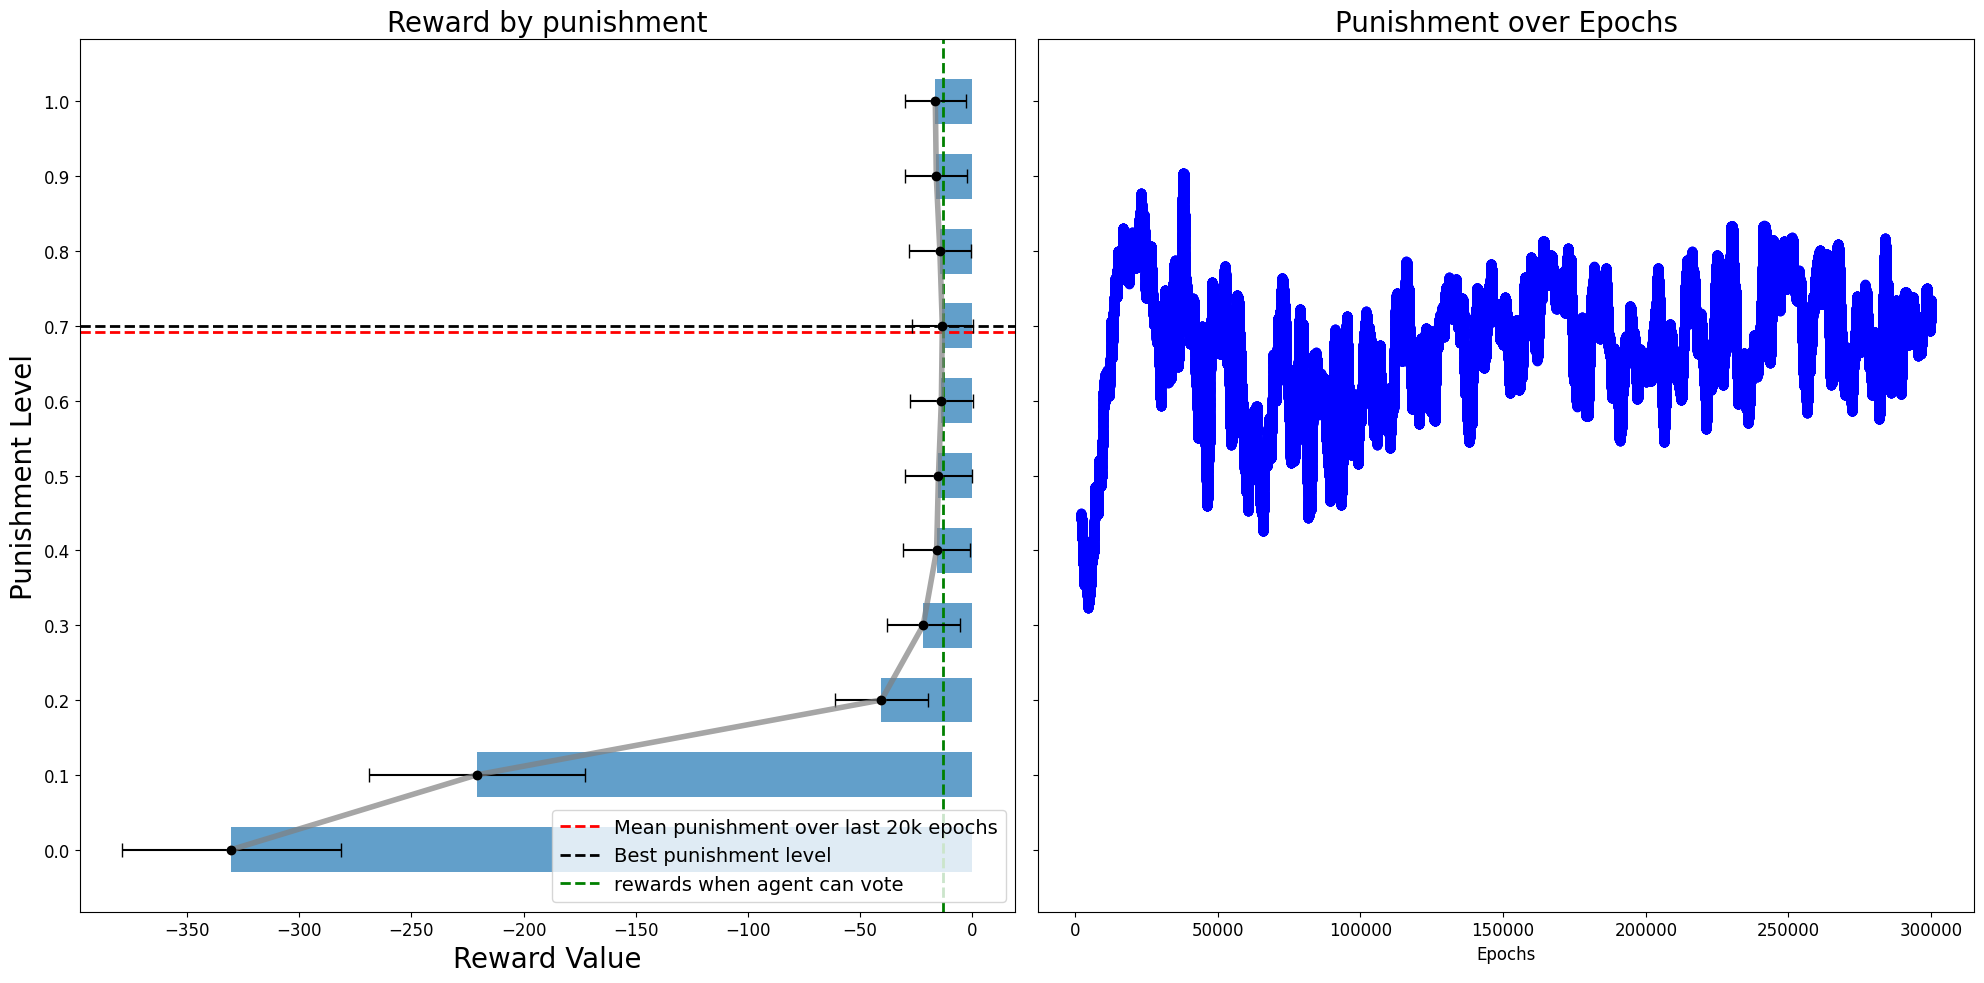

In [16]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

dir = 'res/runs/'
folders = os.listdir(dir)

voting_run = 'extended_random_exploration_L_n_tau_nstep5_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251021-154042'
# voting_run = 'extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134707'
# voting_run = "extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134620"
# Example data
punishment_levels = pd.read_csv(f'{dir}/{voting_run}/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=2000).mean()
epochs = list(range(len(punishment_levels)))
# get the reward for the voting condition
voting_reward = pd.read_csv(f'{dir}/{voting_run}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()

# get the reward for each fixed punishment level
rewards = []
# get the variance of the reward for each fixed punishment level
rewards_std = []
count = 0
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'p{i}' in f and 'prob' in f and 'n_tau_nstep5' in f and 'pnoobs'  and '6a' in f:
            reward = pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()
            rewards.append(reward)
            rewards_std.append(pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].std())
            has_f = True
            count += 1
            # print(count, i, f)
    if not has_f:
        rewards.append(0)
        rewards_std.append(0)


# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
# Left subplot: line plot (Epochs vs Punishment)
ax2.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
# use 1e+x for the ticks
#ax2.set_xticks([1e5*i for i in range(9)], [f"1e5*{i}" for i in range(9)])
ax2.set_yticks(ticks)
ax2.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax2.set_xlabel("Epochs")
ax2.set_title("Punishment over Epochs", fontsize=20)

ax1.axhline(np.mean(punishment_levels[-20000:]), color='red', linestyle='--', linewidth=2, label='Mean punishment over last 20k epochs')
ax1.axhline(np.argmax(rewards)*0.1, color='black', linestyle='--', linewidth=2, label='Best punishment level')
ax1.axvline(voting_reward, color='green', linestyle='--', linewidth=2, label='rewards when agent can vote')
# Right subplot: bar plot (Reward vs Punishment)
ax1.barh(ticks, rewards, alpha=0.7, height=0.06)
# add error bars (should be horizontal) (+- rewards_std)
ax1.errorbar(rewards, ticks, xerr=rewards_std, fmt='o', color='black', capsize=5)
ax1.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax1.set_xlabel("Reward Value", fontsize=20)
ax1.set_title("Reward by punishment", fontsize=20)
# ax1.set_xlim(-20, 2)
ax1.legend(fontsize=14, loc='lower right')
ax1.set_ylabel("Punishment Level", fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

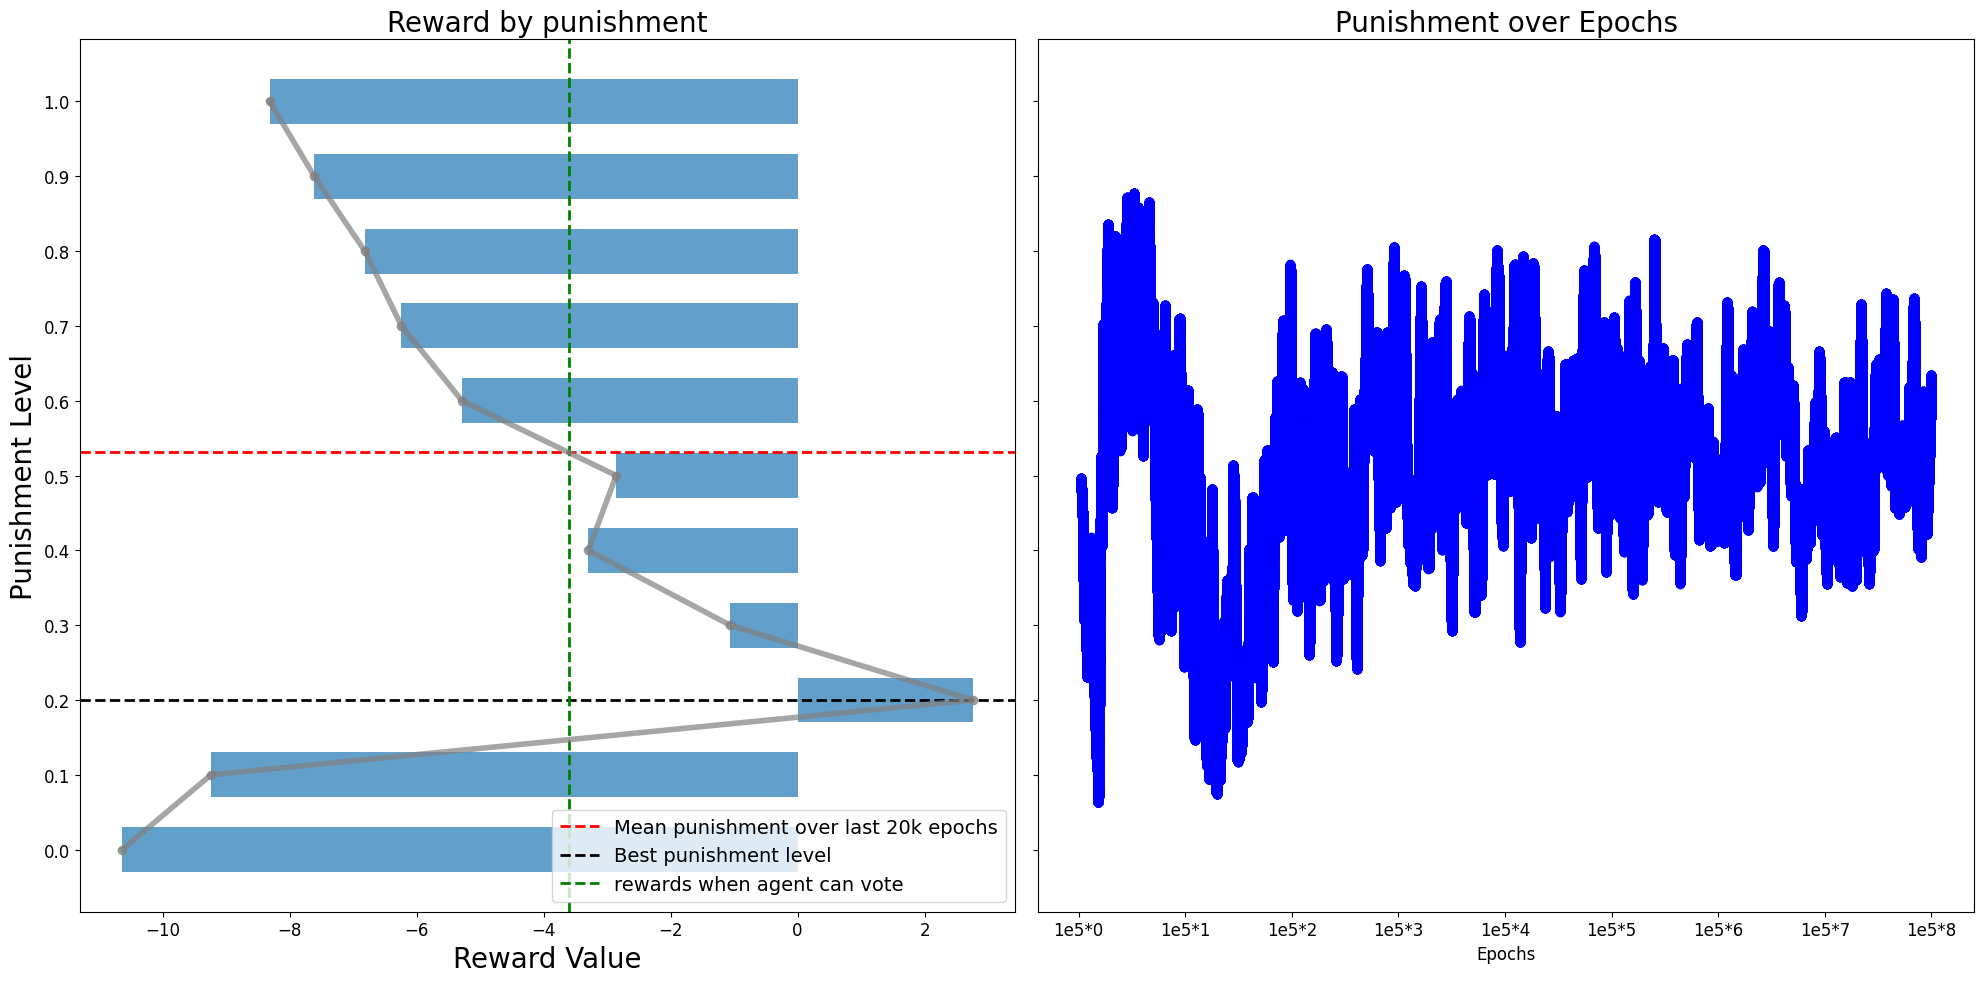

In [102]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

dir = 'res/runs_p48_a2_bs256_m2048/'
folders = os.listdir(dir)

voting_run = 'extended_random_exploration_L_n_tau_nstep5_v2_prob_ext_charm_immed_silly_pnoobs_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251008-230708'

# Example data
punishment_levels = pd.read_csv(f'{dir}/{voting_run}/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=2000).mean()
epochs = list(range(len(punishment_levels)))
# get the reward for the voting condition
voting_reward = pd.read_csv(f'{dir}/{voting_run}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()

# get the reward for each fixed punishment level
rewards = []
# get the variance of the reward for each fixed punishment level
rewards_std = []
count = 0
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'p{i}' in f and 'prob' in f and 'n_tau_nstep5' in f and 'pnoobs' in f:
            reward = pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].mean()
            rewards.append(reward)
            rewards_std.append(pd.read_csv(f'{dir}/{f}/Mean_mean_individual_score_data.csv')['Value'][-2000:].std())
            has_f = True
            count += 1
            # print(count, i, f)
    if not has_f:
        rewards.append(0)
        rewards_std.append(0)


# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
# Left subplot: line plot (Epochs vs Punishment)
ax2.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
# use 1e+x for the ticks
ax2.set_xticks([1e5*i for i in range(9)], [f"1e5*{i}" for i in range(9)])
ax2.set_yticks(ticks)
ax2.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax2.set_xlabel("Epochs")
ax2.set_title("Punishment over Epochs", fontsize=20)

ax1.axhline(np.mean(punishment_levels[-20000:]), color='red', linestyle='--', linewidth=2, label='Mean punishment over last 20k epochs')
ax1.axhline(np.argmax(rewards)*0.1, color='black', linestyle='--', linewidth=2, label='Best punishment level')
ax1.axvline(voting_reward, color='green', linestyle='--', linewidth=2, label='rewards when agent can vote')
# Right subplot: bar plot (Reward vs Punishment)
ax1.barh(ticks, rewards, alpha=0.7, height=0.06)
# add error bars (should be horizontal) (+- rewards_std)
# ax1.errorbar(rewards, ticks, xerr=rewards_std, fmt='o', color='black', capsize=5)
ax1.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax1.set_xlabel("Reward Value", fontsize=20)
ax1.set_title("Reward by punishment", fontsize=20)
# ax1.set_xlim(-10, 10)
ax1.legend(fontsize=14, loc='lower right')
ax1.set_ylabel("Punishment Level", fontsize=20)

# Adjust layout
plt.tight_layout()
plt.show()

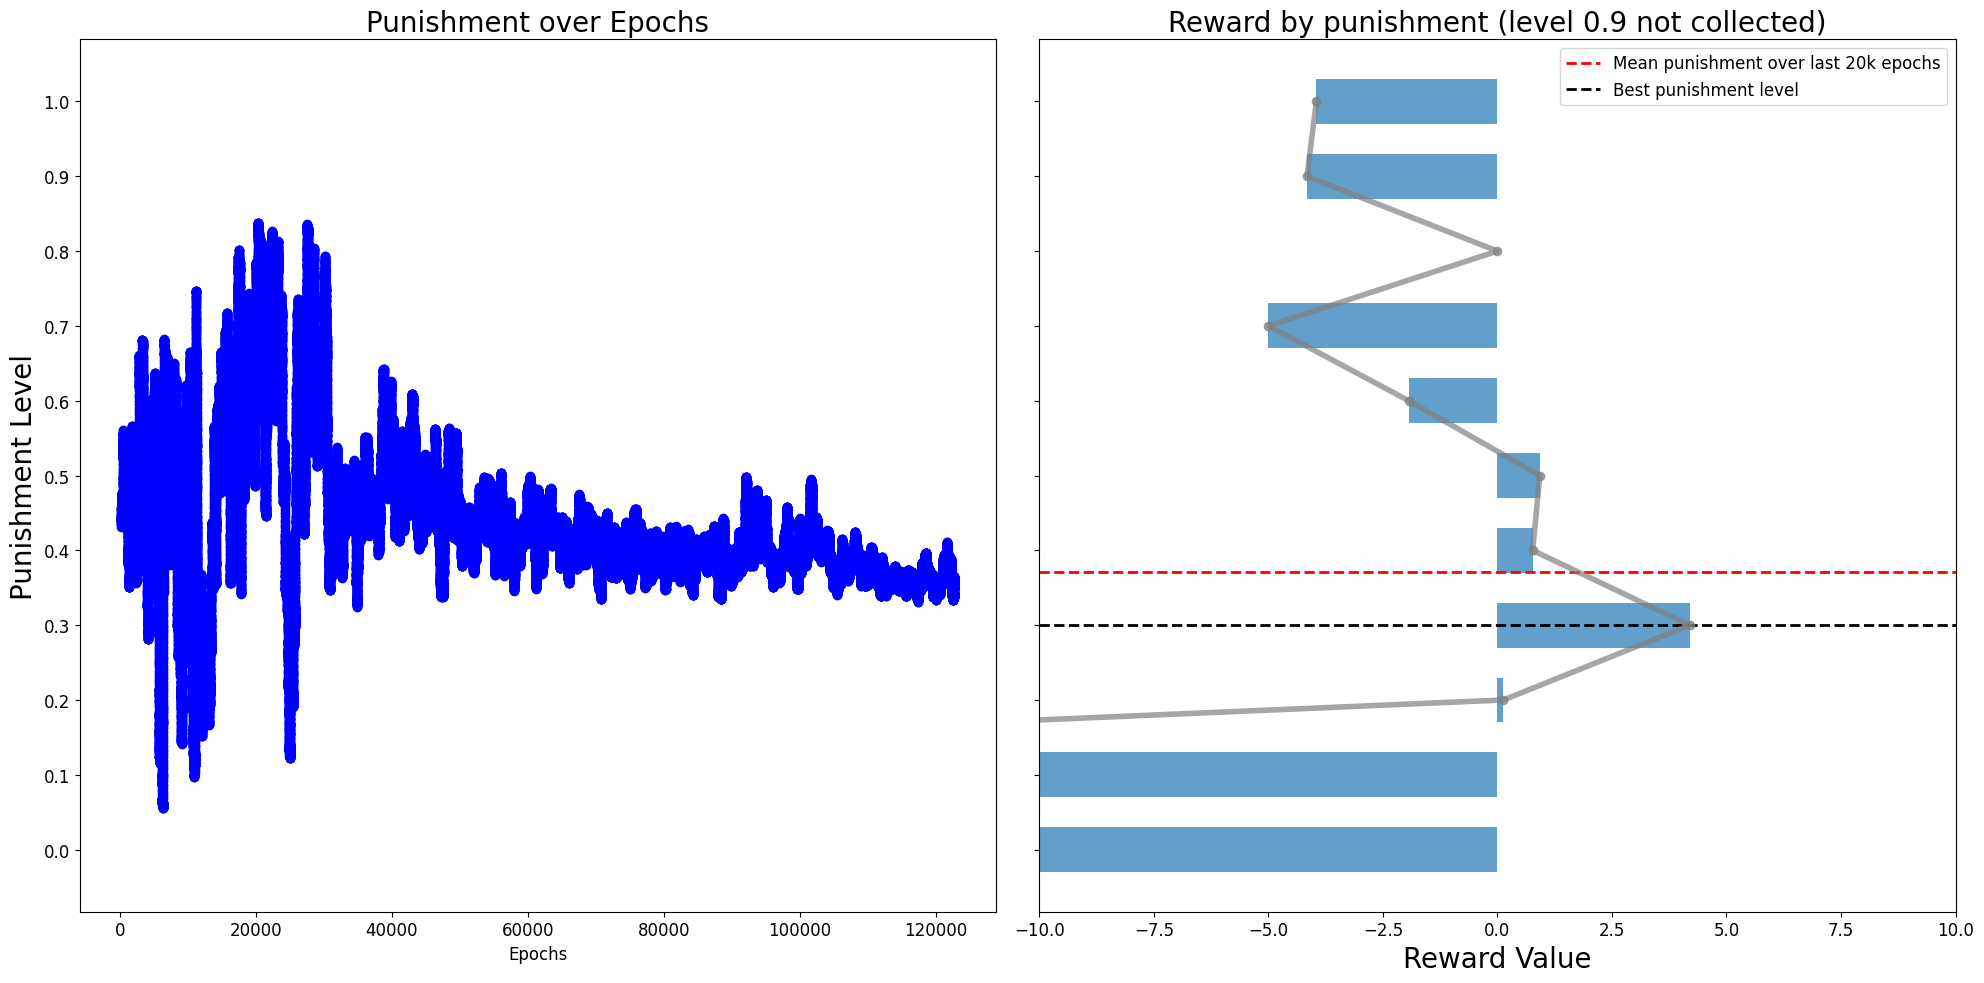

In [37]:
# plot 2 subplots: on the left, the average punishment over time, with x axis as time, y axis as average punishment; one the right, sharing the same y axis, with x axis being reward values (barh)

import matplotlib.pyplot as plt

folders = os.listdir('res')

# Example data
punishment_levels = pd.read_csv('res/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__3agents_20250924-001840/Global_average_punishment_level_data.csv')['Value']
punishment_levels = punishment_levels.rolling(window=200).mean()
epochs = list(range(len(punishment_levels)))
rewards = []
for i in range(11):
    i *= 0.1
    i = round(i, 1)
    has_f = False
    for idx, f in enumerate(folders):
        if f'punish{i}' in f:
            reward = pd.read_csv(f'res/{f}/Mean_mean_individual_score_data.csv')['Value'][-1000:].mean()
            rewards.append(reward)
            has_f = True
    if not has_f:
        rewards.append(0)
    
    

# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))

# Left subplot: line plot (Epochs vs Punishment)
ax1.plot(epochs, punishment_levels, marker='o', color="blue")
ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(ticks)
ax1.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Punishment Level", fontsize=20)
ax1.set_title("Punishment over Epochs", fontsize=20)

ax2.axhline(np.mean(punishment_levels[-20000:]), color='red', linestyle='--', linewidth=2, label='Mean punishment over last 20k epochs')
ax2.axhline(np.argmax(rewards)*0.1, color='black', linestyle='--', linewidth=2, label='Best punishment level')
# Right subplot: bar plot (Reward vs Punishment)
ax2.barh(ticks, rewards, alpha=0.7, height=0.06)
ax2.plot(rewards, ticks, alpha=0.7, linewidth=4, marker='o', color="grey")
ax2.set_xlabel("Reward Value", fontsize=20)
ax2.set_title("Reward by punishment (level 0.9 not collected)", fontsize=20)
ax2.set_xlim(-10, 10)
ax2.legend()
# Adjust layout
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Punishment over Epochs')

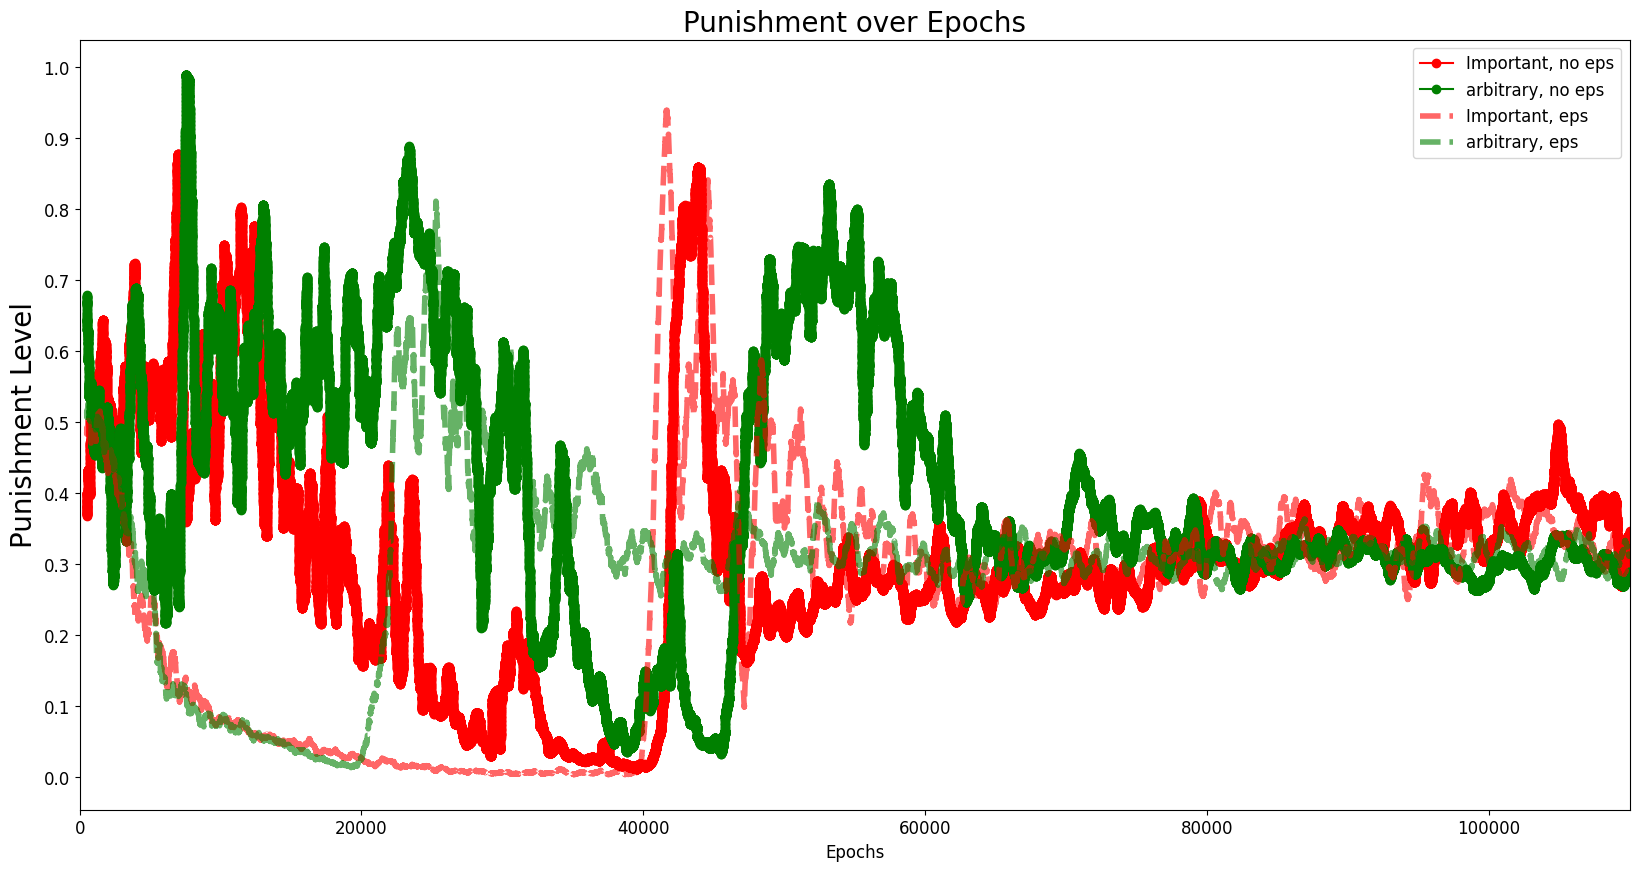

In [136]:
import matplotlib.pyplot as plt

folders = os.listdir('res')
wsize = 500
# Example data
#punishment_levels_important = pd.read_csv('res/runs_p48_a2_bs256_m2048/extended_random_exploration_v2_det_ext_charm_immed_important_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251004-165035/Global_average_punishment_level_data.csv')['Value']
#punishment_levels_important = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134707/Global_average_punishment_level_data.csv')['Value']
punishment_levels_important = pd.read_csv('res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251102-193735/Global_average_punishment_level_data.csv')['Value']
punishment_levels_important = punishment_levels_important.rolling(window=wsize).mean()
epochs_important = list(range(len(punishment_levels_important)))


punishment_levels_important_with_eps = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235341/Global_average_punishment_level_data.csv')['Value']
punishment_levels_important_with_eps = punishment_levels_important_with_eps.rolling(window=wsize).mean()
epochs_important_with_eps = list(range(len(punishment_levels_important_with_eps)))

#punishment_levels_silly = pd.read_csv('res/runs_p48run_a2_bs256_m2048/extended_random_exploration_v2_det_ext_charm_immed_silly_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251004-165111/Global_average_punishment_level_data.csv')['Value']
#punishment_levels_silly = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_6a_pknown_sknown_20251020-134620/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235425/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly = pd.read_csv('res/runs_no_exploration/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251101-222151/Global_average_punishment_level_data.csv')['Value']
#punishment_levels_silly = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_important_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235341/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly = punishment_levels_silly.rolling(window=wsize).mean()
epochs_silly = list(range(len(punishment_levels_silly)))    
    
punishment_levels_silly_with_eps = pd.read_csv('res/runs/extended_random_exploration_L_n_tau_nstep5_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251019-235425/Global_average_punishment_level_data.csv')['Value']
punishment_levels_silly_with_eps = punishment_levels_silly_with_eps.rolling(window=wsize).mean()
epochs_silly_with_eps = list(range(len(punishment_levels_silly_with_eps)))

# Create subplots: 1 row, 2 columns, share y-axis
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(20, 10))

# Left subplot: line plot (Epochs vs Punishment)
# ax1.plot(epochs, punishment_levels, marker='o', color="blue")
ax1.plot(epochs_important, punishment_levels_important, marker='o', color="red", label='Important, no eps')
ax1.plot(epochs_silly, punishment_levels_silly, marker='o', color="green", label='arbitrary, no eps')
ax1.plot(epochs_important_with_eps, punishment_levels_important_with_eps, color="red", label='Important, eps', linestyle='--', linewidth=4, alpha=0.6)
ax1.plot(epochs_silly_with_eps, punishment_levels_silly_with_eps,color="green", label='arbitrary, eps', linestyle='--', linewidth=4, alpha=0.6)
ax1.legend()
ax1.set_xlim(0, 110000)
ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(ticks)
ax1.set_yticklabels([f"{tick:.1f}" for tick in ticks])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Punishment Level", fontsize=20)
ax1.set_title("Punishment over Epochs", fontsize=20)
# ax1.set_xlim(0, 60000)

## Simulated Results

In [10]:
def make_scatter_with_fitted_trendline(
    n_points=100,
    x_min=0.0,
    x_max=10.0,
    true_slope=-1.0,
    true_intercept=0.0,
    noise_std=1.0,        # std dev of normal errors
    seed=42,
    x_label="x",
    y_label="y",
    title="Scatter Plot with Fitted Trendline",
    show=True,
    save_path=None,
):
    """
    Generate a scatter plot of data from:
        y = true_slope * x + true_intercept + epsilon
    with epsilon ~ N(0, noise_std^2),
    and draw the fitted trendline from a least-squares fit.

    Parameters
    ----------
    n_points : int
        Number of data points.
    x_min, x_max : float
        Range for x values.
    true_slope : float
        Slope used to generate the data.
    true_intercept : float
        Intercept used to generate the data.
    noise_std : float
        Standard deviation of the normal errors.
    seed : int or None
        Random seed for reproducibility.
    x_label, y_label : str
        Axis labels.
    title : str
        Plot title.
    show : bool
        Whether to display the plot.
    save_path : str or None
        If provided, path to save the figure.

    Returns
    -------
    x : np.ndarray
    y : np.ndarray
    fitted_coeffs : np.ndarray  # [slope, intercept]
    """
    # ----- Data generation -----
    if seed is not None:
        np.random.seed(seed)

    x = np.linspace(x_min, x_max, n_points)

    # Normal errors
    eps = np.random.normal(loc=0.0, scale=noise_std, size=n_points)
    y = true_slope * x + true_intercept + eps

    # ----- Fit a line to (x, y) -----
    fitted_coeffs = np.polyfit(x, y, deg=1)  # [slope, intercept]

    x_line = np.linspace(x_min, x_max, 200)
    y_line = np.polyval(fitted_coeffs, x_line)

    # ----- Plot -----
    plt.figure()
    plt.scatter(x, y, alpha=0.7, label="Data")

    plt.plot(
        x_line,
        y_line,
        linewidth=2,
        color='red',
        alpha=0.6,
        label=f"Fitted: y = {fitted_coeffs[0]:.2f}x + {fitted_coeffs[1]:.2f}",
    )

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks([])
    plt.yticks([])

    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")

    if show:
        plt.show()

    return x, y, fitted_coeffs


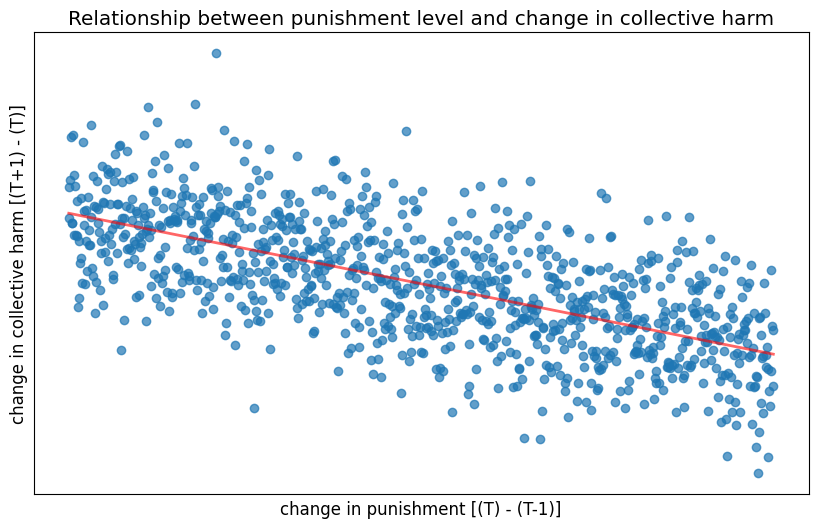

In [ ]:
make_scatter_with_fitted_trendline(
1000, 
true_slope=-0.3,  
y_label='change in collective harm [(T+1) - (T)]',
x_label='change in punishment [(T) - (T-1)]', 
title='Relationship between punishment level and change in collective harm'
);

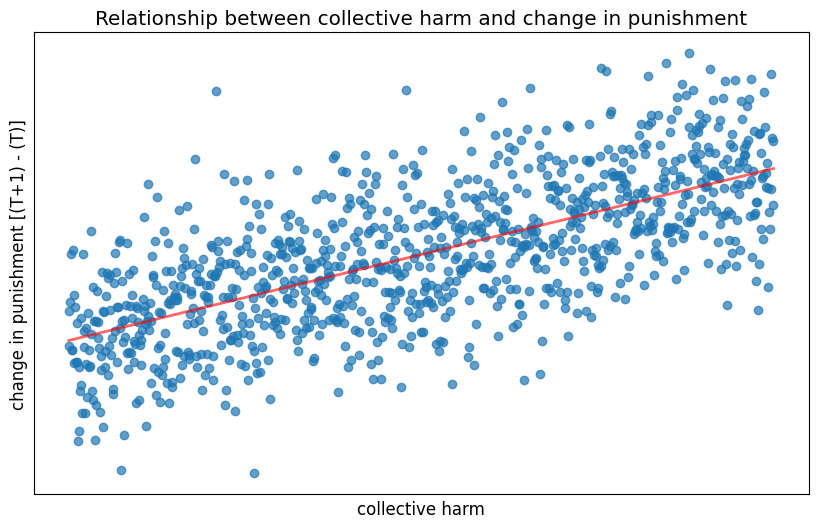

In [26]:
make_scatter_with_fitted_trendline(
1000, 
true_slope=0.3,  
x_label='collective harm',
y_label='change in punishment [(T+1) - (T)]', 
title='Relationship between collective harm and change in punishment'
);

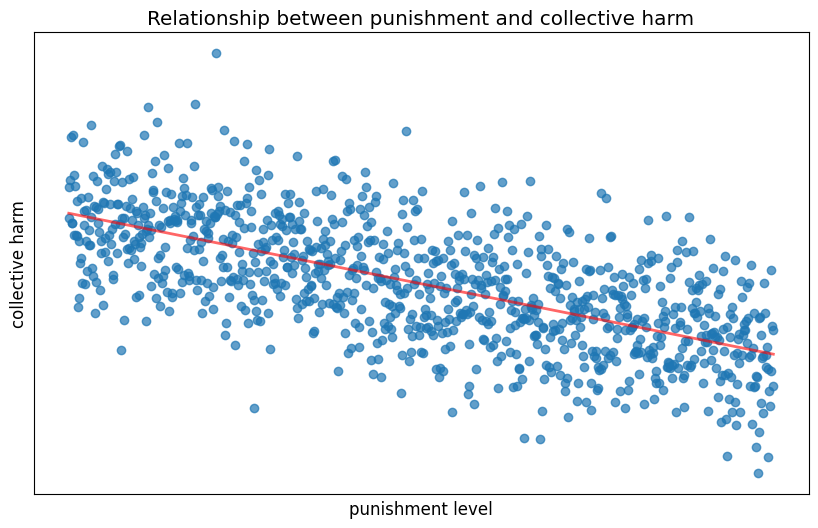

In [27]:
make_scatter_with_fitted_trendline(
1000, 
true_slope=-0.3,  
x_label='punishment level',
y_label='collective harm', 
title='Relationship between punishment and collective harm'
);

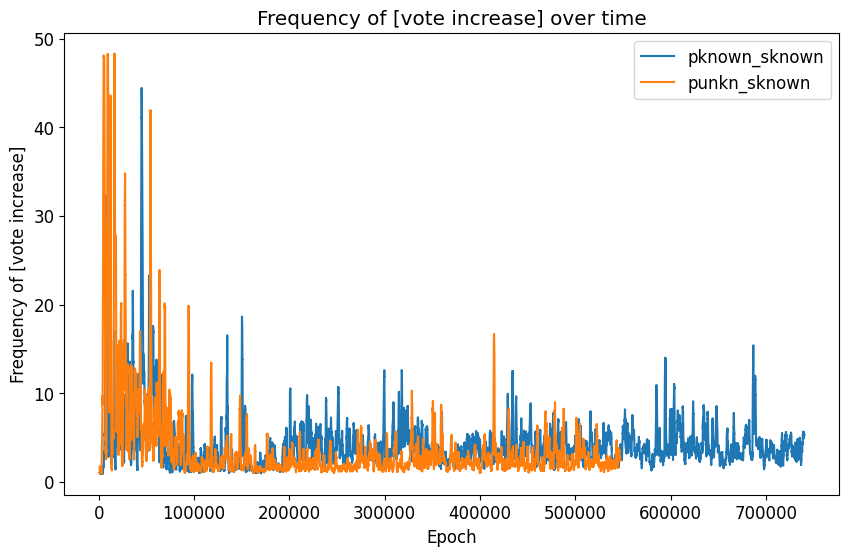

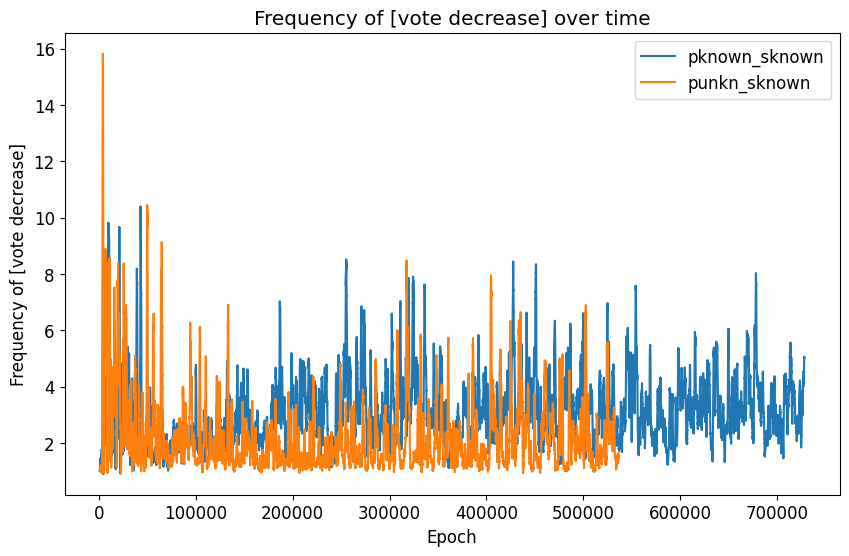

In [47]:
# plot the frequency of vote increase and decrease over time for multiple conditions

folders = [
    "res/runs_Nov16/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251116-221557",
    "res/runs_Nov26/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_punkn_sknown_20251126-164048"
]

labels = [  
    'pknown_sknown',
    'punkn_sknown',
]

# vote increase
for f, label in zip(folders, labels):
    df = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')
    plt.plot(df['Value'].rolling(window=1000).mean(), label=label)
plt.title('Frequency of [vote increase] over time')
plt.xlabel('Epoch')
plt.ylabel('Frequency of [vote increase]')
plt.legend()
plt.show()

# vote decrease
for f, label in zip(folders, labels):
    df = pd.read_csv(f'{f}/Mean_mean_action_freq_noop_data.csv')
    plt.plot(df['Value'].rolling(window=1000).mean(), label=label)
plt.title('Frequency of [vote decrease] over time')
plt.xlabel('Epoch')
plt.ylabel('Frequency of [vote decrease]')
plt.legend()
plt.show()

In [28]:
f = [
    'res/runs_debug3/simple_params_test_minor_harms_for_good_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251220-151123',
    'res/runs_debug3/validation_punishment_structure_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251219-004358',
    'res/runs_debug3/validation_ppo_v3_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251219-204259',
     "res/runs_debug3/corrected_simple_params_gamma0.95_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225406",
    "res/runs_debug3/corrected_simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225255",
    "res/runs_debug3/original_params_learningparamsv2_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251215-152637",
    'res/runs_debug3/orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251210-231740',
    "res/runs_debug3/simple_params_v5_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-152834",
    "res/runs_debug3/simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-224938",
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162807',
][-1]

In [39]:
f = 'res/runs_debug3/validate_reward_structure_socialharm20_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251223-005148'

In [44]:
f = 'res/runs_debug3/validate_reward_structure_socialharm14_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251223-174030'

In [42]:
f = 'res/runs_debug3/validate_reward_structure_socialharm7.5_4agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_4a_pknown_sknown_20251223-174530'

In [36]:
f = 'res/runs_debug3/validate_reward_structure_socialharm14_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251223-174030'

In [16]:
f = 'res/runs_debug3/validate_reward_structure_socialharm7.5_4agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_4a_pknown_sknown_20251223-174530'

In [24]:
f = 'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-163058'


In [19]:
f = 'res/runs_Nov14/epsilon0.0_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200443'

In [16]:
f = 'res/runs_debug3/validate_reward_structure_socialharm3_10agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20251224-163408'

In [29]:
f ='res/runs_debug3/validate_reward_structure_complex_para_3agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20251226-012952'

In [20]:
f = 'res/runs_debug3/test_lstm_cpc_dynamic_punishment_dec30_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_lstm_cpc_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20251230-202359'

In [14]:
f = 'res/runs_debug3/validate_3agents_complex_params_corrected_values_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20260101-203024'

In [35]:
f= 'res/runs_debug3/validate_10agents_complex_params_corrected_values_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260101-203440'

In [12]:
f = 'res/runs_debug3/validate_ppo_10agents_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260104-200742'

In [17]:
f = 'res/runs_debug3/voting_season_10steps_mode_iqn_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260107-173454'

In [15]:
f = 'res/runs_debug3/voting_season_5steps_mode_iqn_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260107-172531'

In [34]:
f = 'res/runs_debug4/slow_voting_noreset_5steps_mode_iqn_separate_models_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260113-114919'

In [32]:
f =  'res/runs_debug4/slow_voting_noreset_5steps_mode_iqn_separate_models_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260113-114937'

In [30]:
f = 'res/runs_debug4/phased_voting_s5_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_preset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-003531'

In [21]:
f = 'res/runs_debug4/phased_voting_s100_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_pnoreset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-170205'

In [16]:
f = 'res/runs_debug4/iqn_corrected_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_preset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-164739'

In [19]:
f = 'res/runs_debug3/validate_ppo_10agents_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260104-200742'

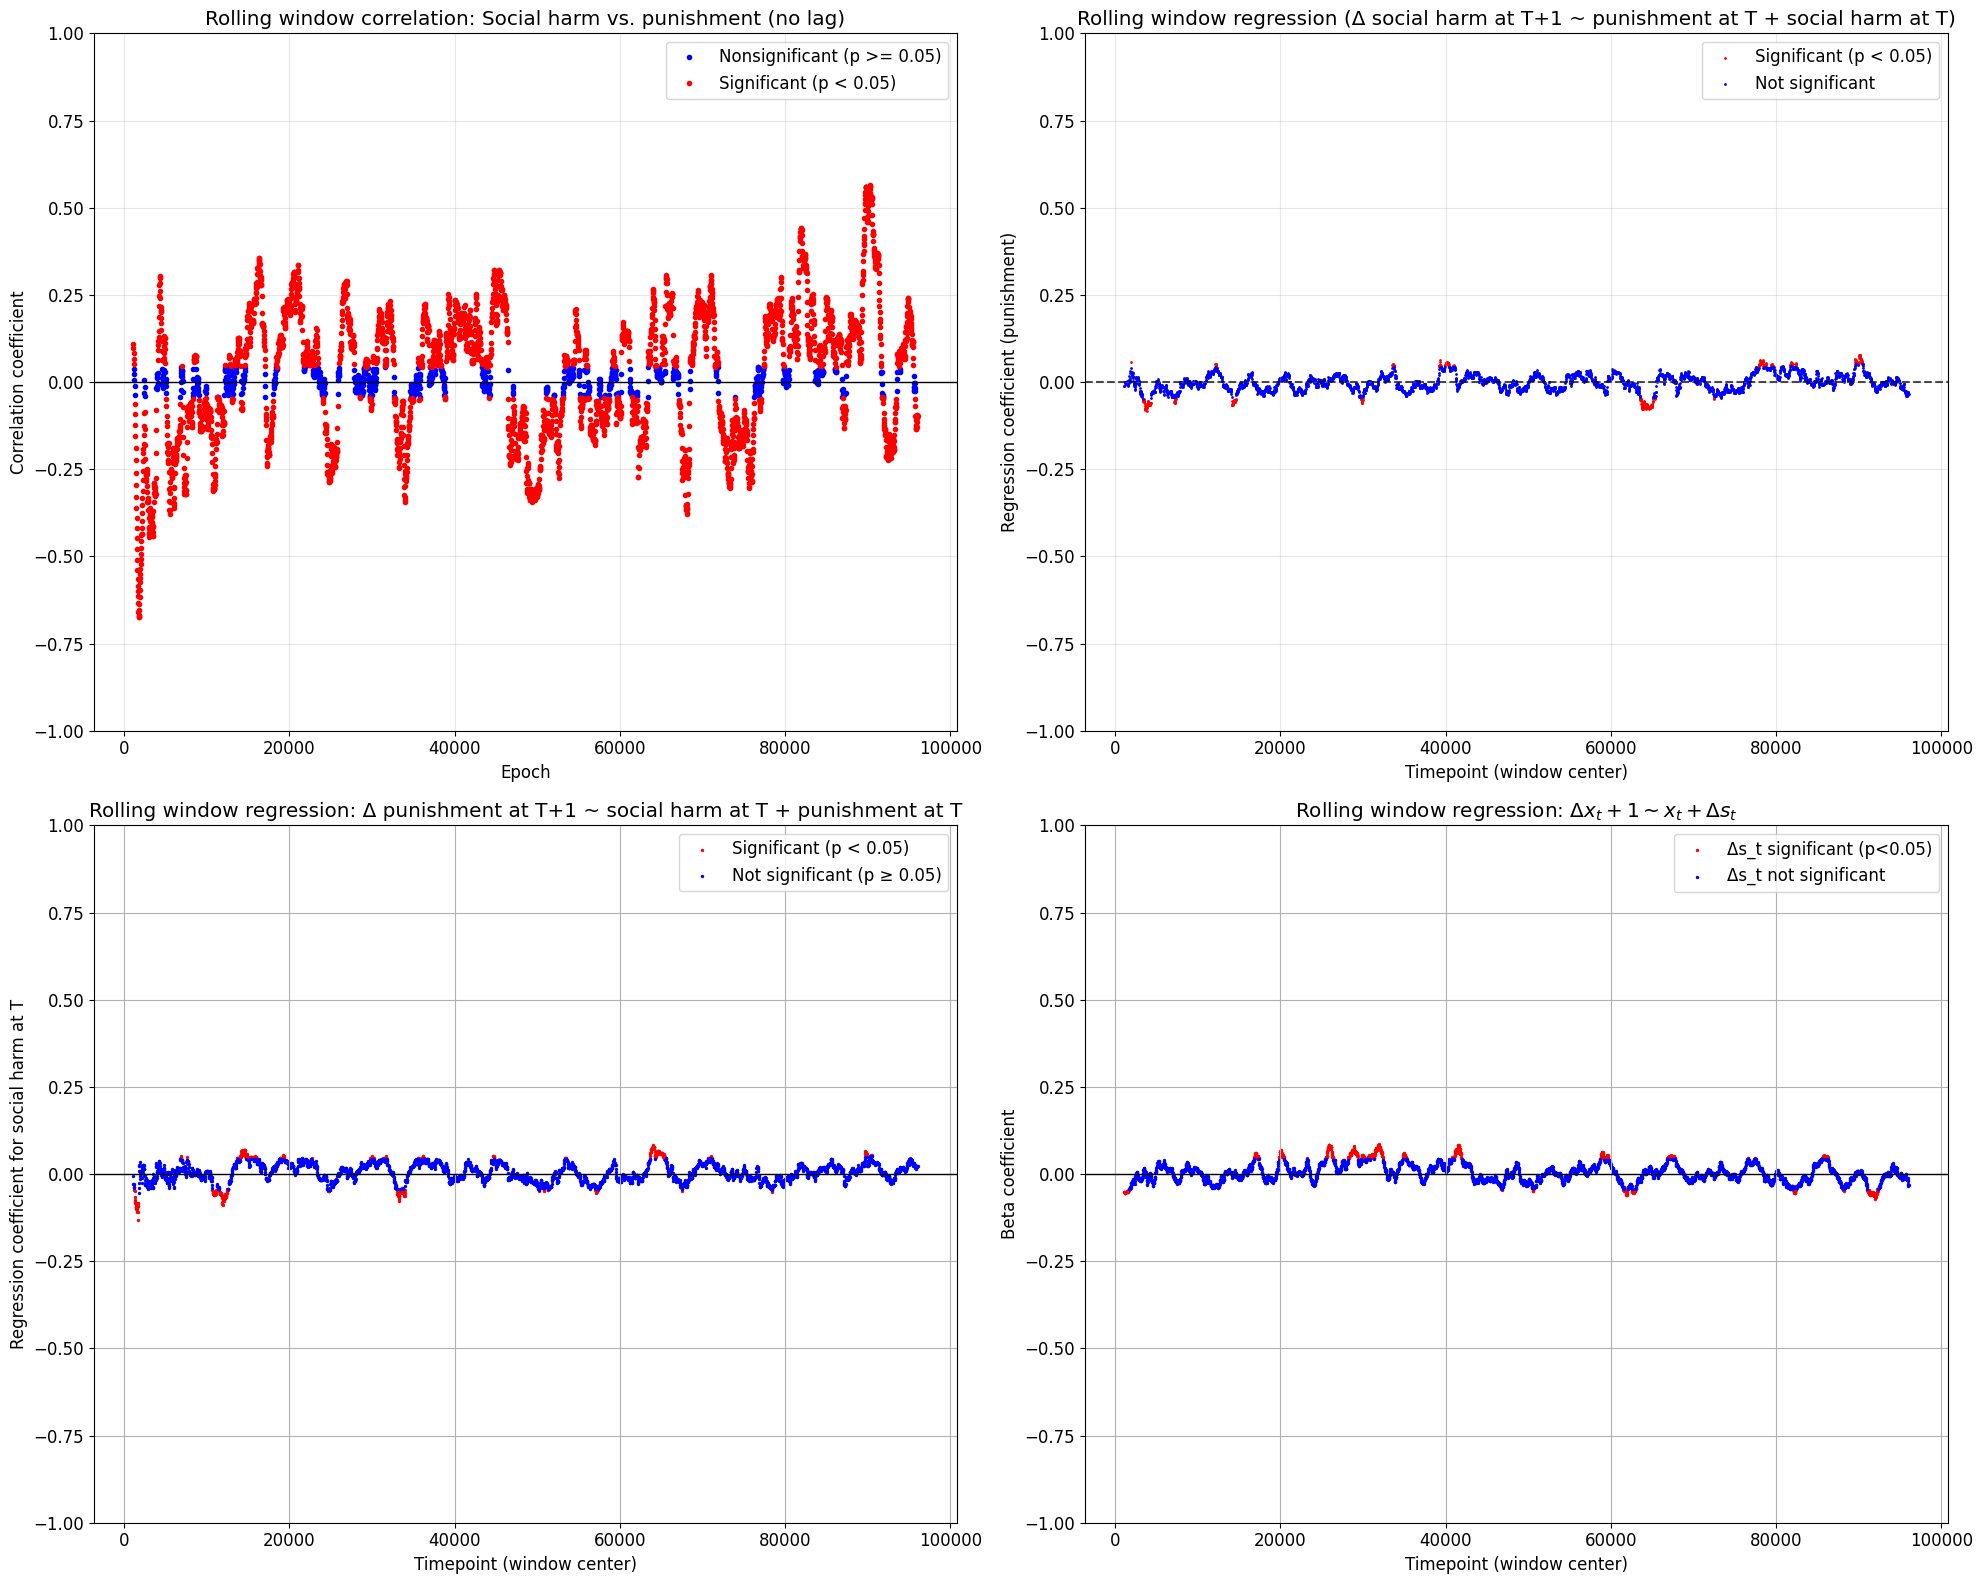

In [18]:
system_analysis(
    f, 
    True,
    smooth_social_harm_window=100, 
    smooth_punishment_window=100,
    window_size=2000, 
    step_size=20, 
    lag=1, 
    start_timepoint=0, 
    xlim=None)

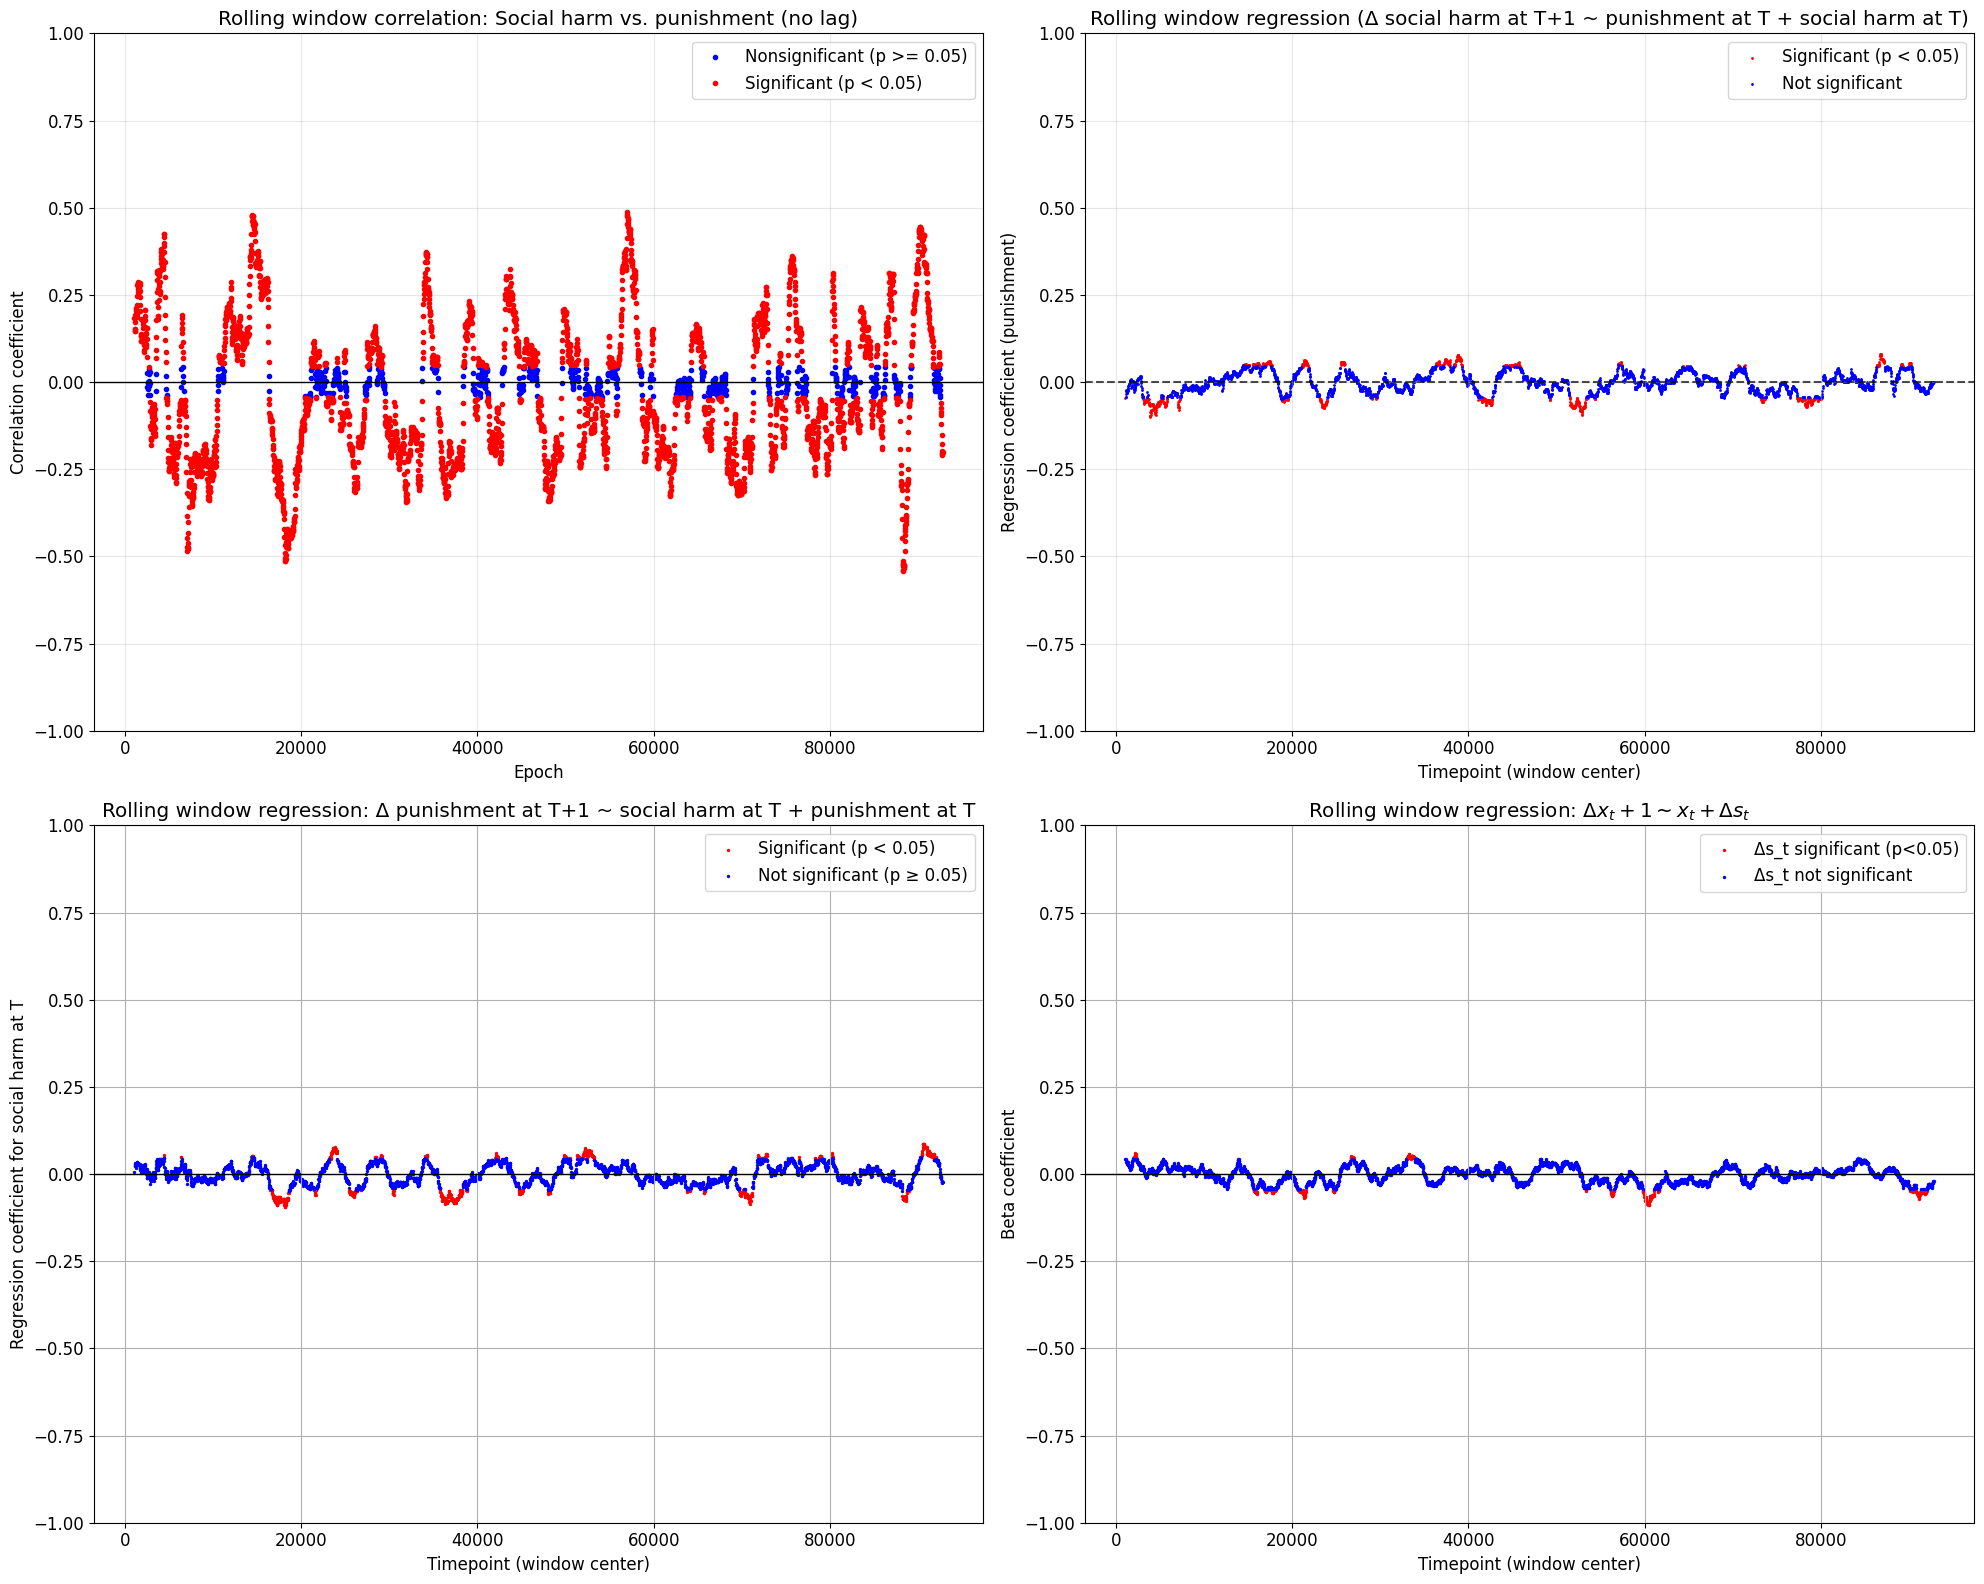

In [23]:
system_analysis(
    f, 
    True,
    smooth_social_harm_window=100, 
    smooth_punishment_window=100,
    window_size=2000, 
    step_size=20, 
    lag=1, 
    start_timepoint=0, 
    xlim=None)

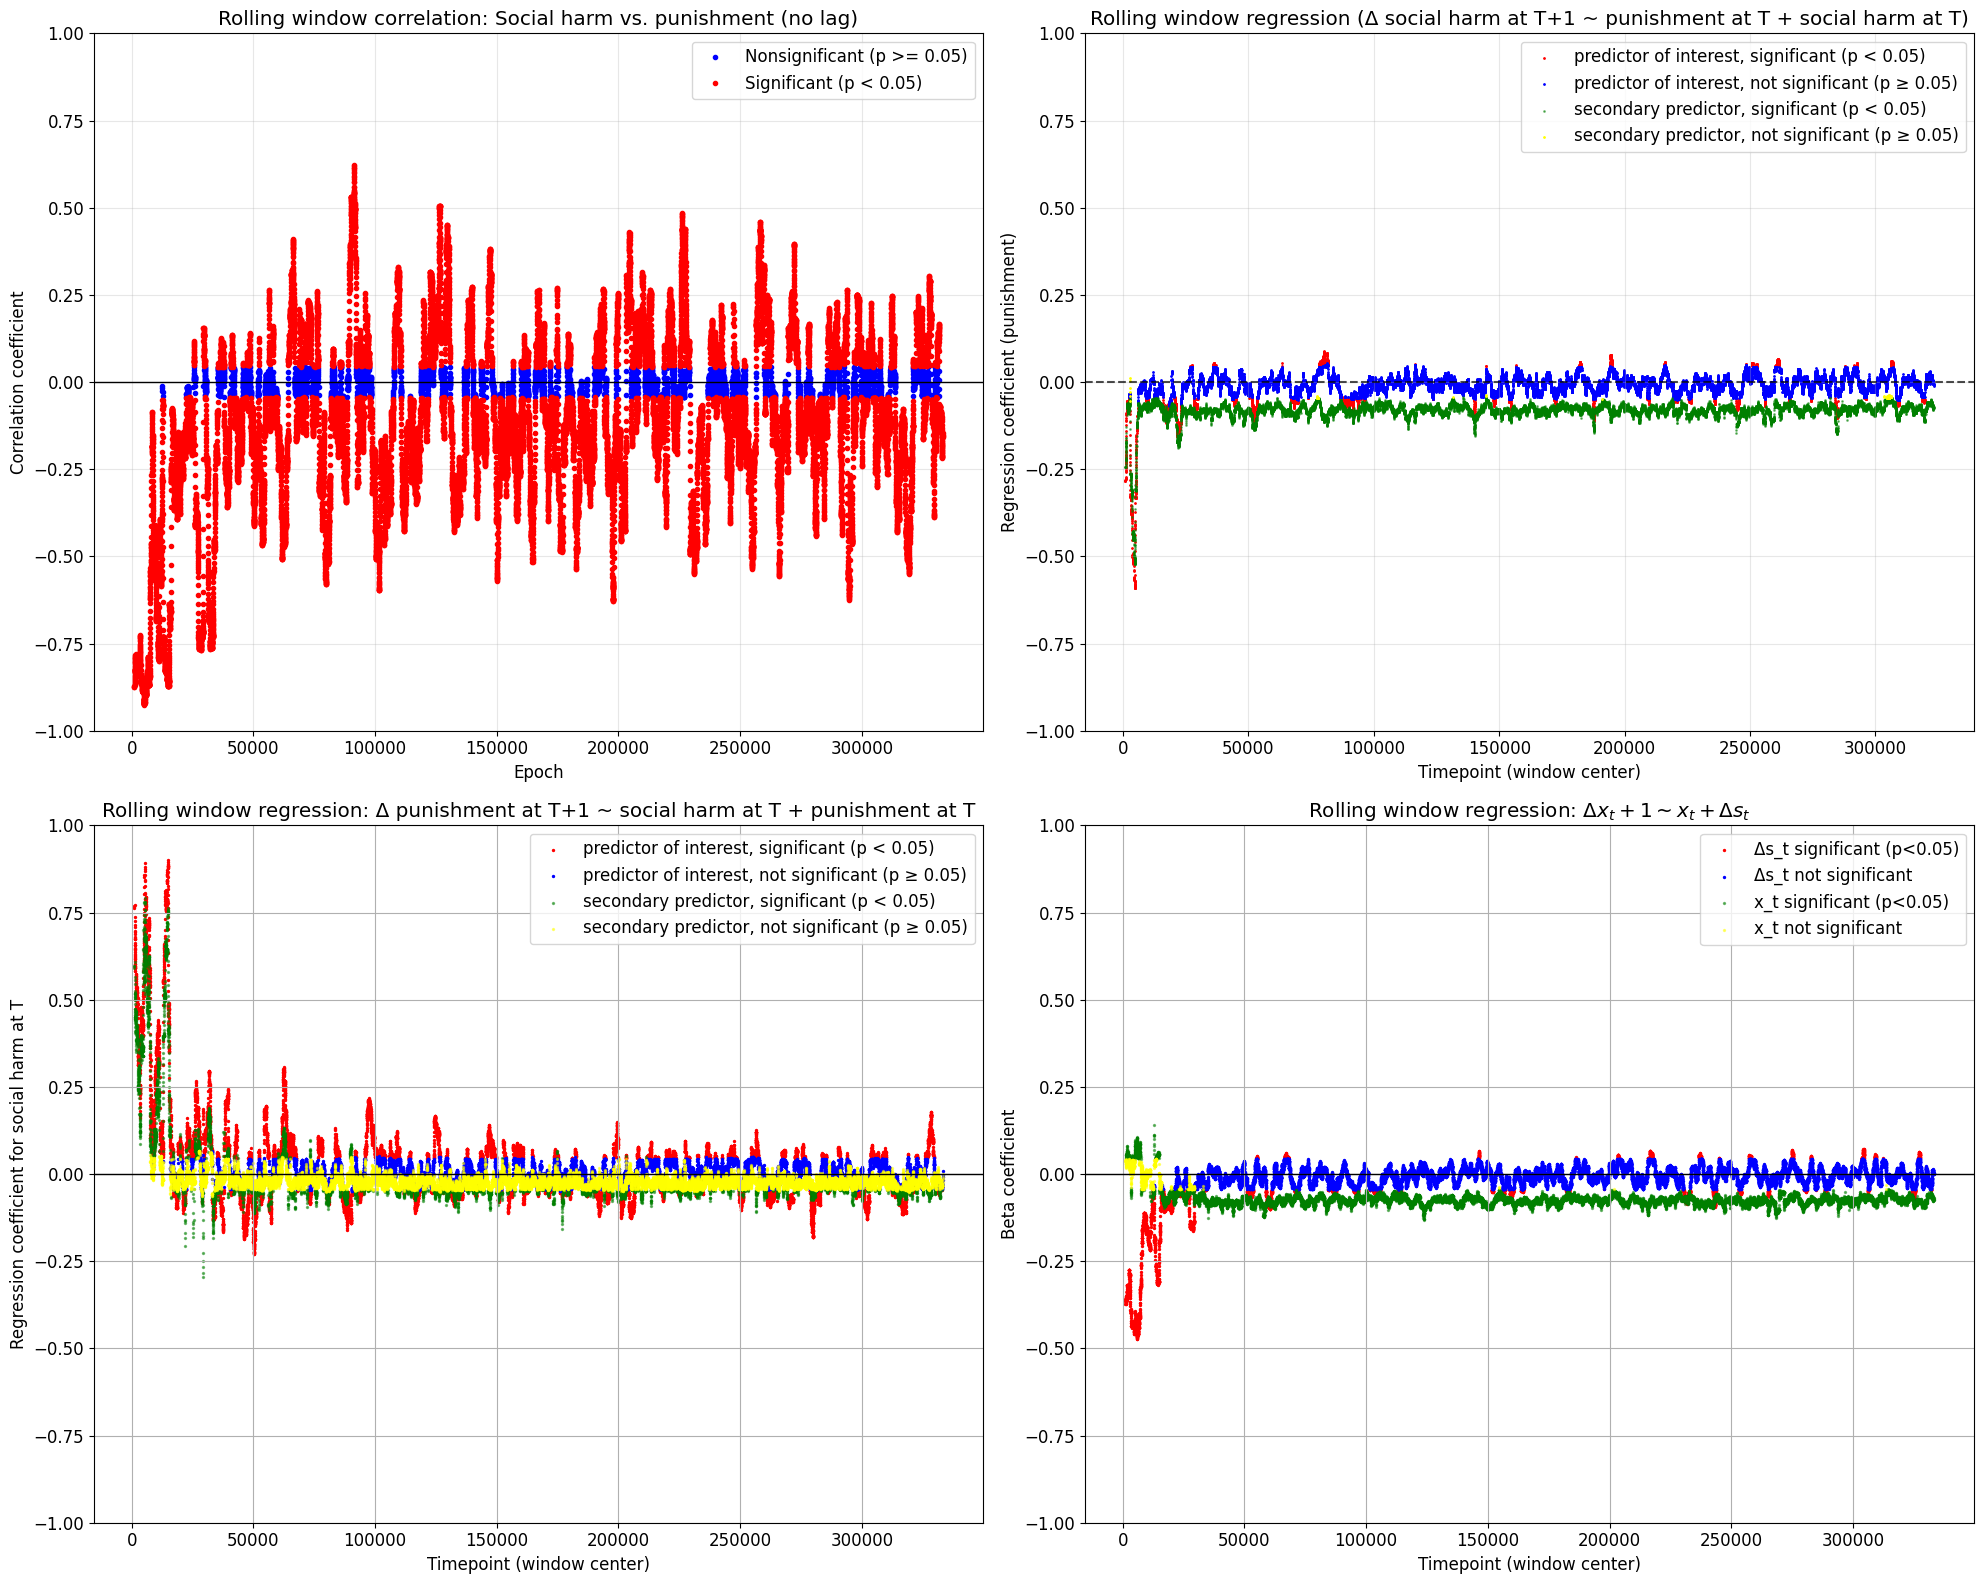

In [15]:
system_analysis_multi(
    f, 
    smooth_social_harm_window=100, 
    smooth_punishment_window=100, 
    window_size=2000, 
    step_size=10, 
    lag=1, 
    start_timepoint=10000, 
    xlim=None)

# correlation analysis

In [ ]:
# plot the overall punishment level trajectory of multiple conditions
fs = [
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030',
    # 'res/runs_Nov14/epsilon0.0_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200443',
    "res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_punkn_sknown_20251114-200134",
]

fs = [
    "res/runs_Nov16/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251116-221557",
    "res/runs_Nov26/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_punkn_sknown_20251126-164048"
]

fs = [
    'res/runs_simple_params/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_pknown_sknown_20251201-143655',
    'res/runs_simple_params/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_punkn_sknown_20251201-143521'
]

fs = [
    'res/runs_debug1/corrected_orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-134348',
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-163058'
]
conditions = [
    'pknown_sknown',
    'punkn_sknown',
]

wsize = 200
last_n_epochs = 20000
for ind, c in enumerate(conditions):
    # f = [f for f in fs if c in f][0]
    f = fs[ind]
    punishment_levels = pd.read_csv(f'{f}/Global_current_punishment_level_data.csv')['Value'].rolling(window=wsize).mean()[wsize:]
    plt.plot(punishment_levels.rolling(window=wsize).mean(), label=['punishment level visible', 'punishment level hidden'][ind], linestyle='-', linewidth=1, color=['tab:blue', 'tab:orange'][ind])
    plt.axhline(np.mean(punishment_levels[-last_n_epochs:]), label=['punishment level visible', 'punishment level hidden'][ind]+'_mean_last_200k_epochs', linestyle='--', linewidth=2, color=['tab:blue', 'tab:orange'][ind])
plt.legend()
plt.show()


In [18]:
os.listdir('res/runs_debug1/')[2]

'simple_params_p25_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-223847'

### collective harm at T ~ punishment at T

Social harm length: 393346
Punishment levels length: 393346
✓ Lengths match - both metrics logged once per epoch
Correlation between social harm and punishment: -0.2287, p-value: 0.0000


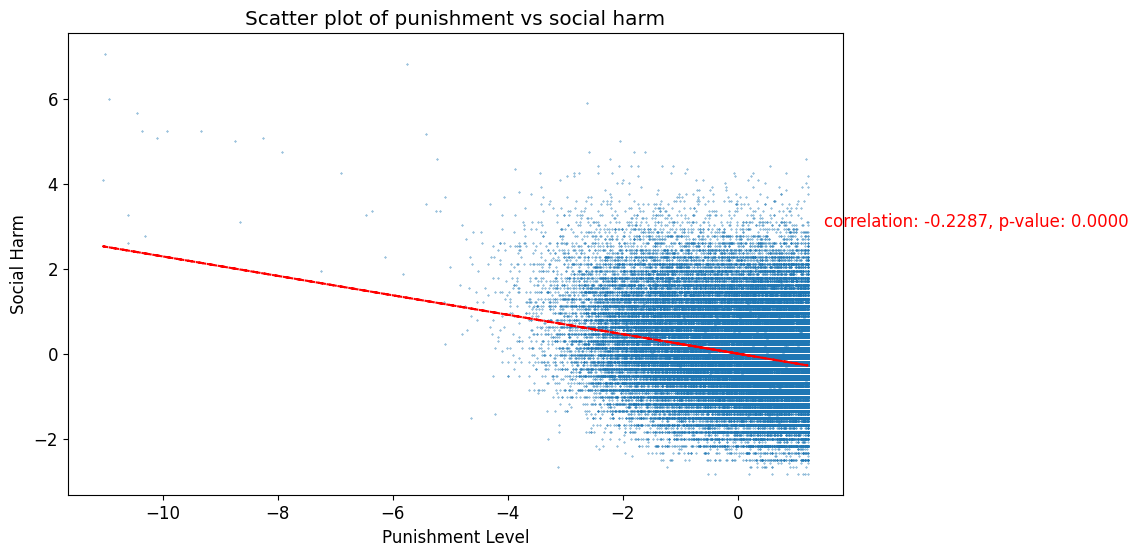

In [37]:
## correlation bewteen social harm and punishment (correlation test + scatter plot)

import numpy as np
import pandas as pd

f = [
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030',
    'res/runs_Nov14/epsilon0.0_v2_det_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200443',
    "res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_punkn_sknown_20251114-200134"
][2]

# f = [
#       "res/runs_Nov16/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251116-221557",
#     "res/runs_Nov16/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_punkn_sknown_20251116-221629"
# ][1]

# f = [
#     "res/runs_Nov26/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_punkn_sknown_20251126-164048",
# ][0]

f = [
    'res/runs_simple_params/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251201-143529',
    'res/runs_simple_params/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_pknown_sknown_20251201-143655',
    'res/runs_simple_params/epsilon0.0_v2_prob_ext_charm_immed_silly_pobs_pothobs_noapp_norep_sp_r0.005_v4_m10_cvTrue_meTrue_2a_punkn_sknown_20251201-143521'
][0]

f = [
    "res/runs_debug3/simple_params_v5_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-152834",
    "res/runs_debug3/corrected_simple_params_gamma0.95_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225406",
    "res/runs_debug3/corrected_simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225255",
    "res/runs_debug3/simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-224938",
    "res/runs_debug3/original_params_learningparamsv2_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251215-152637",
    "res/runs_debug3/simple_params_v3_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251215-145855",
    "res/runs_debug3/simple_params_v3_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251214-204027",
    "res/runs_debug3/simple_params_v2_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251213-202005",
    'res/runs_debug3/orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251210-231740',
    'res/runs_debug1/simple_params_p25_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-223847',
    'res/runs_debug1/orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-224326',
    'res/runs_debug1/simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-224132',
    'res/runs_debug1/corrected_orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-134348',
    'res/runs_debug2/with_norm_enforcer_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_ne_th50_dr990_is-05_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251210-003702',
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-163058',
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162807',
    'res/runs_debug2/simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162411'
][3]

f ='res/runs_debug3/validate_reward_structure_complex_para_3agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20251226-012952'
# parameters
wsize = 1
# Load social harm and punishment data
social_harm = pd.read_csv(f'{f}/Mean_mean_social_harm_received_data.csv')
punishment_levels = pd.read_csv(f'{f}/Global_average_punishment_level_data.csv')
vote_increase_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_increase_data.csv')
vote_decrease_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')


# remove missing values
social_harm = social_harm.rename(columns={'Value': 'social_harm'})
punishment_levels = punishment_levels.rename(columns={'Value': 'punishment_levels'})
vote_increase_freq = vote_increase_freq.rename(columns={'Value': 'vote_increase_freq'})
vote_decrease_freq = vote_decrease_freq.rename(columns={'Value': 'vote_decrease_freq'})
df_harm_and_punishment = pd.concat([social_harm, punishment_levels], axis=1)
df_harm_and_punishment = df_harm_and_punishment.dropna()
social_harm = df_harm_and_punishment['social_harm'].rolling(window=wsize).mean()
punishment_levels = df_harm_and_punishment['punishment_levels'].rolling(window=wsize).mean()
# vote_increase_freq = df_harm_and_punishment['vote_increase_freq']
# vote_decrease_freq = df_harm_and_punishment['vote_decrease_freq']

# Check if lengths match (they should - both are logged once per epoch)
# However, unequal lengths can occur due to:
# 1. TensorBoard event file corruption/incomplete writes
# 2. Early experiment termination (crash/interrupt)
# 3. Tag name changes between code versions
# 4. Partial logging failures
print(f"Social harm length: {len(social_harm)}")
print(f"Punishment levels length: {len(punishment_levels)}")
if len(social_harm) != len(punishment_levels):
    print(f"⚠️  WARNING: Length mismatch detected!")
    print(f"   Difference: {abs(len(social_harm) - len(punishment_levels))} epochs")
    print(f"   Possible causes: event file corruption, early termination, or logging issues")
    min_len = min(len(social_harm), len(punishment_levels))
    social_harm = social_harm[:min_len]
    punishment_levels = punishment_levels[:min_len]
    print(f"   Truncated both to length: {min_len} (using first {min_len} epochs)")
else:
    print("✓ Lengths match - both metrics logged once per epoch")

#parameters
lag = 1
start_timepoint = 300000

social_harm_transformed = zscore(social_harm[start_timepoint:])
punishment_levels_transformed = zscore(punishment_levels[start_timepoint:])
# Calculate correlation, p-value
correlation, p_value = pearsonr(social_harm_transformed, punishment_levels_transformed)
print(f"Correlation between social harm and punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(punishment_levels_transformed, social_harm_transformed, s=0.1)
plt.xlabel("Punishment Level")
plt.ylabel("Social Harm")
plt.title("Scatter plot of punishment vs social harm")
# trendline fitted for the relation
z = np.polyfit(punishment_levels_transformed, social_harm_transformed, 1)
p = np.poly1d(z)
plt.plot(punishment_levels_transformed, p(punishment_levels_transformed), "r--")

plt.text(1.5, 3, f"correlation: {correlation:.4f}, p-value: {p_value:.4f}", color='red')
plt.show()



In [81]:
vote_increase_freq.info()

<class 'pandas.core.series.Series'>
Index: 8034 entries, 0 to 8033
Series name: vote_increase_freq
Non-Null Count  Dtype  
--------------  -----  
8034 non-null   float64
dtypes: float64(1)
memory usage: 125.5 KB


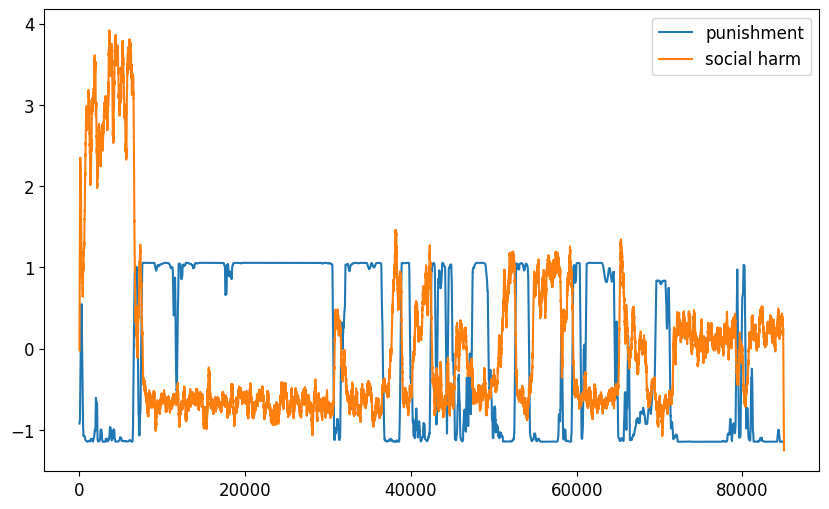

In [103]:
h_smooth_zscore = zscore(h_smooth)
s_smooth_zscore = zscore(s_smooth)
plt.plot(np.arange(len(s_smooth_zscore)), s_smooth_zscore, label='punishment')
plt.plot(np.arange(len(h_smooth_zscore)), h_smooth_zscore, label='social harm')
plt.legend()
plt.show()

In [ ]:
# ============================================================
# COMPLETE ANALYSIS CELL (all data loaded at the beginning)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ------------------------------------------------------------
# 0) LOAD DATA (ONLY PLACE WHERE DATA ENTERS THE PIPELINE)
# ------------------------------------------------------------
# Replace these with your actual loading code if needed
# Example: np.load(), pd.read_csv(), etc.

# social_harm = np.asarray(social_harm, dtype=float)
# punishment_levels = np.asarray(punishment_levels, dtype=float)

assert social_harm.ndim == 1
assert punishment_levels.ndim == 1
assert len(social_harm) == len(punishment_levels)

T = len(punishment_levels)

# ------------------------------------------------------------
# 1) PARAMETERS
# ------------------------------------------------------------
eps = 0.2          # threshold for "zero punishment"
k = 200             # smoothing window for harm
W = 500             # event-trigger window (+/- W)

# ------------------------------------------------------------
# 2) HELPER FUNCTIONS
# ------------------------------------------------------------
def moving_avg(x, k):
    if k <= 1:
        return x.copy()
    return np.convolve(x, np.ones(k) / k, mode="same")

def event_triggered_average(x, events, window):
    segments = []
    for t in events:
        if t - window >= 0 and t + window < len(x):
            segments.append(x[t - window : t + window + 1])
    return np.mean(segments, axis=0) if len(segments) > 0 else None

def plot_event(tgrid, y, title, ylabel):
    plt.figure(figsize=(10, 4))
    if y is not None:
        plt.plot(tgrid, y)
    plt.axvline(0, linestyle="--")
    plt.xlabel("time relative to transition")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 3) CORE VARIABLES
# ------------------------------------------------------------
s = punishment_levels
h = social_harm
h_smooth = moving_avg(h, k)
s_smooth = moving_avg(s, k)

Z = (s <= eps).astype(int)     # zero-punishment regime indicator
ds = np.diff(s)               # punishment change

# ------------------------------------------------------------
# 4) DETECT REGIME TRANSITIONS
# ------------------------------------------------------------
zero_to_pos = np.where((s[:-1] <= eps) & (s[1:] > eps))[0] + 1
pos_to_zero = np.where((s[:-1] > eps) & (s[1:] <= eps))[0] + 1

print(f"Total timesteps: {T}")
print(f"Zero → positive transitions: {len(zero_to_pos)}")
print(f"Positive → zero transitions: {len(pos_to_zero)}")

# ------------------------------------------------------------
# 5) EVENT-TRIGGERED AVERAGES (STRONGEST EVIDENCE)
# ------------------------------------------------------------
tgrid = np.arange(-W, W + 1)

avg_h_up = event_triggered_average(h_smooth, zero_to_pos, W)
avg_s_up = event_triggered_average(s, zero_to_pos, W)

avg_h_dn = event_triggered_average(h_smooth, pos_to_zero, W)
avg_s_dn = event_triggered_average(s, pos_to_zero, W)

plot_event(tgrid, avg_h_up, "Harm before zero → positive punishment", "harm")
plot_event(tgrid, avg_s_up, "Punishment around zero → positive transition", "punishment")

plot_event(tgrid, avg_h_dn, "Harm before positive → zero punishment", "harm")
plot_event(tgrid, avg_s_dn, "Punishment around positive → zero transition", "punishment")

# ------------------------------------------------------------
# 6) DIRECTIONAL ASYMMETRY ANALYSIS
# ------------------------------------------------------------
increase = np.clip(ds, 0, None)
decrease = -np.clip(ds, None, 0)

quantiles = np.quantile(h_smooth[:-1], [0.25, 0.5, 0.75])
bins = [-np.inf, *quantiles, np.inf]
labels = ["Q1 low harm", "Q2", "Q3", "Q4 high harm"]

def binned_mean(x, y, bins):
    return [
        y[(x > lo) & (x <= hi)].mean()
        for lo, hi in zip(bins[:-1], bins[1:])
    ]

inc_means = binned_mean(h_smooth[:-1], increase, bins)
dec_means = binned_mean(h_smooth[:-1], decrease, bins)

plt.figure(figsize=(8, 4))
plt.plot(inc_means, marker="o", label="increase")
plt.plot(dec_means, marker="o", label="decrease")
plt.xticks(range(4), labels, rotation=20)
plt.ylabel("mean magnitude")
plt.title("Directional punishment adjustment vs harm")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7) REGIME-CONDITIONAL REGRESSION
# ------------------------------------------------------------
X = np.column_stack([
    h_smooth[:-1],
    Z[:-1],
    h_smooth[:-1] * Z[:-1],
])

X = sm.add_constant(X)
y = ds

model = sm.OLS(y, X).fit()
print(model.summary())

# ------------------------------------------------------------
# END OF CELL
# ------------------------------------------------------------


In [29]:
lag = 10
pearsonr(social_harm_transformed[:-lag], punishment_levels_transformed[lag:])

PearsonRResult(statistic=-0.3068682424325083, pvalue=0.0)

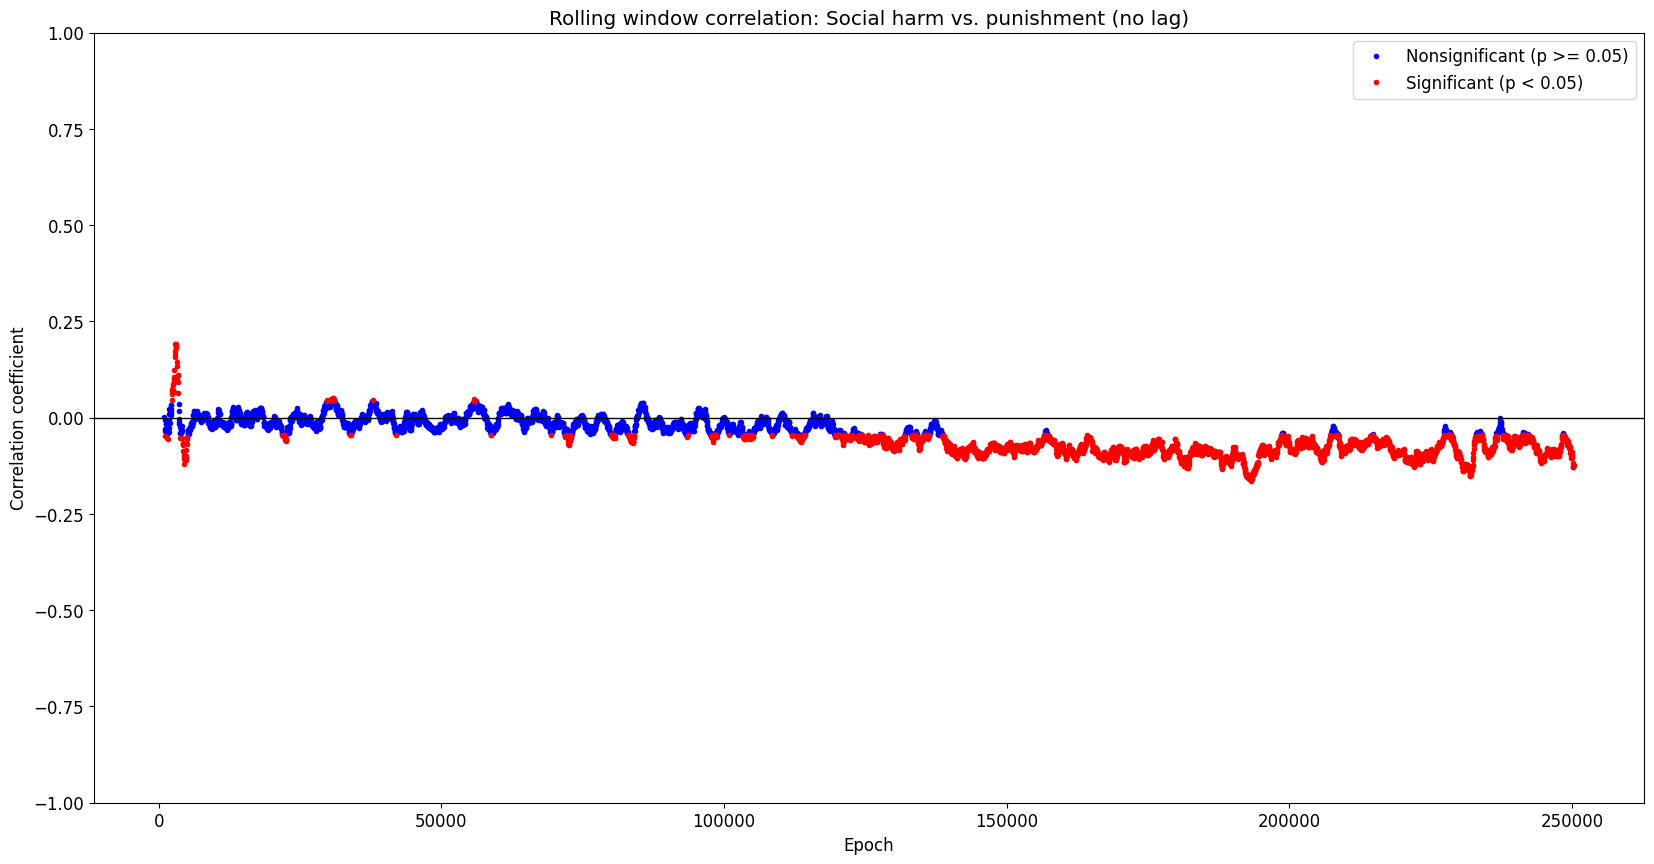

In [18]:
# rolling window: correlation between social harm and punishment (social harm at time T ~ p_T)
# rolling window: correlation between social harm and punishment (social harm at time T ~ p_T)
window_size = 2000
step_size = 40
lag = 1
start_timepoint = 0
smooth_social_harm_window = 1
smooth_punishment_window = 1

correlations = []
p_values = []
window_centers = []

sh_win = social_harm[start_timepoint:].rolling(window=smooth_social_harm_window).mean()
p_win = punishment_levels[start_timepoint:].rolling(window=smooth_punishment_window).mean()

for start in range(0, len(sh_win) - window_size + 1, step_size):
    end = start + window_size
    x_win = p_win[start:end]
    y_win = sh_win[start:end]
    # Only compute correlation if window has varied data
    if np.std(x_win) > 0 and np.std(y_win) > 0:
        corr, pval = pearsonr(x_win, y_win)
    else:
        corr, pval = np.nan, np.nan
    correlations.append(corr)
    p_values.append(pval)
    window_centers.append(start + window_size // 2)

correlations = np.array(correlations)
p_values = np.array(p_values)
window_centers = np.array(window_centers)

# Plotting, red for significant (p < 0.05), blue for nonsignificant
fig, ax = plt.subplots(figsize=(20, 10))

mask_sig = p_values < 0.05
mask_nonsig = ~mask_sig

ax.plot(window_centers[mask_nonsig], correlations[mask_nonsig], 'o', color='blue', label='Nonsignificant (p >= 0.05)', markersize=3)
ax.plot(window_centers[mask_sig], correlations[mask_sig], 'o', color='red', label='Significant (p < 0.05)', markersize=3)

ax.set_xlabel("Epoch")
ax.set_ylabel("Correlation coefficient")
ax.set_title("Rolling window correlation: Social harm vs. punishment (no lag)")
ax.legend()
ax.axhline(0, color='black', linewidth=1)
ax.set_ylim(-1, 1)
# ax.set_xlim(0, 80000)
# ax.set_xticks([])

plt.show()




### punishment at T ~ collective harm change at T + 1

Correlation between first derivative of social harm and punishment: 0.0755, p-value: 0.0000


Text(0, 0.1, 'correlation: 0.0755, p-value: 0.0000')

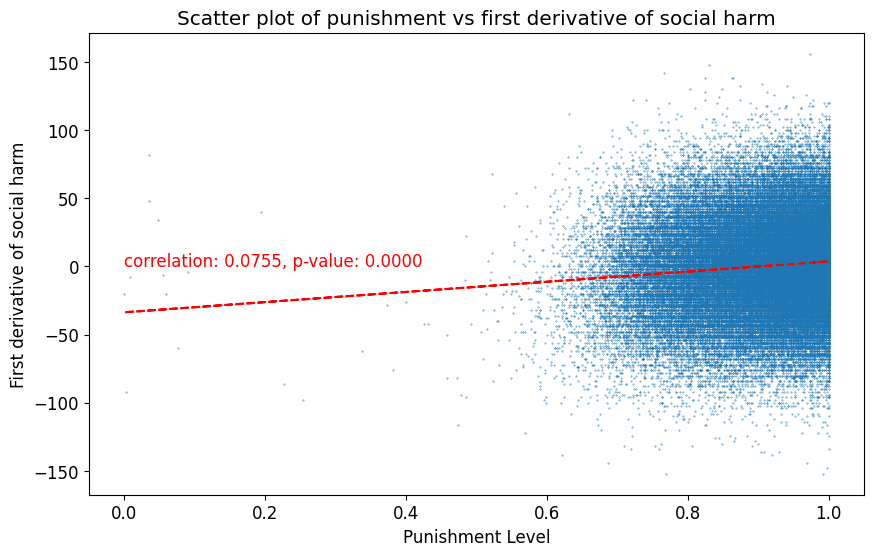

In [38]:
# correlation between first derivative of social harm and punishment (p at time T ~ delta harm_T)
lag = 1
start_timepoint = 300000
# Calculate first derivative of social harm
# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
# social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
social_harm_diff = social_harm[start_timepoint+1:].values - social_harm[start_timepoint:-1].values
social_harm_diff = social_harm_diff[lag-1:]

# Calculate correlation between first derivative of social harm and punishment
correlation, p_value = spearmanr(social_harm_diff, punishment_levels[start_timepoint:][:-lag])
print(f"Correlation between first derivative of social harm and punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(punishment_levels[start_timepoint:][:-lag], social_harm_diff, s=0.1)
plt.xlabel("Punishment Level")
plt.ylabel("First derivative of social harm")
plt.title("Scatter plot of punishment vs first derivative of social harm")
# trendline fitted for the relation
z = np.polyfit(punishment_levels[start_timepoint:][:-lag], social_harm_diff, 1)
p = np.poly1d(z)
plt.plot(punishment_levels[start_timepoint:][:-lag], p(punishment_levels[start_timepoint:][:-lag]), "r--")
plt.text(0, 0.1, f"correlation: {correlation:.4f}, p-value: {p_value:.4f}", color='red')


In [30]:
import statsmodels.api as sm
import numpy as np

# define Δx_{t+1}
dx = social_harm[1:].values - social_harm[:-1].values

# align x_t and s_t to match Δx_{t+1}
x_t = social_harm[:-1].values
s_t = punishment_levels[:-1].values

# Mode switch: 'regression' or 'partial_corr'
mode = 'partial_corr'  # Change to 'partial_corr' for partial correlation

if mode == 'regression':
    # regression: Δx ~ x + s
    X = np.column_stack([x_t, s_t])
    X = sm.add_constant(X)
    model = sm.OLS(dx, X).fit()
    print("Regression: Δx ~ x + s")
    print(model.summary())
    
    X = np.column_stack([s_t])
    X = sm.add_constant(X)
    model_ = sm.OLS(dx, X).fit()
    print("\nRegression: Δx ~ s")
    print(model_.summary())
    
elif mode == 'partial_corr':
    # Partial correlation: Δx with s, controlling for x
    df = pd.DataFrame({'dx': dx, 'x': x_t, 's': s_t})
    partial_corr = pg.partial_corr(data=df, x='dx', y='s', covar='x')
    
    print("Partial correlation: Δx with s, controlling for x")
    print(partial_corr)
    
    # Simple correlation: Δx with s (no control)
    simple_corr = pg.corr(x=dx, y=s_t)
    print("\nSimple correlation: Δx with s")
    print(simple_corr)


Partial correlation: Δx with s, controlling for x
              n         r           CI95%  p-val
pearson  445457 -0.075011  [-0.08, -0.07]    0.0

Simple correlation: Δx with s
              n         r         CI95%         p-val       BF10     power
pearson  445457  0.008819  [0.01, 0.01]  3.960741e-09  6.255e+04  0.999957


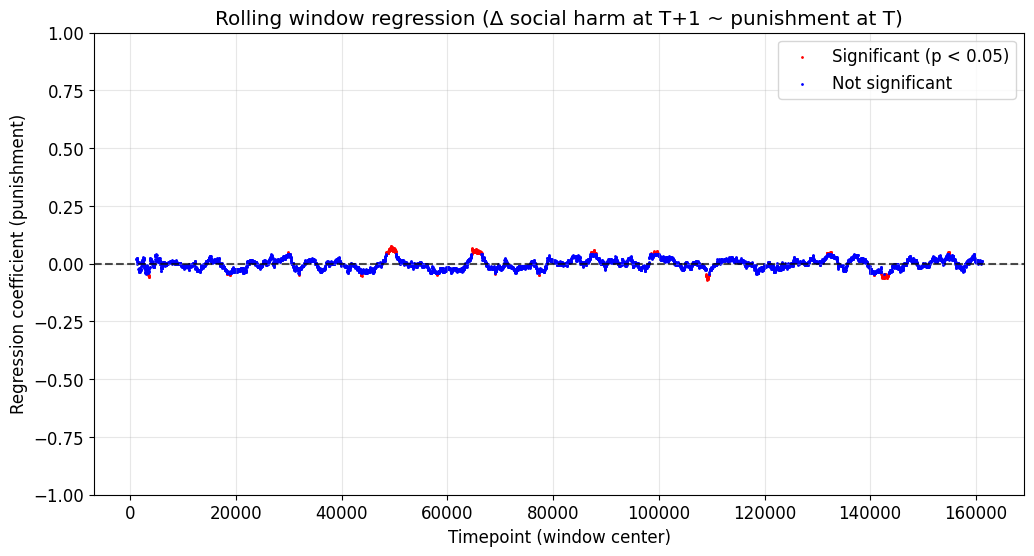

In [119]:
# rolling window: regression Δx_{t+1} ~ s
# Mode switch: 'regression' or 'partial_corr'
mode = 'regression'  # Change to 'partial_corr' for partial correlation

window_size = 2000
step_size = 20
lag = 1
start_timepoint = 0

correlations = []
p_values = []
window_centers = []

smoothing_window_social_harm = 100
smoothing_window_punishment = 100

social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smoothing_window_social_harm).mean())
punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smoothing_window_punishment).mean())

# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
social_harm_diff = social_harm_arr[start_timepoint+lag:] - social_harm_arr[start_timepoint:-lag]
punishment_for_corr = punishment_arr[start_timepoint:][:-lag]
social_harm_for_corr = social_harm_arr[start_timepoint:][:-lag]

s_coefs = []
s_pvalues = []
window_centers = []

for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
    end = start + window_size
    x_win = social_harm_for_corr[start:end]
    s_win = punishment_for_corr[start:end]
    y_win = social_harm_diff[start:end]

    # z-score all variables
    x_win_z = zscore(x_win)
    s_win_z = zscore(s_win)
    y_win_z = zscore(y_win)

    # Check for invalid values (inf or nan) that can occur when variance is zero
    if (np.any(~np.isfinite(y_win_z)) or 
        np.any(~np.isfinite(x_win_z)) or 
        np.any(~np.isfinite(s_win_z))):
        # Skip this window if any variable has invalid values
        s_coefs.append(np.nan)
        s_pvalues.append(np.nan)
        window_centers.append(start + window_size // 2)
        continue

    if mode == 'regression':
        # Prepare regression matrix: Δx_{t+1} ~ s
        X = np.column_stack([s_win_z])
        X = sm.add_constant(X)
        model = sm.OLS(y_win_z, X).fit()
        # Store coefficient and p-value of s (punishment)
        s_coefs.append(model.params[1])
        s_pvalues.append(model.pvalues[1])
    elif mode == 'partial_corr':
        # Partial correlation: Δx_{t+1} with s (no covariates, so it's simple correlation)
        df_win = pd.DataFrame({'y': y_win_z, 's': s_win_z})
        try:
            corr_result = pg.corr(x=df_win['y'], y=df_win['s'])
            s_coefs.append(corr_result['r'].values[0])
            s_pvalues.append(corr_result['p-val'].values[0])
        except:
            s_coefs.append(np.nan)
            s_pvalues.append(np.nan)
    
    window_centers.append(start + window_size // 2)

# Convert to arrays for plotting
s_coefs = np.array(s_coefs)
s_pvalues = np.array(s_pvalues)
window_centers = np.array(window_centers)

# Plot rolling coefficient for punishment (s) with significance
plt.figure(figsize=(12,6))
plt.axhline(0, color='k', linestyle='--', alpha=0.7)
# Significant: red; Not significant: blue
alpha = 0.05
is_significant = s_pvalues < alpha
plt.scatter(window_centers[is_significant], s_coefs[is_significant], color='red', label='Significant (p < 0.05)', s=1)
plt.scatter(window_centers[~is_significant], s_coefs[~is_significant], color='blue', label='Not significant', s=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Regression coefficient (punishment)")
plt.title(f"Rolling window regression (Δ social harm at T+{lag} ~ punishment at T)")
plt.legend()
plt.ylim(-1, 1)
# plt.xticks([])
plt.grid(alpha=0.3)
plt.show()




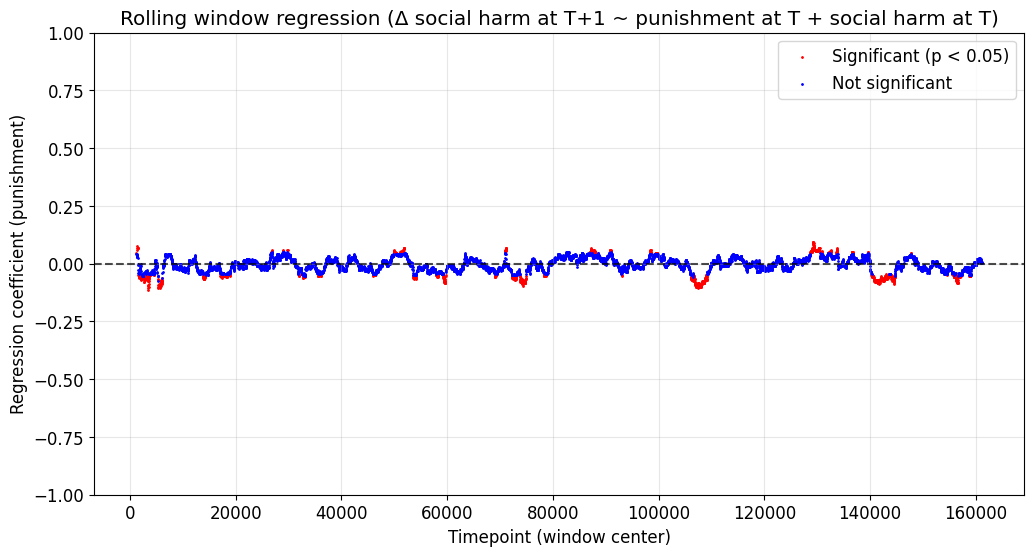

In [123]:
# rolling window: regression Δx_{t+1} ~ x_t + s
# Mode switch: 'regression' or 'partial_corr'
mode = 'regression'  # Change to 'partial_corr' for partial correlation

window_size = 2000
step_size = 20
lag = 1
start_timepoint = 0
smoothing_window_punishment = 200
smoothing_window_social_harm = 200

correlations = []
p_values = []
window_centers = []

social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smoothing_window_social_harm).mean())
punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smoothing_window_punishment).mean())

# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
social_harm_diff = social_harm_arr[start_timepoint+lag:] - social_harm_arr[start_timepoint:-lag]
punishment_for_corr = punishment_arr[start_timepoint:][:-lag]
social_harm_for_corr = social_harm_arr[start_timepoint:][:-lag]

s_coefs = []
s_pvalues = []
window_centers = []

for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
    end = start + window_size
    x_win = social_harm_for_corr[start:end]
    s_win = punishment_for_corr[start:end]
    y_win = social_harm_diff[start:end]

    # z-score all variables
    x_win_z = zscore(x_win)
    s_win_z = zscore(s_win)
    y_win_z = zscore(y_win)

    # Check for invalid values (inf or nan) that can occur when variance is zero
    if (np.any(~np.isfinite(y_win_z)) or 
        np.any(~np.isfinite(x_win_z)) or 
        np.any(~np.isfinite(s_win_z))):
        # Skip this window if any variable has invalid values
        s_coefs.append(np.nan)
        s_pvalues.append(np.nan)
        window_centers.append(start + window_size // 2)
        continue

    if mode == 'regression':
        # Prepare regression matrix: Δx_{t+1} ~ x_t + s
        X = np.column_stack([x_win_z, s_win_z])
        X = sm.add_constant(X)
        model = sm.OLS(y_win_z, X).fit()
        # Store coefficient and p-value of s (punishment)
        s_coefs.append(model.params[2])
        s_pvalues.append(model.pvalues[2])
    elif mode == 'partial_corr':
        # Partial correlation: Δx_{t+1} with s, controlling for x_t
        df_win = pd.DataFrame({'y': y_win_z, 'x': x_win_z, 's': s_win_z})
        try:
            partial_corr_result = pg.partial_corr(data=df_win, x='y', y='s', covar='x')
            s_coefs.append(partial_corr_result['r'].values[0])
            s_pvalues.append(partial_corr_result['p-val'].values[0])
        except:
            s_coefs.append(np.nan)
            s_pvalues.append(np.nan)
    
    window_centers.append(start + window_size // 2)

# Convert to arrays for plotting
s_coefs = np.array(s_coefs)
s_pvalues = np.array(s_pvalues)
window_centers = np.array(window_centers)

# Plot rolling coefficient for punishment (s) with significance
plt.figure(figsize=(12,6))
plt.axhline(0, color='k', linestyle='--', alpha=0.7)
# Significant: red; Not significant: blue
alpha = 0.05
is_significant = s_pvalues < alpha
plt.scatter(window_centers[is_significant], s_coefs[is_significant], color='red', label='Significant (p < 0.05)', s=1)
plt.scatter(window_centers[~is_significant], s_coefs[~is_significant], color='blue', label='Not significant', s=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Regression coefficient (punishment)")
plt.title(f"Rolling window regression (Δ social harm at T+{lag} ~ punishment at T + social harm at T)")
plt.legend()
plt.ylim(-1, 1)
# plt.xticks([])
plt.grid(alpha=0.3)
plt.show()




In [ ]:
df_model = pd.DataFrame({'coef':s_coefs, 'index':np.arange(len(s_coefs))})
model = sm.OLS.from_formula('coef ~ index', data=df_model).fit()
print(model.summary())

# rolling window: correlation between first derivative of social harm and punishment (p at time T ~ delta harm_T)

                            OLS Regression Results                            
Dep. Variable:                   coef   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     1200.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          3.41e-203
Time:                        21:18:06   Log-Likelihood:                 4336.2
No. Observations:                1856   AIC:                            -8668.
Df Residuals:                    1854   BIC:                            -8657.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.001      1.844      0.0

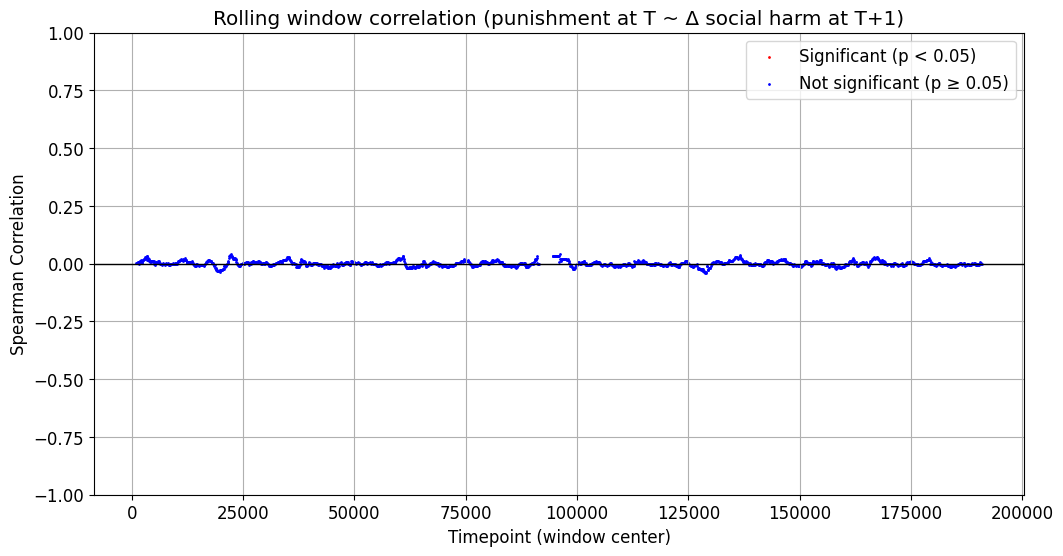

In [174]:
# rolling window: correlation between first derivative of social harm and punishment (p at time T ~ delta harm_T)
window_size = 2000
step_size = 100
lag = 1
start_timepoint = 0

correlations = []
p_values = []
window_centers = []

# social_harm_diff = np.diff(social_harm[start_timepoint:], n=lag)
social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
punishment_for_corr = punishment_levels[start_timepoint:][:-lag]

for start in range(0, len(social_harm_diff) - window_size + 1, step_size):
    end = start + window_size
    x_win = punishment_for_corr[start:end]
    y_win = social_harm_diff[start:end]
    # Only compute correlation if window has varied data
    if np.std(x_win) > 0 and np.std(y_win) > 0:
        corr, pval = spearmanr(x_win, y_win)
    else:
        corr, pval = np.nan, np.nan
    correlations.append(corr)
    p_values.append(pval)
    window_centers.append(start + window_size // 2)

# plt.figure(figsize=(12,6))
# plt.plot(window_centers, correlations, marker="o")
# plt.xlabel("Timepoint (window center)")
# plt.ylabel("Spearman Correlation")
# plt.title("Rolling window correlation (punishment ~ Δ social harm)")
# plt.grid()
# plt.show()
# Redo plot as scatter, red for significant, blue for not significant
plt.figure(figsize=(12,6))
correlations = np.array(correlations)
p_values = np.array(p_values)
window_centers = np.array(window_centers)

alpha = 0.05
is_significant = p_values < alpha

# Plot significant (red) and not significant (blue) points
plt.scatter(window_centers[is_significant], correlations[is_significant], s=1, color='red', label="Significant (p < 0.05)")
plt.scatter(window_centers[~is_significant], correlations[~is_significant], s=1, color='blue', label="Not significant (p ≥ 0.05)")

plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Spearman Correlation")
plt.title(f"Rolling window correlation (punishment at T ~ Δ social harm at T+{lag})")
plt.legend()
# plt.xticks([])
plt.ylim(-1, 1)
plt.grid()
plt.show()



### collective harm at T ~ punishment delta at T + 1

Correlation between social harm and first derivative of punishment: 0.0237, p-value: 0.0000


Text(0, 0.0, 'correlation: 0.0237, p-value: 0.0000')

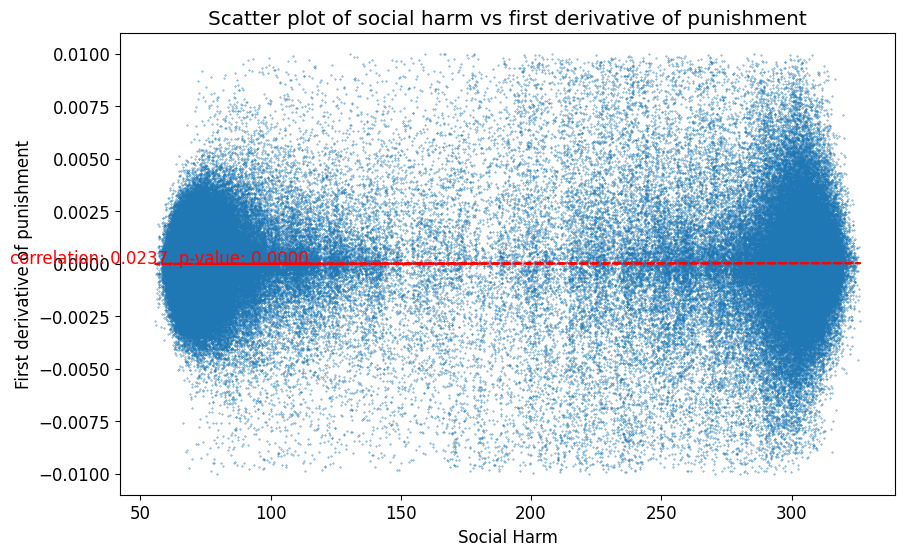

In [31]:
# correlation between social harm and the first derivative of punishment (social harm at time T ~ delta p_T)
lag = 1
start_timepoint = 10000
# Calculate first derivative of punishment
# punishment_diff = np.diff(punishment_levels[start_timepoint:], n=lag)
punishment_diff = punishment_levels[start_timepoint+lag:].values - punishment_levels[start_timepoint:-lag].values

# Calculate correlation between social harm and first derivative of punishment
correlation, p_value = spearmanr(social_harm[start_timepoint:][:-lag], punishment_diff)
print(f"Correlation between social harm and first derivative of punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(social_harm[start_timepoint:][:-lag], punishment_diff, s=0.1)
plt.xlabel("Social Harm")
plt.ylabel("First derivative of punishment")
plt.title("Scatter plot of social harm vs first derivative of punishment")
# trendline fitted for the relation
z = np.polyfit(social_harm[start_timepoint:][:-lag], punishment_diff, 1)
p = np.poly1d(z)
plt.plot(social_harm[start_timepoint:][:-lag], p(social_harm[start_timepoint:][:-lag]), "r--")
plt.text(0, 0.0, f"correlation: {correlation:.4f}, p-value: {p_value:.4f}", color='red')

In [ ]:
# rolling window: correlation between social harm and the first derivative of punishment (social harm at time T ~ delta p_T)

# rolling window: correlation between social harm and the first derivative of punishment (social harm at time T ~ delta p_T)
import numpy as np
from scipy.stats import spearmanr

window_size = 3000
step_size = 20
start_timepoint = 0
lag = 1

social_harm_arr = np.array(social_harm[start_timepoint:])
punishment_arr = np.array(punishment_levels[start_timepoint:])

social_harm_windows = []
correlations = []
p_values = []
window_centers = []
var_social_harm = []
var_punishment = []

for start in range(0, len(social_harm_arr) - window_size - lag + 1, step_size):
    stop = start + window_size
    # x: social harm (T), y: change in punishment (T+lag - T)
    x = social_harm_arr[start:stop-lag]
    # y = np.diff(punishment_arr[start:(stop+lag)], n=lag)
    y = punishment_arr[start+lag:stop] - punishment_arr[start:stop-lag]

    var_social_harm.append(np.var(x))
    var_punishment.append(np.var(y))

    # z-score x and y
    x = zscore(x)
    y = zscore(y)

    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        corr = np.nan
        p = np.nan
    else:
        corr, p = spearmanr(x, y)
    correlations.append(corr)
    p_values.append(p)
    window_centers.append(start + window_size//2)

correlations = np.array(correlations)
p_values = np.array(p_values)
window_centers = np.array(window_centers)

alpha = 0.05
is_significant = p_values < alpha

plt.figure(figsize=(10,6))
plt.scatter(window_centers[is_significant], correlations[is_significant], s=1, color='red', label="Significant (p < 0.05)")
plt.scatter(window_centers[~is_significant], correlations[~is_significant], s=1, color='blue', label="Not significant (p ≥ 0.05)")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Spearman Correlation")
plt.title(f"Rolling window correlation (social harm at T ~ Δ punishment at T+{lag})")
plt.legend()
plt.ylim(-1, 1)
plt.grid()
plt.show()
# plot variance of social harm and punishment in subplots (2, 1)
fig, axs = plt.subplots(2, 1, figsize=(10,6))
axs[0].plot(window_centers, var_social_harm, label='social harm')
axs[0].legend()
# axs[0].set_ylim(min=0)
axs[0].set_ylabel("Variance")
axs[0].set_title("Variance of social harm over time")
axs[1].plot(window_centers, var_punishment, label='punishment')
axs[1].legend()
axs[1].set_xlabel("Timepoint (window center)")
axs[1].set_ylabel("Variance")
plt.tight_layout()
plt.title("Variance of social harm and punishment over time")









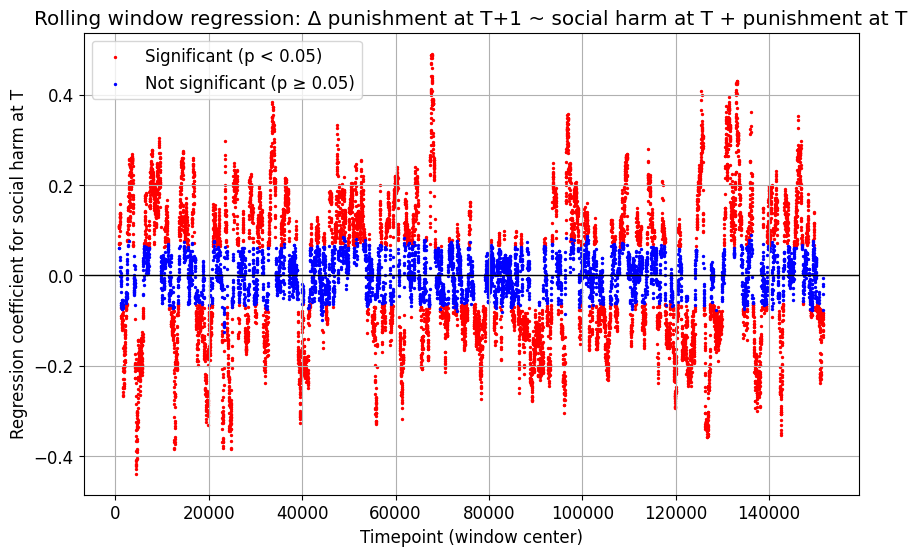

In [125]:
# Mode switch: 'regression' or 'partial_corr'
mode = 'regression'  # Change to 'partial_corr' for partial correlation

import statsmodels.api as sm

window_size = 1000
step_size = 10
lag = 1
smoothing_window_social_harm = 200
smoothing_window_punishment = 200

regression_coefs = []
regression_pvals = []
window_centers = []

y_label = f"Δ punishment at T+{lag}"
x_label = "social_harm at T"

social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smoothing_window_social_harm).mean())
punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smoothing_window_punishment).mean())

for start in range(0, len(social_harm_arr) - window_size - lag + 1, step_size):
    stop = start + window_size
    # The outcome: difference in punishment at T+lag vs T
    y = punishment_arr[start+lag:stop] - punishment_arr[start:stop-lag]
    # The regressors: social harm at T, punishment at T
    x1 = social_harm_arr[start:stop-lag]
    x2 = punishment_arr[start:stop-lag]  

    # z-score
    y = zscore(y)
    x1 = zscore(x1)
    x2 = zscore(x2)
   
    # Check for invalid values (inf or nan) or zero variance that can occur when variance is zero
    if (np.any(~np.isfinite(y)) or np.any(~np.isfinite(x1)) or np.any(~np.isfinite(x2)) or
        np.var(y) == 0 or np.var(x1) == 0 or np.var(x2) == 0):
        regression_coefs.append(np.nan)
        regression_pvals.append(np.nan)
    else:
        if mode == 'regression':
            X = np.column_stack([x1, x2])
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            # coef for "social_harm at T" is at index 1 (const, x1, x2)
            regression_coefs.append(model.params[1])
            regression_pvals.append(model.pvalues[1])
        elif mode == 'partial_corr':
            # Partial correlation: y (Δ punishment) with x1 (social harm), controlling for x2 (punishment)
            df_win = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})
            try:
                partial_corr_result = pg.partial_corr(data=df_win, x='y', y='x1', covar='x2')
                regression_coefs.append(partial_corr_result['r'].values[0])
                regression_pvals.append(partial_corr_result['p-val'].values[0])
            except:
                regression_coefs.append(np.nan)
                regression_pvals.append(np.nan)
 

    window_centers.append(start + window_size//2)

regression_coefs = np.array(regression_coefs)
regression_pvals = np.array(regression_pvals)
window_centers = np.array(window_centers)

alpha = 0.05
is_significant = regression_pvals < alpha

plt.figure(figsize=(10,6))
plt.scatter(window_centers[is_significant], regression_coefs[is_significant], s=2, color='red', label="Significant (p < 0.05)")
plt.scatter(window_centers[~is_significant], regression_coefs[~is_significant], s=2, color='blue', label="Not significant (p ≥ 0.05)")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Timepoint (window center)")
if mode == 'regression':
    plt.ylabel("Regression coefficient for social harm at T")
    plt.title(f"Rolling window regression: Δ punishment at T+{lag} ~ social harm at T + punishment at T")
elif mode == 'partial_corr':
    plt.ylabel("Partial correlation coefficient (social harm at T | punishment at T)")
    plt.title(f"Rolling window partial correlation: Δ punishment at T+{lag} with social harm at T (controlling for punishment at T)")
plt.legend()
# plt.ylim(np.nanmin(regression_coefs)-.1, np.nanmax(regression_coefs)+.1)
plt.grid()
plt.show()

/var/folders/tc/dgrl84qj2gl3fw9vl9x4t1f40000gn/T/ipykernel_44362/2224108487.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x2 = zscore(x2)
/var/folders/tc/dgrl84qj2gl3fw9vl9x4t1f40000gn/T/ipykernel_44362/2224108487.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x2 = zscore(x2)
/var/folders/tc/dgrl84qj2gl3fw9vl9x4t1f40000gn/T/ipykernel_44362/2224108487.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x2 = zscore(x2)
/var/folders/tc/dgrl84qj2gl3fw9vl9x4t1f40000gn/T/ipykernel_44362/2224108487.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This 

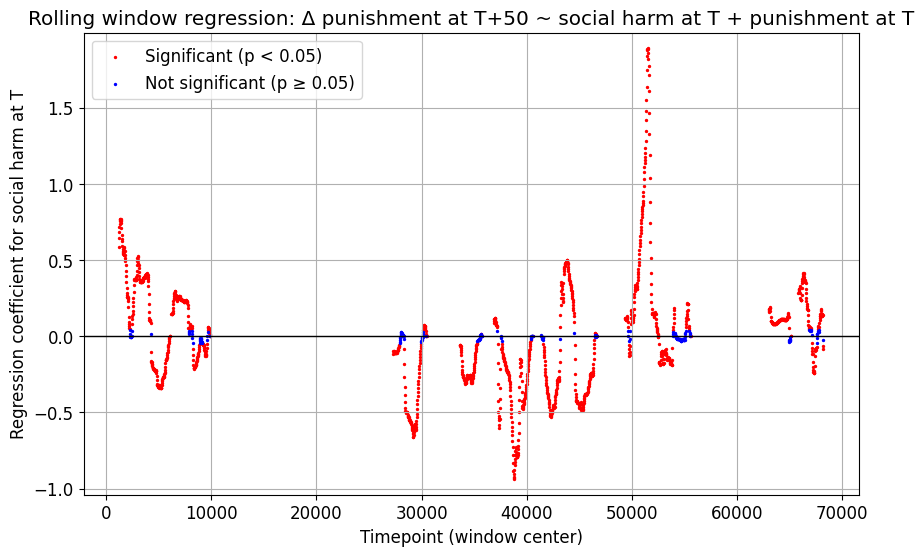

In [107]:
import statsmodels.api as sm

window_size = 2000
step_size = 20
lag = 50

regression_coefs = []
regression_pvals = []
window_centers = []

y_label = f"Δ punishment at T+{lag}"
x_label = "social_harm at T"

for start in range(0, len(social_harm_arr) - window_size - lag + 1, step_size):
    stop = start + window_size
    # The outcome: difference in punishment at T+lag vs T
    y = punishment_arr[start+lag:stop] - punishment_arr[start:stop-lag]
    # The regressors: social harm at T, punishment at T
    x1 = social_harm_arr[start:stop-lag]
    x2 = punishment_arr[start:stop-lag]  

    # z-score
    y = zscore(y)
    x1 = zscore(x1)
    x2 = zscore(x2)
   
    # Check for invalid values (inf or nan) or zero variance that can occur when variance is zero
    if (np.any(~np.isfinite(y)) or np.any(~np.isfinite(x1)) or np.any(~np.isfinite(x2)) or
        np.var(y) == 0 or np.var(x1) == 0 or np.var(x2) == 0):
        regression_coefs.append(np.nan)
        regression_pvals.append(np.nan)
    else:
        X = np.column_stack([x1, x2])
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        # coef for "social_harm at T" is at index 1 (const, x1, x2)
        regression_coefs.append(model.params[1])
        regression_pvals.append(model.pvalues[1])
 

    window_centers.append(start + window_size//2)

regression_coefs = np.array(regression_coefs)
regression_pvals = np.array(regression_pvals)
window_centers = np.array(window_centers)

alpha = 0.05
is_significant = regression_pvals < alpha

plt.figure(figsize=(10,6))
plt.scatter(window_centers[is_significant], regression_coefs[is_significant], s=2, color='red', label="Significant (p < 0.05)")
plt.scatter(window_centers[~is_significant], regression_coefs[~is_significant], s=2, color='blue', label="Not significant (p ≥ 0.05)")
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Regression coefficient for social harm at T")
plt.title(f"Rolling window regression: Δ punishment at T+{lag} ~ social harm at T + punishment at T")
plt.legend()
plt.ylim(np.nanmin(regression_coefs)-.1, np.nanmax(regression_coefs)+.1)
plt.grid()
plt.show()


### delta collective harm ~ delta punishment level

383345
383345
383344
Correlation between first derivative of social harm and first derivative of punishment: 0.0598, p-value: 0.0000


Text(-22, 0.75, 'correlation: 0.0598, p-value: 0.0000')

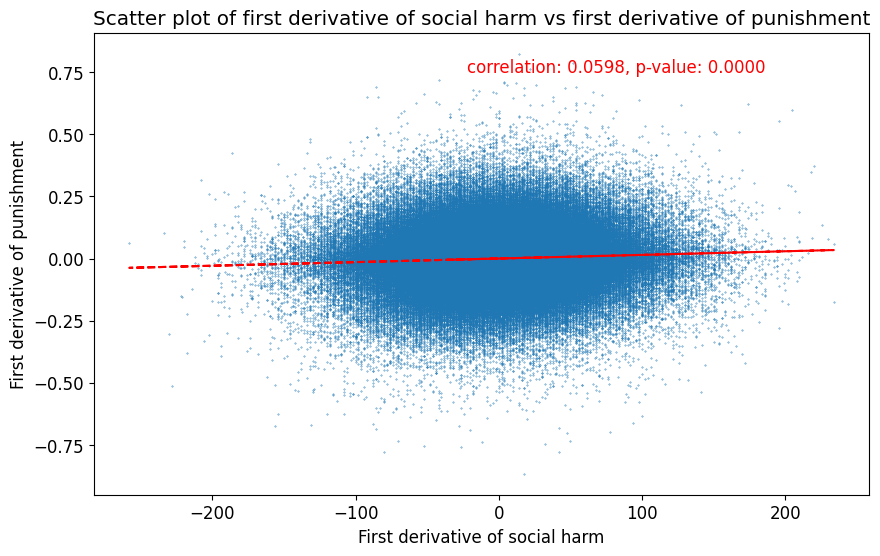

In [28]:
# correlation between first derivative of social harm at T + 1 and the first derivative of punishment at T
lag = 1
start_timepoint = 10000


# social_harm_diff = social_harm[start_timepoint+lag:].values - social_harm[start_timepoint:-lag].values
# social_harm_diff = social_harm_diff[lag:]
# punishment_diff = punishment_levels[start_timepoint+lag:].values - punishment_levels[start_timepoint:-lag].values
# punishment_diff = punishment_diff[:-lag]
social_harm_diff = social_harm[start_timepoint+1:].values - social_harm[start_timepoint:-1].values
print(len(social_harm_diff))
social_harm_diff = social_harm_diff[lag:]
punishment_diff = punishment_levels[start_timepoint+1:].values - punishment_levels[start_timepoint:-1].values
print(len(punishment_diff))
len_ = len(punishment_diff)
punishment_diff = punishment_diff[:len_-lag]
print(len(punishment_diff))
correlation, p_value = pearsonr(social_harm_diff, punishment_diff)
print(f"Correlation between first derivative of social harm and first derivative of punishment: {correlation:.4f}, p-value: {p_value:.4f}")

# scatter plot
plt.scatter(social_harm_diff, punishment_diff, s=0.1)
plt.xlabel("First derivative of social harm")
plt.ylabel("First derivative of punishment")
plt.title("Scatter plot of first derivative of social harm vs first derivative of punishment")
# trendline fitted for the relation
z = np.polyfit(social_harm_diff, punishment_diff, 1)
p = np.poly1d(z)
plt.plot(social_harm_diff, p(social_harm_diff), "r--")
plt.text(-22, 0.75, f"correlation: {correlation:.4f}, p-value: {p_value:.4f}", color='red')
# plt.tight_layout()



In [11]:
# define Δx_{t+1}
start_timepoint = 250000
social_harm_ = social_harm[start_timepoint:]
punishment_ = punishment_levels[start_timepoint:]
dx = social_harm_[1:].values - social_harm_[:-1].values
dx = dx[1:]

# align x_t and s_t to match Δx_{t+1}
x_t = social_harm_[1:-1].values
s_t = punishment_[:-1].values
ds = s_t[1:] - s_t[:-1]


# regression: Δx+1 ~ x+1 + Δs
X = np.column_stack([x_t, ds])
X = sm.add_constant(X)

model = sm.OLS(dx, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                 1.252e+05
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:39:56   Log-Likelihood:            -1.4991e+06
No. Observations:              549998   AIC:                         2.998e+06
Df Residuals:                  549995   BIC:                         2.998e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9852      0.006    308.758      0.0

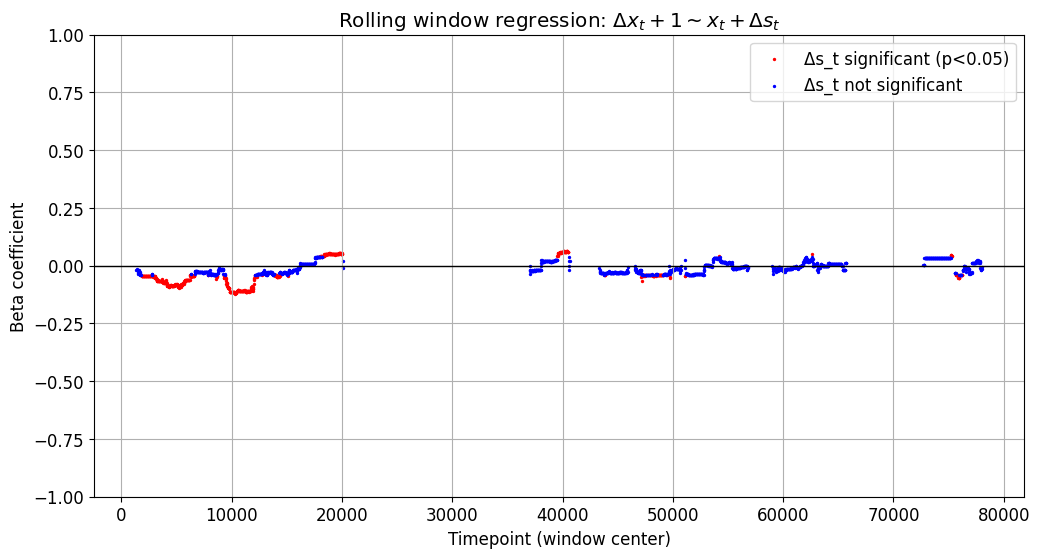

In [110]:
# rolling window: regression Δx_{t+1} ~ x_t + Δs_t

import statsmodels.api as sm

from scipy.stats import zscore

window_size = 2500
step_size = 20
start_timepoint = 0
smoothing_window_social_harm = 100
smoothing_window_punishment = 100
# Prepare the series
social_harm_arr = np.array(social_harm[start_timepoint:].rolling(window=smoothing_window_social_harm).mean())
punishment_arr = np.array(punishment_levels[start_timepoint:].rolling(window=smoothing_window_punishment).mean())

dx = social_harm_arr[1:] - social_harm_arr[:-1]
dx = dx[1:]
xvals = social_harm_arr[1:-1]
svals = punishment_arr[:-1]
ds = svals[1:] - svals[:-1]


dx = dx[:]
x_t = xvals[:]
ds_t = ds[:]

n_points = len(x_t)
rolling_coefs = []
rolling_pvalues = []
window_centers = []

for start in range(0, n_points - window_size + 1, step_size):
    end = start + window_size

    # Prepare variables for regression in the window
    y_win = dx[start:end]
    x_win = x_t[start:end]
    ds_win = ds_t[start:end]
    
    # z-score all variables
    y_win_z = zscore(y_win)
    x_win_z = zscore(x_win)
    ds_win_z = zscore(ds_win)

    # Check for invalid values (inf or nan) that can occur when variance is zero
    if (np.any(~np.isfinite(y_win_z)) or 
        np.any(~np.isfinite(x_win_z)) or 
        np.any(~np.isfinite(ds_win_z))):
        # Skip this window if any variable has invalid values
        rolling_coefs.append(np.nan)
        rolling_pvalues.append(np.nan)
        window_centers.append(start + window_size // 2)
        continue

    # Design matrix: x_t, Δs_t (with constant intercept)
    X = np.column_stack([x_win_z, ds_win_z])
    X = sm.add_constant(X)
    model = sm.OLS(y_win_z, X).fit()
    
    rolling_coefs.append(model.params[2])        # coefficients [x_t, Δs_t]
    rolling_pvalues.append(model.pvalues[2])     # p-values [x_t, Δs_t]
    window_centers.append(start + window_size // 2)

rolling_coefs = np.array(rolling_coefs)     # shape: [windows, 2]
rolling_pvalues = np.array(rolling_pvalues) # shape: [windows, 2]
window_centers = np.array(window_centers)

# Plot, marking statistically significant coefficients as in prior code
alpha = 0.05
# Filter out nan values for plotting
valid_mask = np.isfinite(rolling_coefs) & np.isfinite(rolling_pvalues)
is_significant_ds = (rolling_pvalues < alpha) & valid_mask

plt.figure(figsize=(12,6))
plt.scatter(window_centers[is_significant_ds], rolling_coefs[is_significant_ds], s=2, color='red', label="Δs_t significant (p<0.05)")
plt.scatter(window_centers[valid_mask & ~is_significant_ds], rolling_coefs[valid_mask & ~is_significant_ds], s=2, color='blue', label="Δs_t not significant")
plt.axhline(0, color='black', linewidth=1)
plt.ylim(-1, 1)
plt.xlabel("Timepoint (window center)")
plt.ylabel("Beta coefficient")
plt.title(r"Rolling window regression: $\Delta x_t+1 \sim x_t + \Delta s_t$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# instead of looking the collective level metrics, we look at the individual voting behaviors and the harm they received


In [22]:
# calculate the correlation between the encounters of entity e at time t and the change of punishment at time t+1

import numpy as np
import pandas as pd

# Load entity E encounter data and punishment level data
# Assume the encounter data is in a CSV with a 'Value' column, one value per epoch
entity_e_encounters = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Mean_mean_e_encounters_data.csv'
)['Value']

punishment_levels = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Global_average_punishment_level_data.csv'
)['Value']

# Calculate the change in punishment at t+1
punishment_diff = punishment_levels.values[1:] - punishment_levels.values[:-1]
punishment_diff = punishment_diff[:1000]

# Truncate to the same length
min_len = min(len(entity_e_encounters)-1, len(punishment_diff))
entity_e_encounters = entity_e_encounters[:min_len]
punishment_diff = punishment_diff[:min_len]

# Calculate correlation
correlation, p_value = pearsonr(entity_e_encounters, punishment_diff)
print(f"Correlation between mean entity E encounters at time t and change of punishment at time t+1: {correlation:.4f}, p-value: {p_value:.4f}")


Correlation between mean entity E encounters at time t and change of punishment at time t+1: -0.0335, p-value: 0.2903


Correlation between reward at time t and change of punishment at time t+1: 0.0453


/var/folders/tc/dgrl84qj2gl3fw9vl9x4t1f40000gn/T/ipykernel_1207/1356432352.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x_win[mask], y_win[mask])


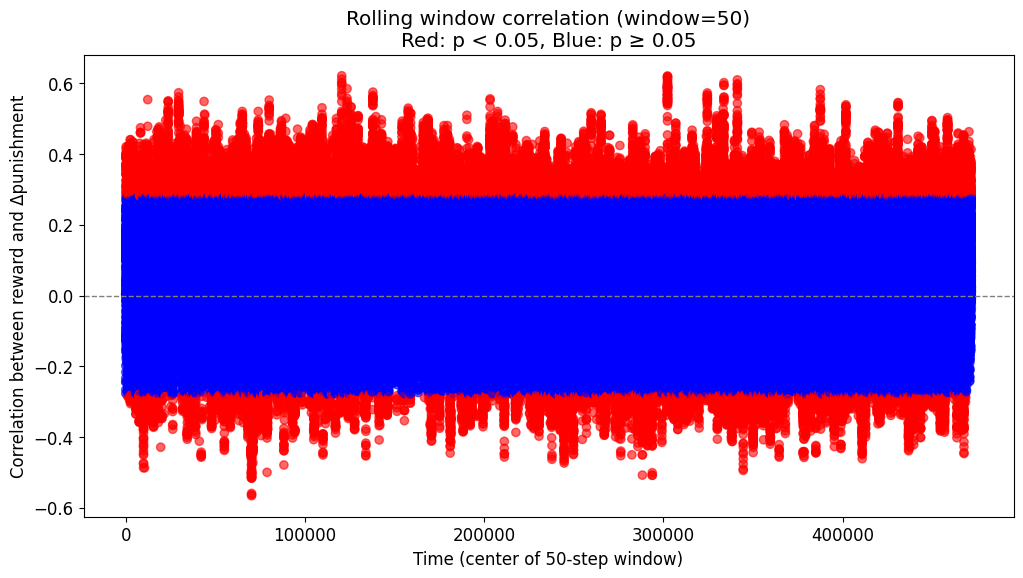

In [24]:
# calculate the correlation between the reward at time t and the change of punishment at time t+1
import numpy as np
import pandas as pd

# Load reward and punishment data
reward_series = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Mean_mean_individual_score_data.csv'
)['Value']

punishment_levels = pd.read_csv(
    'res/runs_Nov14/epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251114-200030/Global_average_punishment_level_data.csv'
)['Value']


# Align lengths after rolling
min_len = min(len(reward_series)-1, len(punishment_levels)-1)
reward_series = reward_series[:min_len]
punishment_levels = punishment_levels[:min_len]

# Calculate the change in punishment at t+1
punishment_diff = punishment_levels.values[1:] - punishment_levels.values[:-1]
reward_series_aligned = reward_series.values[:-1]  # reward at time t

# Truncate to same length
min_len2 = min(len(reward_series_aligned), len(punishment_diff))
reward_series_aligned = reward_series_aligned[:min_len2]
punishment_diff = punishment_diff[:min_len2]

# Calculate correlation
correlation = np.corrcoef(reward_series_aligned, punishment_diff)[0, 1]
print(f"Correlation between reward at time t and change of punishment at time t+1: {correlation:.4f}")

window_size = 50
# For plotting, align the x-axis to the center of each window
corrs, pvals, _ = rolling_window_correlation(reward_series_aligned, punishment_diff, window_size)

x = np.arange(len(corrs)) + window_size // 2

plt.figure(figsize=(12,6))
# Color by p-value: red if p < 0.05, blue otherwise
colors = np.where(pvals < 0.05, 'red', 'blue')
plt.scatter(x, corrs, c=colors, alpha=0.6, label='Rolling correlation')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f"Time (center of {window_size}-step window)")
plt.ylabel("Correlation between reward and Δpunishment")
plt.title(f"Rolling window correlation (window={window_size})\nRed: p < 0.05, Blue: p ≥ 0.05")
plt.show()


Correlation between punishment at time t and change in reward at t+1: 0.0467


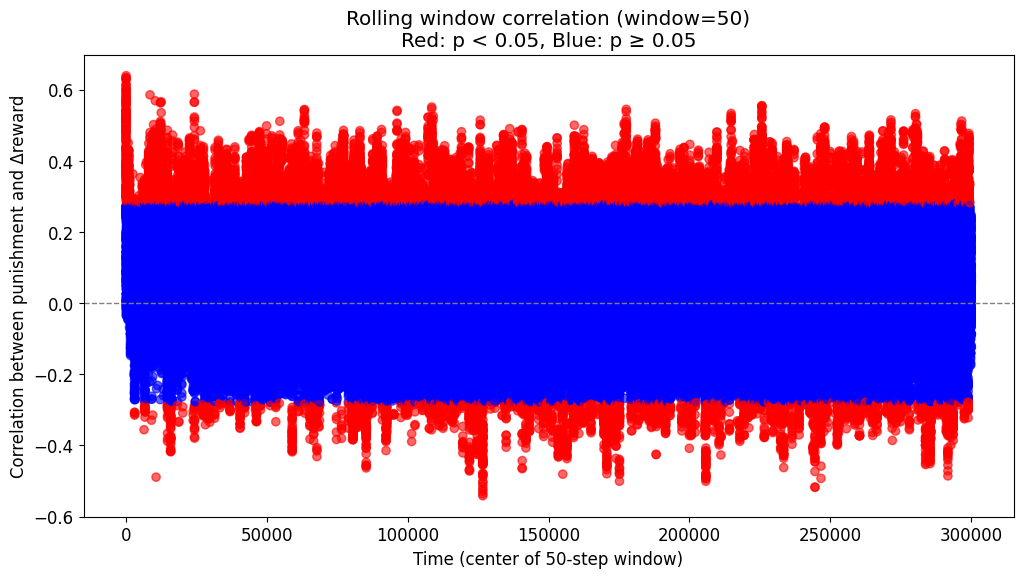

In [114]:
# calculate the correlation between the punishment at time t and the change of reward at time t+1

import numpy as np
import pandas as pd

# Load punishment levels and rewards
punishment_levels = pd.read_csv('res/runs_p48_a2_deterministic/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__2agents_20250923-143956/Global_average_punishment_level_data.csv')['Value']
# punishment_levels = punishment_levels.rolling(window=2000).mean()
# punishment_levels = punishment_levels.dropna()
# For reward, we need a time series matching the epochs of punishment_levels
# we will use the same reward time series as above
reward_series = pd.read_csv('res/runs_p48_a2_deterministic/collective_harm_state_punishment_respawn_0.005_vision_4_map_10_composite_views_False_multi_env_True__2agents_20250923-143956/Mean_mean_individual_score_data.csv')['Value']
# reward_series = reward_series.rolling(window=2000).mean()
# reward_series = reward_series.dropna()


# Calculate the change in reward at t+1

reward_diff = reward_series.values[2:] - reward_series.values[:-2]

# Truncate to the same length
min_len = min(len(punishment_levels), len(reward_diff))
punishment_levels = punishment_levels[:min_len]
reward_diff = reward_diff[:min_len]

# Calculate correlation
correlation = np.corrcoef(punishment_levels, reward_diff)[0, 1]
print(f"Correlation between punishment at time t and change in reward at t+1: {correlation:.4f}")


window_size = 50
# For plotting, align the x-axis to the center of each window
corrs, pvals, prop = rolling_window_correlation(punishment_levels, reward_diff, window_size)

x = np.arange(len(corrs)) + window_size // 2

plt.figure(figsize=(12,6))
# Color by p-value: red if p < 0.05, blue otherwise
colors = np.where(pvals < 0.05, 'red', 'blue')
# red if -1, blue if 1, otherwise gray
# colors = np.where(prop == -1, 'red', np.where(prop == 1, 'blue', 'gray'))
plt.scatter(x, corrs, c=colors, alpha=0.6, label='Rolling correlation')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f"Time (center of {window_size}-step window)")
plt.ylabel("Correlation between punishment and Δreward")
plt.title(f"Rolling window correlation (window={window_size})\nRed: p < 0.05, Blue: p ≥ 0.05")
plt.show()



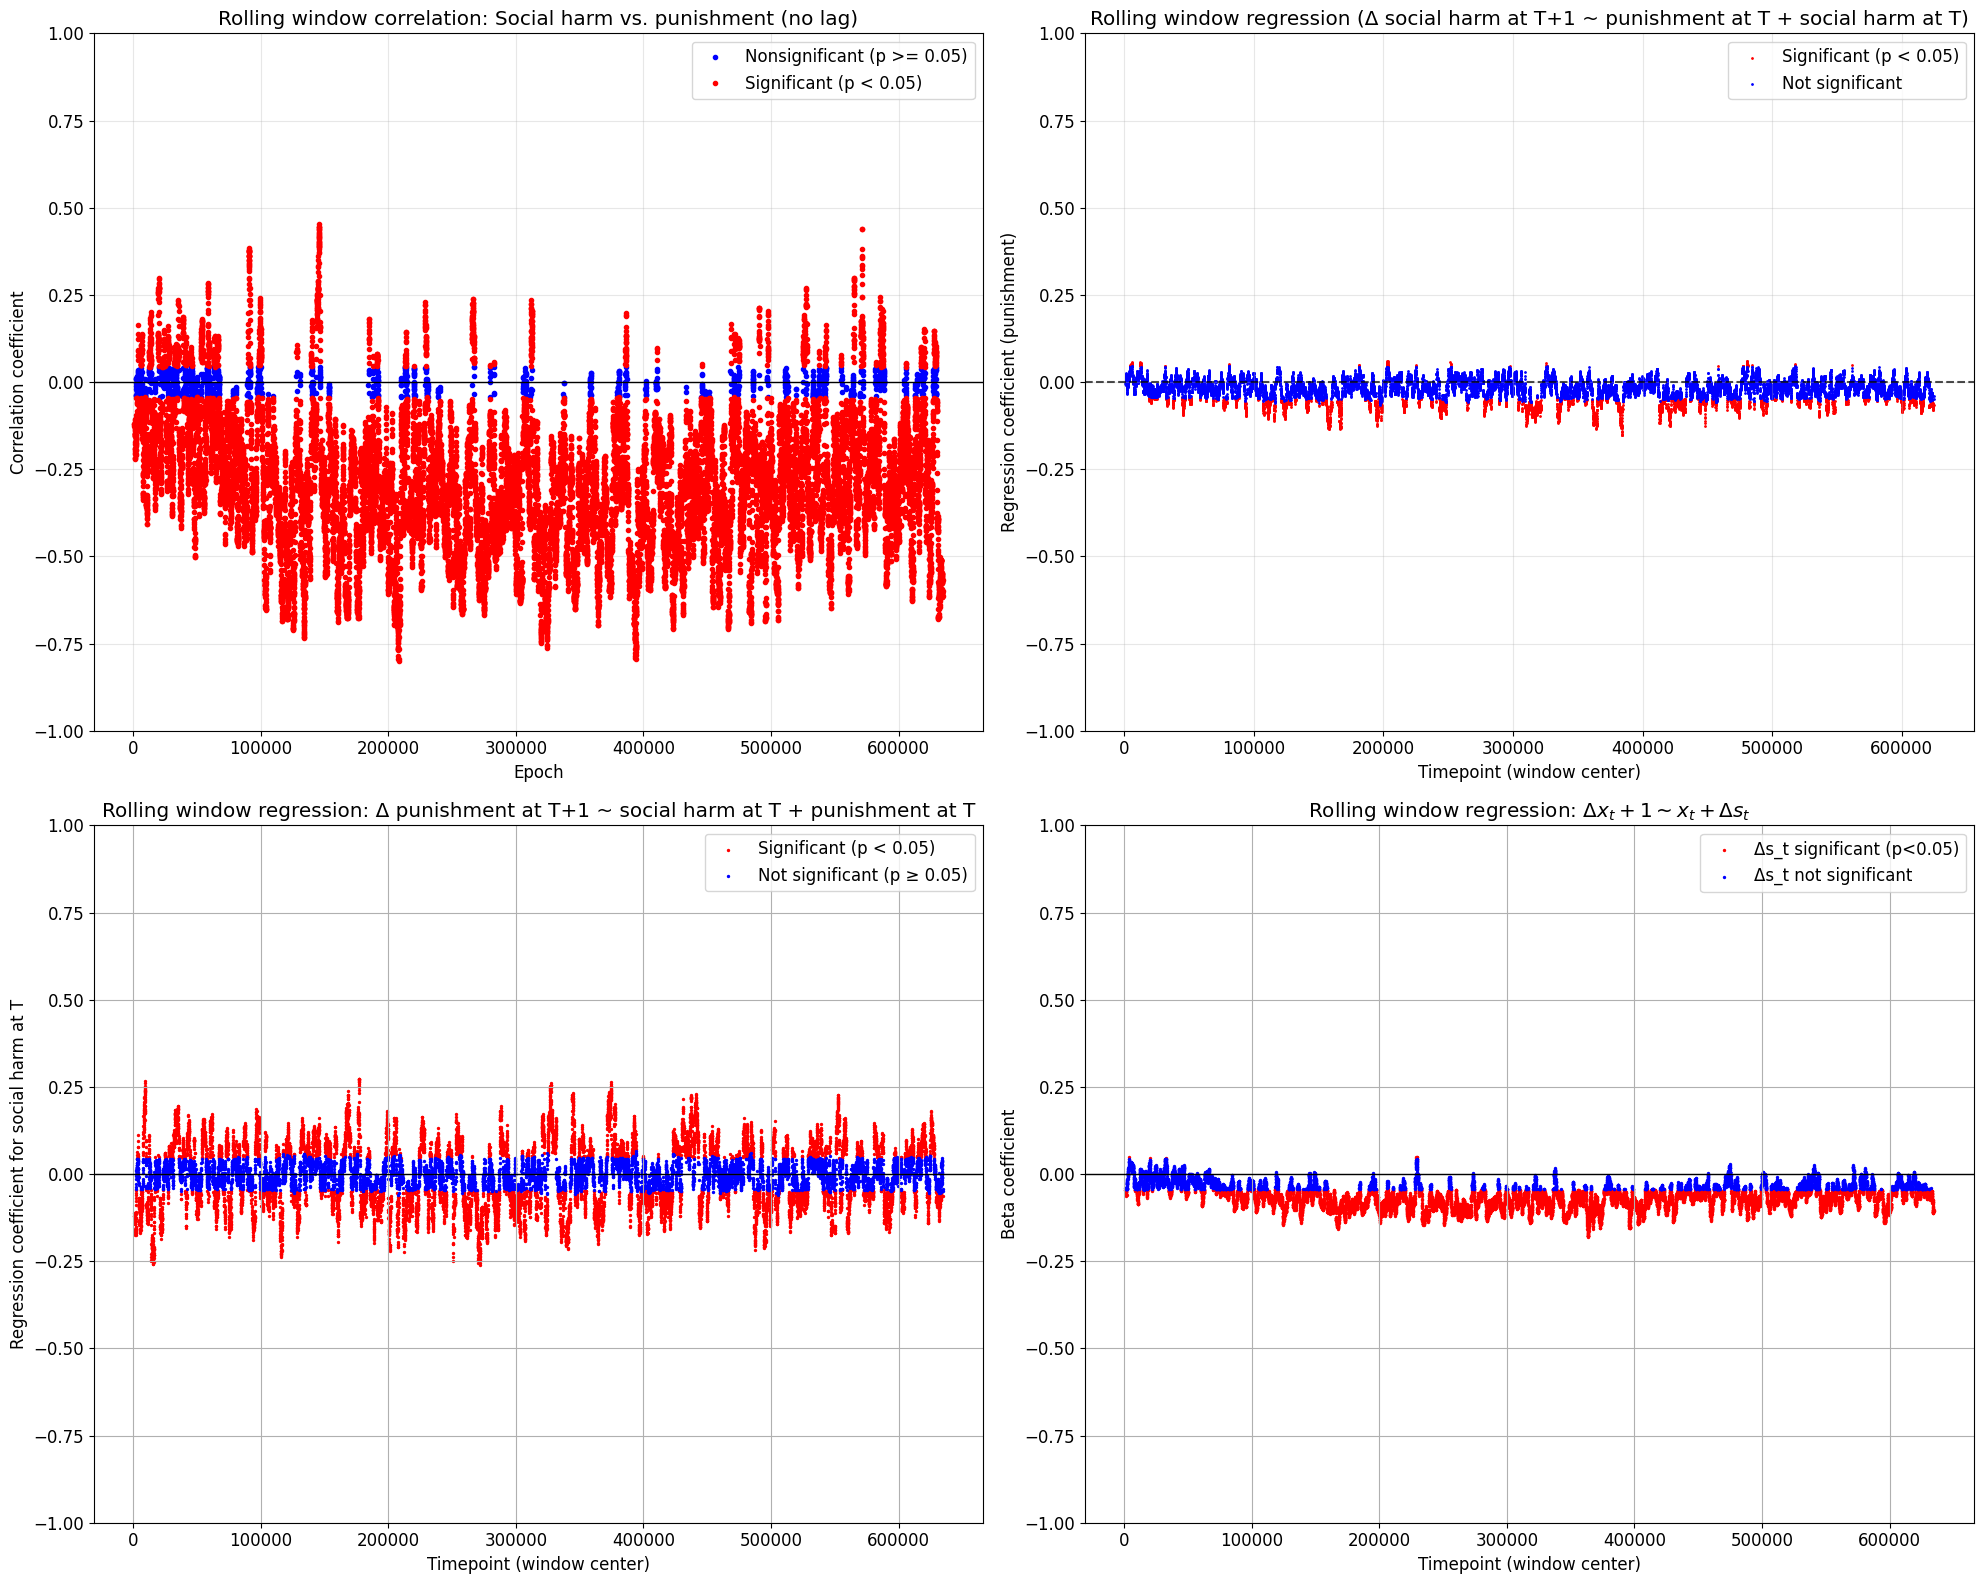

In [35]:
system_analysis(f, 100, 100, 2000, 25, 1, 10000)

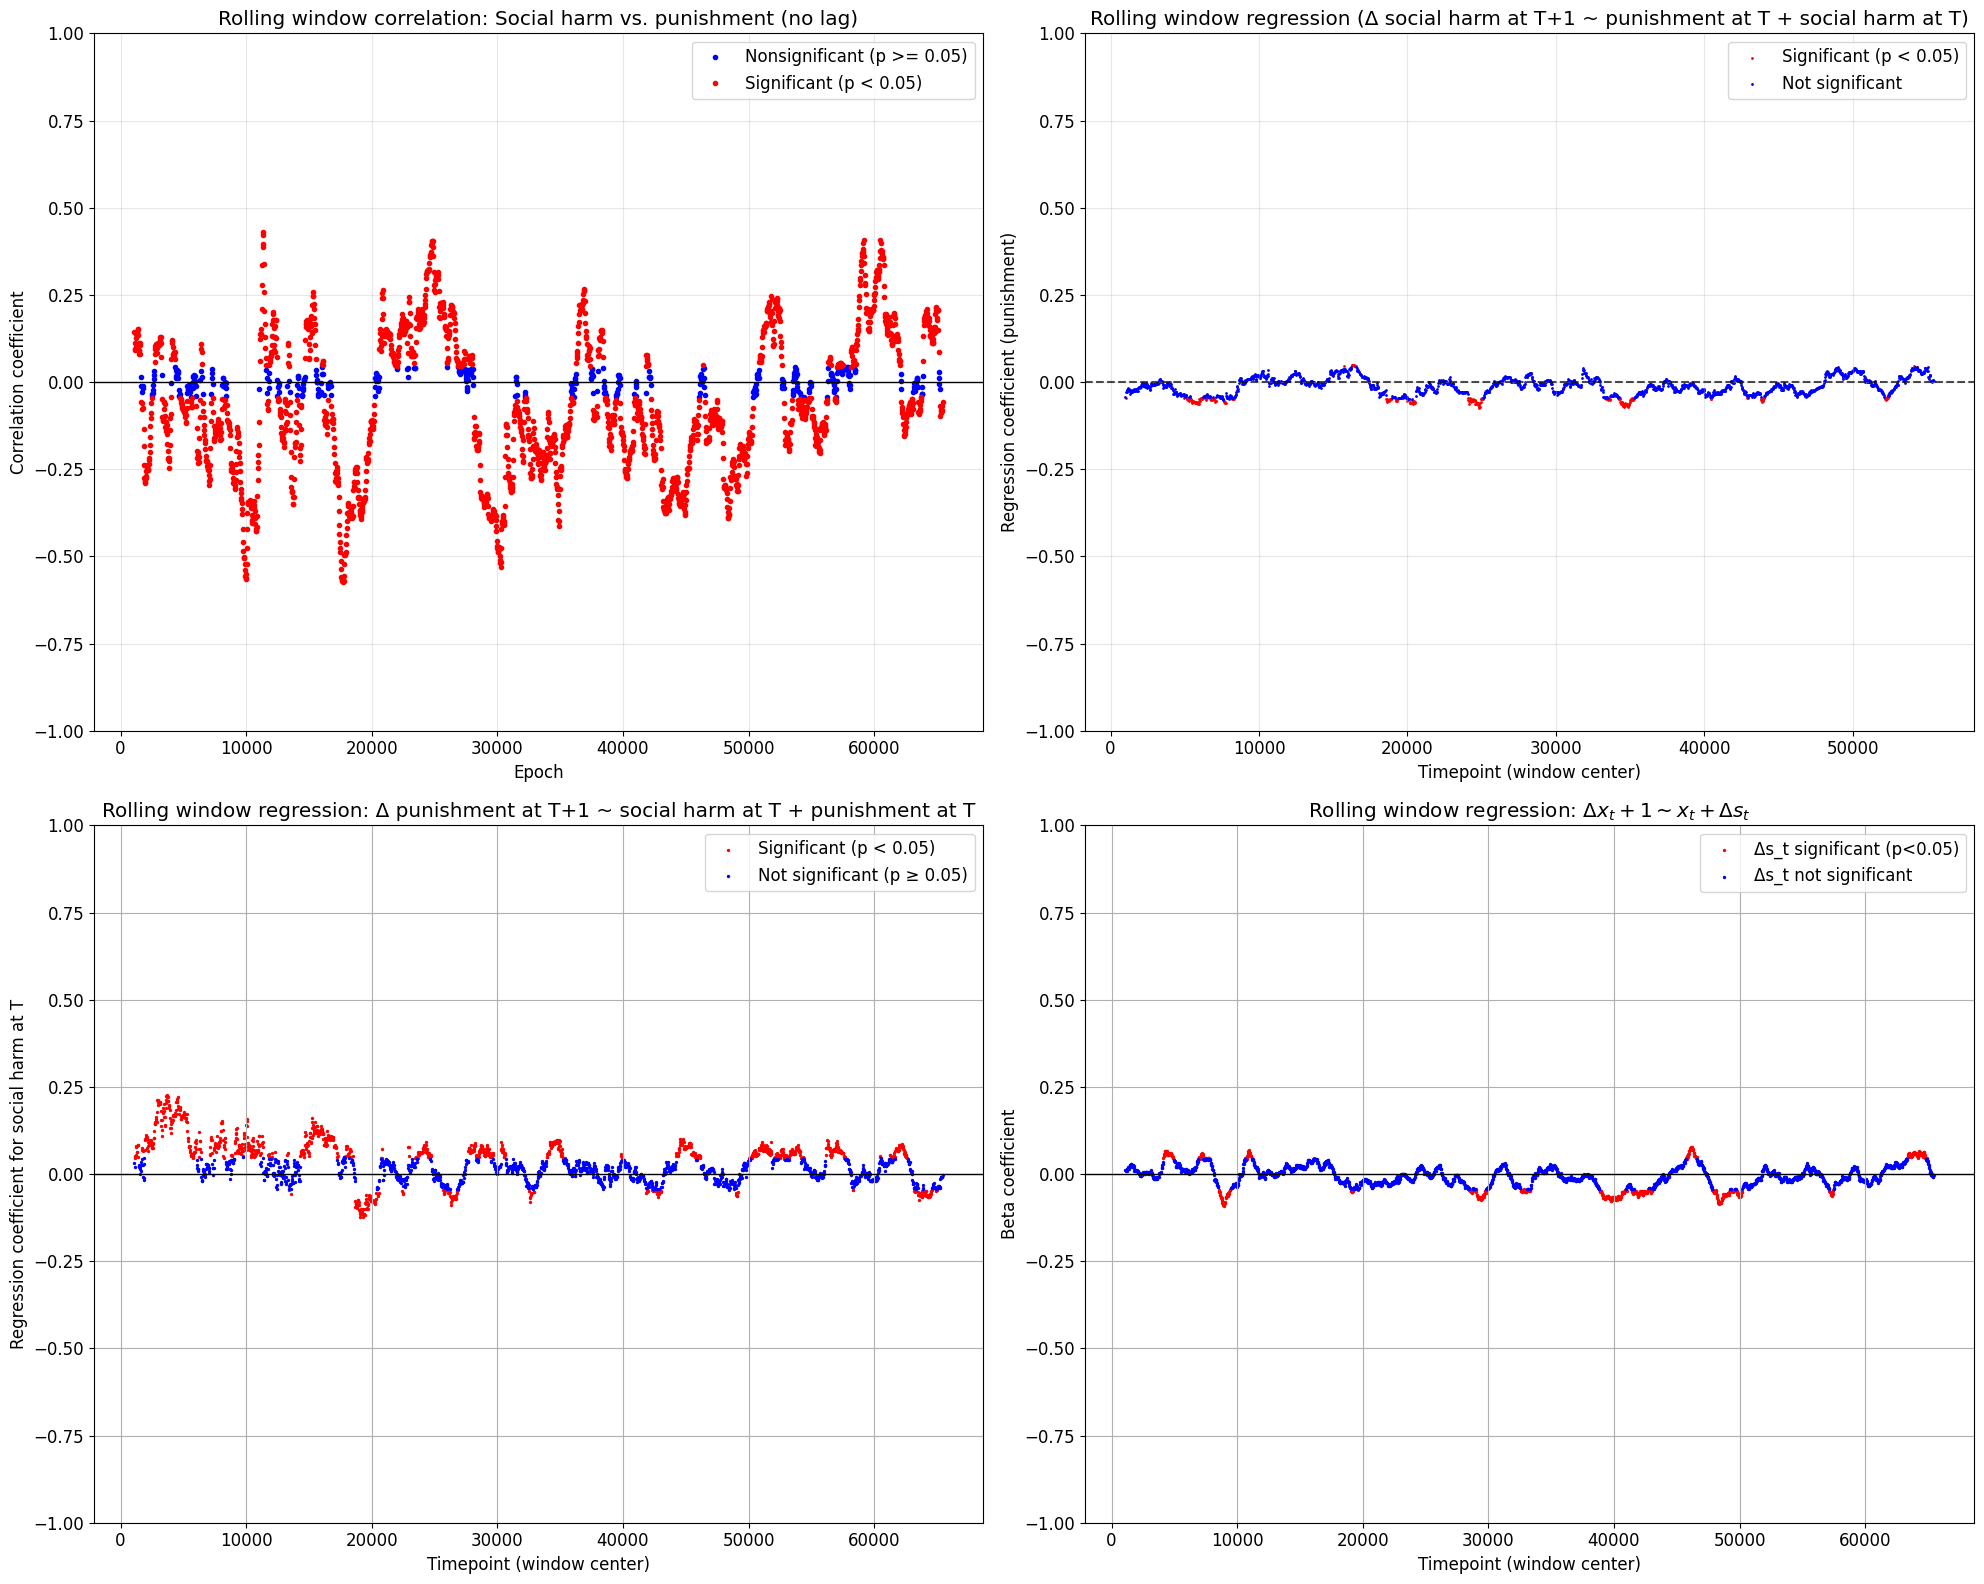

In [28]:
system_analysis(f, 100, 100, 2000, 25, 1, 10000)

## plot state punishment, social harm received, and actions

In [45]:
f = [
    # 'res/runs_debug4/slow_voting_noreset_5steps_mode_iqn_separate_models_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260113-114937',
    # 'res/runs_debug4/slow_voting_noreset_5steps_mode_iqn_separate_models_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260113-114919',
    # 'res/runs_debug4/slow_voting_5steps_mode_iqn_separate_models_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260113-023736',
    # 'res/runs_debug4/slow_voting_noreset_5steps_mode_iqn_separate_models_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260113-023931',
    # 'res/runs_debug3/voting_season_10steps_mode_iqn_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260107-173454',
    # 'res/runs_debug3/voting_season_5steps_mode_iqn_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260107-172531',
    # 'res/runs_debug3/validate_ppo_10agents_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260104-200742',
    # 'res/runs_debug3/validate_3agents_complex_params_corrected_values_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20260101-203024',
    'res/runs_debug3/validate_10agents_complex_params_corrected_values_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260101-203440',
    'res/runs_debug3/test_lstm_cpc_dynamic_punishment_dec30_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_lstm_cpc_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20251230-202359',
    # 'res/runs_debug3/test_lstm_cpc_fixedlevel',
    'res/runs_debug3/validate_reward_structure_complex_para_3agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20251226-012952',
    'res/runs_debug3/validate_reward_structure_socialharm3_10agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20251224-163408',
    'res/runs_debug3/validate_reward_structure_socialharm7.5_4agents_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_4a_pknown_sknown_20251223-174530',
    'res/runs_debug3/validate_ppo_simple_params_simple_punish_lr0.00005_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251222-223254',
    'res/runs_debug3/simple_params_test_minor_harms_for_good_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251220-151123',
    'res/runs_debug3/validation_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251217-210011',
    'res/runs_debug3/validate_ppo_simple_params_complex_punish_lr0.00005_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251222-155203',
    'res/runs_debug3/validation_punishment_structure_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251219-004358',
    'res/runs_debug3/validation_ppo_v3_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251219-204259',
    # "res/runs_debug3/validation_gamma099_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251218-152052",
    "res/runs_debug3/validation_punishment_structure_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251219-004358",
    # "res/runs_debug3/simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-224938",
    # "res/runs_debug3/corrected_simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225255",
    # "res/runs_debug3/corrected_simple_params_gamma0.95_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225406",
    "res/runs_debug3/simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-155623",
    "res/runs_debug3/simple_params_v5_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-152834",
    "res/runs_debug3/original_params_learningparamsv2_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251215-152637",
    "res/runs_debug3/simple_params_v3_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251215-145855",
    "res/runs_debug3/simple_params_v3_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251214-204027",
    "res/runs_debug3/simple_params_v2_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251213-202005",
    'res/runs_debug3/orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251210-231740',
    'res/runs_debug1/simple_params_p25_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-223847',
    'res/runs_debug1/orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-224326',
    'res/runs_debug1/simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251208-224132',
    'res/runs_debug1/corrected_orig_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_single_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-134348',
    'res/runs_debug2/with_norm_enforcer_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_ne_th50_dr990_is-05_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251210-003702',
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-163058',
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162807',
    'res/runs_debug2/simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162411'
][0]
f = 'res/runs_debug3/validate_ppo_10agents_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260104-200742'
# f = 'res/runs_debug4/phased_voting_s100_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_pnoreset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-170205'
# f = 'res/runs_debug4/iqn_corrected_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_preset_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260114-164739'
# f = 'res/runs_debug3/validate_reward_structure_socialharm20_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251223-005148'
# f = [
#     "res/runs_debug3/validation_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251217-210011",
#     "res/runs_debug3/validation_epsilon0.0_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251217-205950"
# ][1]
# f = 'res/runs_debug3/test_lstm_cpc_fixedlevel_dec29_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251229-160908'
# f = 'res/runs_debug3/test_lstm_cpc_fixedlevel_dec29_v2_prob_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_lstm_cpc_sf_r0.005_v4_m10_cvFalse_meTrue_2a_p0.2_pknown_sknown_20251229-160812'
state_punishment_level = pd.read_csv(f'{f}/Global_average_punishment_level_data.csv')['Value']
social_harm_received = pd.read_csv(f'{f}/Mean_mean_social_harm_received_data.csv')['Value']
vote_increase = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_increase_data.csv')['Value']
vote_decrease = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')['Value']
vote_total_counts = vote_increase + vote_decrease
reward_series = pd.read_csv(f'{f}/Mean_mean_individual_score_data.csv')['Value']

# resources collected
resource_A = pd.read_csv(f'{f}/Mean_mean_a_encounters_data.csv')['Value']
resource_B = pd.read_csv(f'{f}/Mean_mean_b_encounters_data.csv')['Value']
resource_C = pd.read_csv(f'{f}/Mean_mean_c_encounters_data.csv')['Value']
resource_D = pd.read_csv(f'{f}/Mean_mean_d_encounters_data.csv')['Value']
resource_E = pd.read_csv(f'{f}/Mean_mean_e_encounters_data.csv')['Value']
resource_total = resource_A + resource_B + resource_C + resource_D + resource_E

# action frequency
action_freq_down_data = pd.read_csv(f'{f}/Mean_mean_action_freq_down_data.csv')['Value']
action_freq_up_data = pd.read_csv(f'{f}/Mean_mean_action_freq_up_data.csv')['Value']
action_freq_left_data = pd.read_csv(f'{f}/Mean_mean_action_freq_left_data.csv')['Value']
action_freq_right_data = pd.read_csv(f'{f}/Mean_mean_action_freq_right_data.csv')['Value']
action_freq_vote_increase_data = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_increase_data.csv')['Value']
action_freq_vote_decrease_data = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')['Value']
# action_freq_noop_data = pd.read_csv(f'{f}/Mean_mean_action_freq_noop_data.csv')['Value']
# action_freq_total_data = action_freq_down_data + action_freq_up_data + action_freq_left_data + action_freq_right_data + action_freq_vote_increase_data + action_freq_vote_decrease_data 


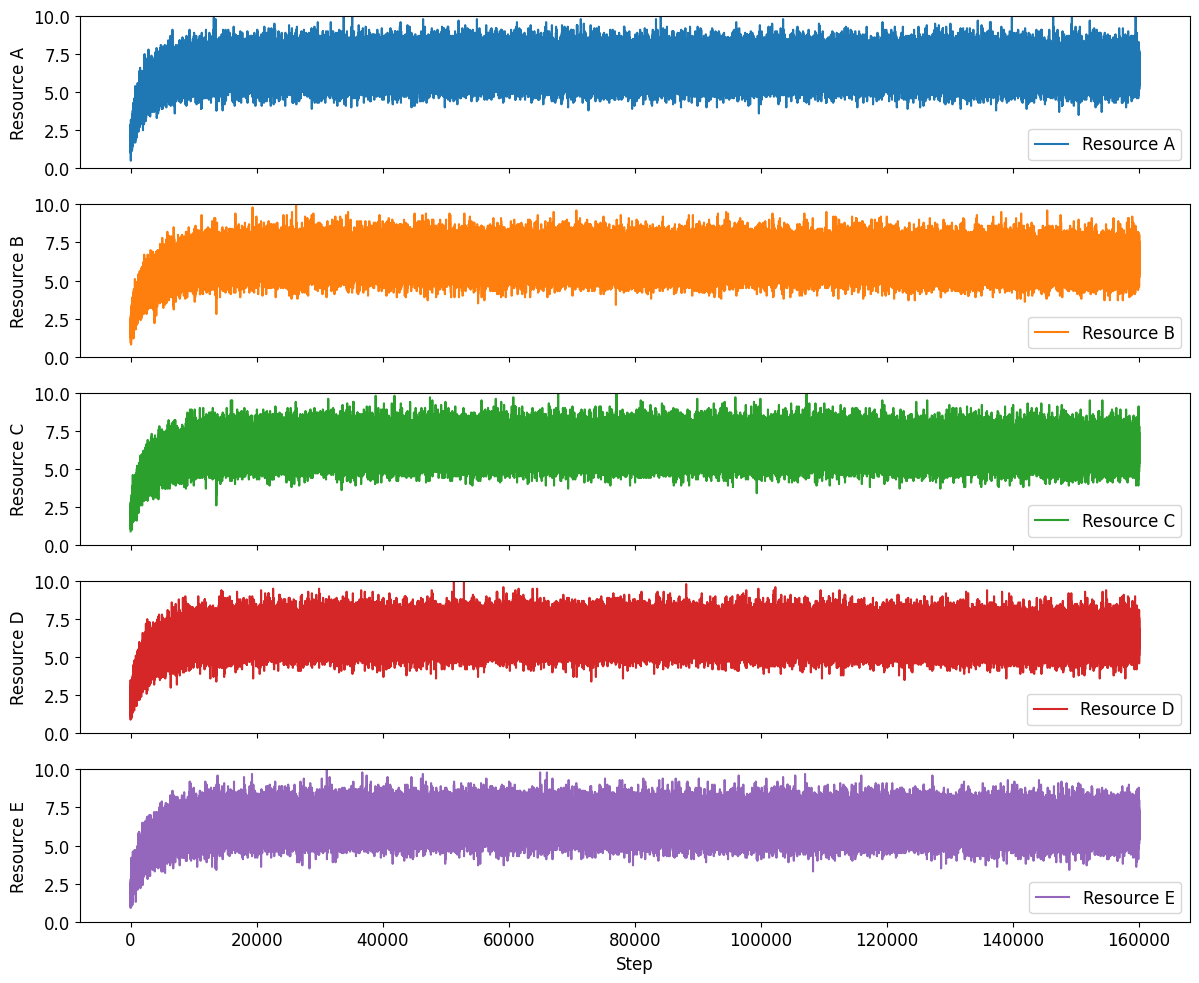

In [46]:
# plot the metrics for each resource separately
import matplotlib.pyplot as plt

wsize = 1
end = 300000

fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

axs[0].plot(resource_A[:end].rolling(window=wsize).mean(), label='Resource A', color='tab:blue')
axs[0].set_ylabel('Resource A')
axs[0].set_ylim(0, 10)
axs[0].legend()

axs[1].plot(resource_B[:end].rolling(window=wsize).mean(), label='Resource B', color='tab:orange')
axs[1].set_ylabel('Resource B')
axs[1].set_ylim(0, 10)
axs[1].legend()

axs[2].plot(resource_C[:end].rolling(window=wsize).mean(), label='Resource C', color='tab:green')
axs[2].set_ylabel('Resource C')
axs[2].set_ylim(0, 10)
axs[2].legend()

axs[3].plot(resource_D[:end].rolling(window=wsize).mean(), label='Resource D', color='tab:red')
axs[3].set_ylabel('Resource D')
axs[3].set_ylim(0, 10)
axs[3].legend()

axs[4].plot(resource_E[:end].rolling(window=wsize).mean(), label='Resource E', color='tab:purple')
axs[4].set_ylabel('Resource E')
axs[4].set_ylim(0, 10)
axs[4].legend()

plt.xlabel('Step')
plt.tight_layout()
plt.show()


In [47]:
min_ = min(len(resource_A), len(resource_B), len(resource_C), len(resource_D), len(resource_E))

In [49]:
np.corrcoef(resource_A[:min_], resource_B[:min_]+resource_C[:min_] +resource_D[:min_]+resource_E[:min_])

array([[1.        , 0.22713434],
       [0.22713434, 1.        ]])

res/runs_debug3/validate_ppo_10agents_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260104-200742


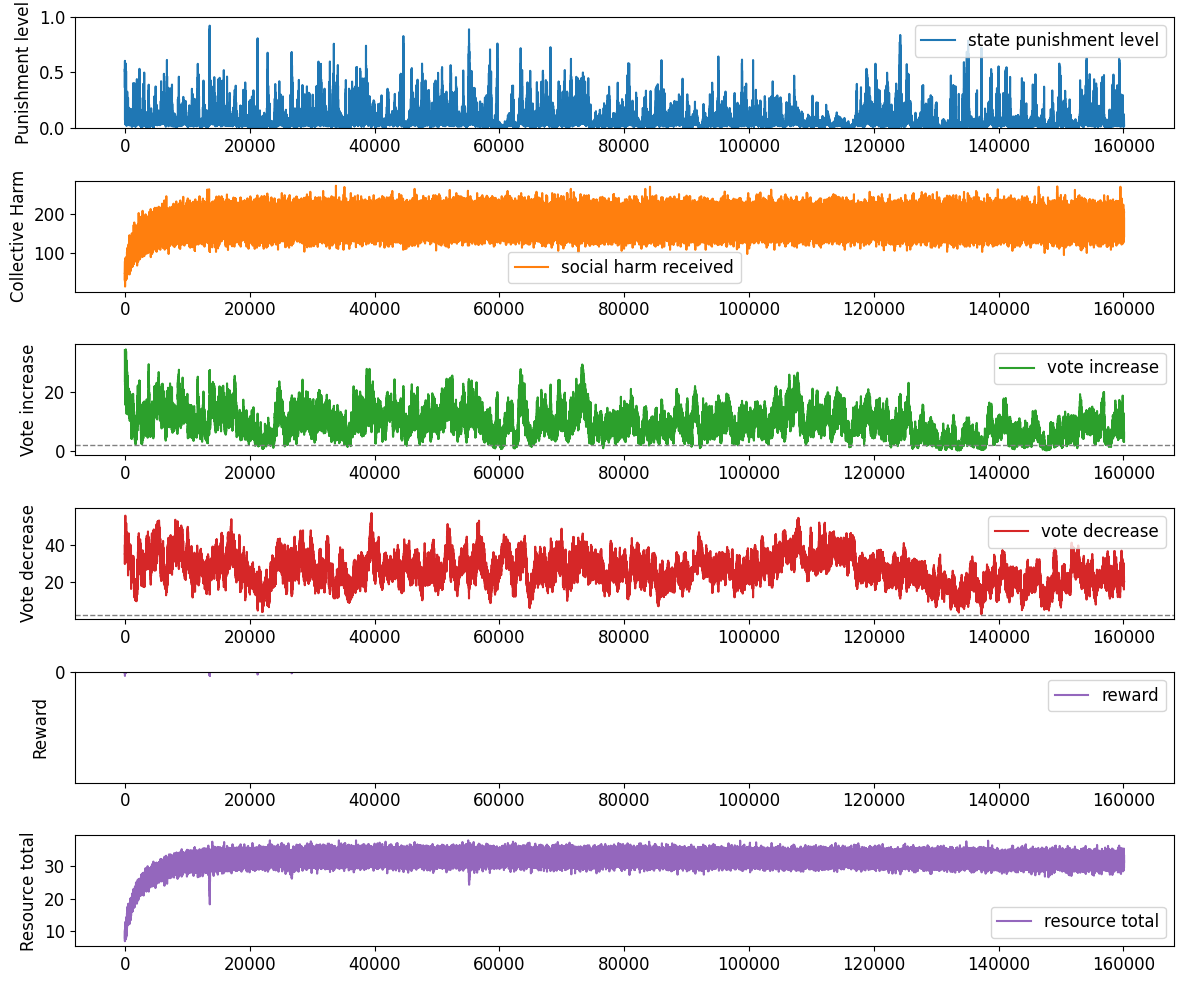

149.55950511669295


In [50]:
wsize = 1
end = 300000
print(f)
# plot the metrics separately
plt.figure(figsize=(12, 10))
plt.subplot(6, 1, 1)
plt.plot(state_punishment_level[:end].rolling(window=wsize).mean(), label='state punishment level', color='tab:blue')
plt.ylabel('Punishment level')
plt.ylim(0, 1)
plt.legend()
plt.subplot(6, 1, 2)
plt.plot(social_harm_received[:end].rolling(window=wsize).mean(), label='social harm received', color='tab:orange')
plt.ylabel('Collective Harm')
plt.legend()
plt.subplot(6, 1, 3)
plt.plot(vote_increase[:end].rolling(window=wsize).mean(), label='vote increase', color='tab:green')
plt.axhline(2, color='gray', linestyle='--', linewidth=1)
plt.ylabel('Vote increase')
plt.legend()
plt.subplot(6, 1, 4)
plt.plot(vote_decrease[:end].rolling(window=wsize).mean(), label='vote decrease', color='tab:red')
plt.axhline(2, color='gray', linestyle='--', linewidth=1)
plt.ylabel('Vote decrease')
plt.legend()
plt.subplot(6, 1, 5)
plt.plot(reward_series[:end].rolling(window=wsize).mean(), label='reward', color='tab:purple')
plt.axhline(140, color='gray', linestyle='--', linewidth=1)
plt.axhline(100, color='gray', linestyle='--', linewidth=1)
plt.yticks([0, 100, 140], [0, 100, 140])
plt.ylim(-1000, 0)
plt.ylabel('Reward')
plt.legend()
plt.subplot(6, 1, 6)
plt.plot(resource_total[:end].rolling(window=wsize).mean(), label='resource total', color='tab:purple')
plt.ylabel('Resource total')
plt.legend()
# plt.ylim(0, 7)
# plt.xticks([])
# plt.xlabel('Step')
plt.tight_layout()
plt.show()

print(reward_series[20000:].mean())

In [32]:
reward_series_1 = reward_series

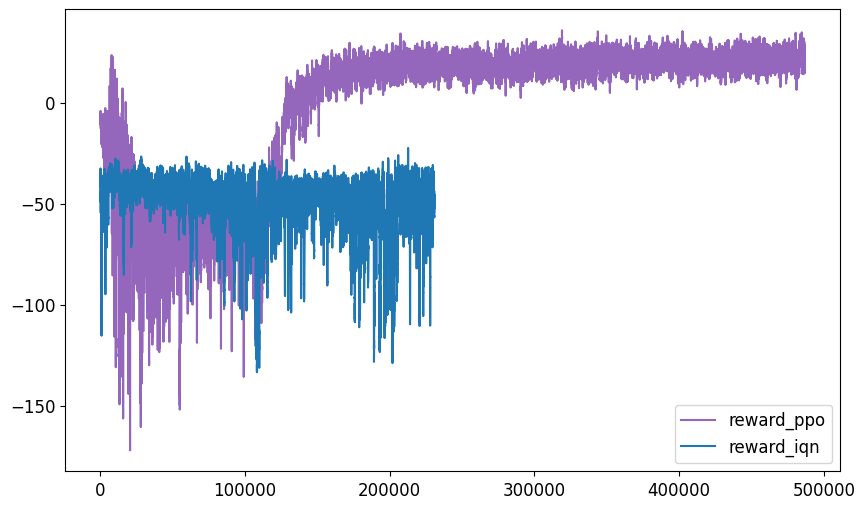

In [36]:
plt.plot(reward_series_1.rolling(window=wsize).mean(), label='reward_ppo', color='tab:purple')
plt.plot(reward_series.rolling(window=wsize).mean(), label='reward_iqn', color='tab:blue')
plt.legend()
plt.show()


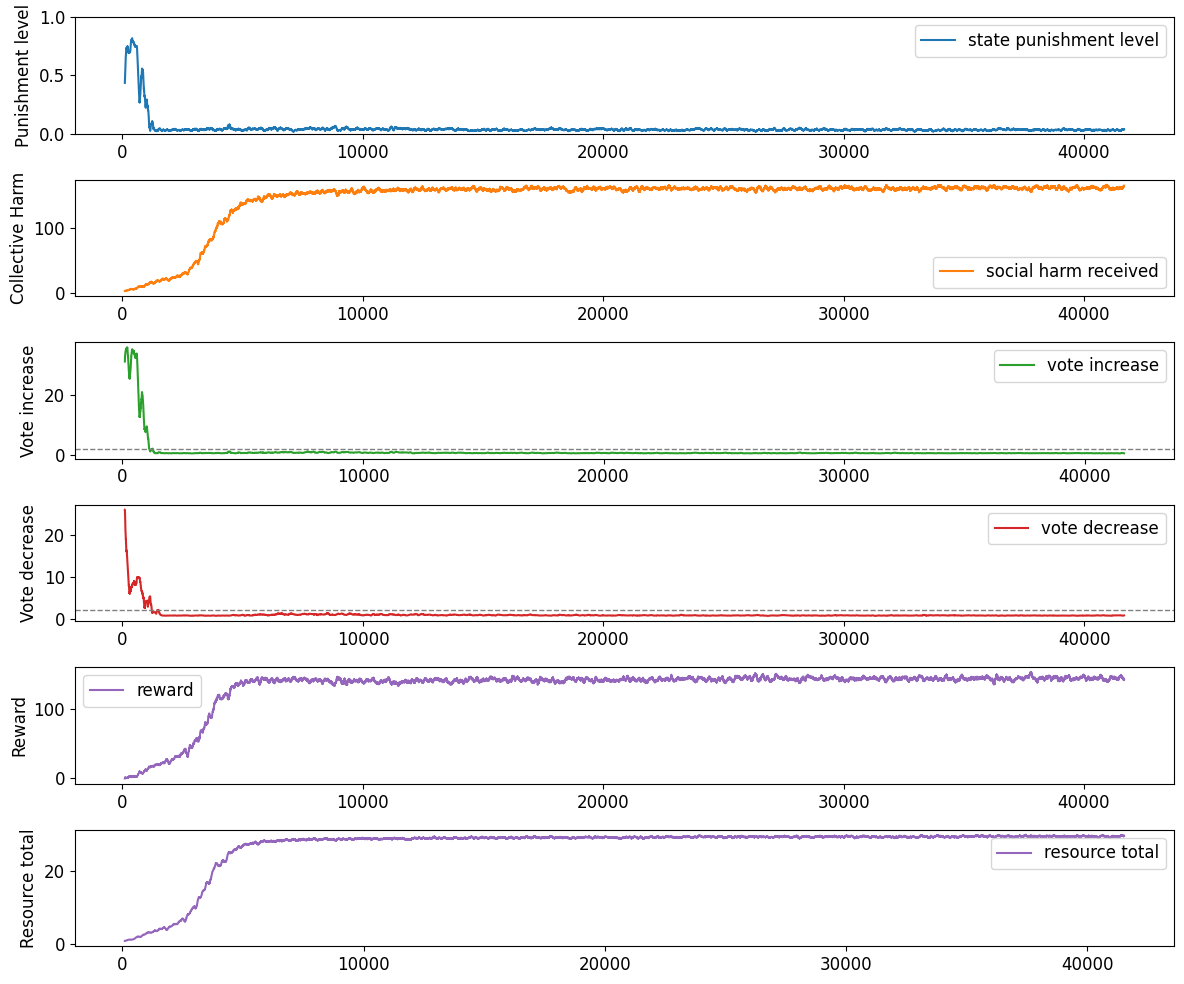

In [20]:
wsize = 100
# plot the metrics separately
plt.figure(figsize=(12, 10))
plt.subplot(6, 1, 1)
plt.plot(state_punishment_level.rolling(window=wsize).mean(), label='state punishment level', color='tab:blue')
plt.ylabel('Punishment level')
plt.ylim(0, 1)
plt.legend()
plt.subplot(6, 1, 2)
plt.plot(social_harm_received.rolling(window=wsize).mean(), label='social harm received', color='tab:orange')
plt.ylabel('Collective Harm')
plt.legend()
plt.subplot(6, 1, 3)
plt.plot(vote_increase.rolling(window=wsize).mean(), label='vote increase', color='tab:green')
plt.axhline(2, color='gray', linestyle='--', linewidth=1)
plt.ylabel('Vote increase')
plt.legend()
plt.subplot(6, 1, 4)
plt.plot(vote_decrease.rolling(window=wsize).mean(), label='vote decrease', color='tab:red')
plt.axhline(2, color='gray', linestyle='--', linewidth=1)
plt.ylabel('Vote decrease')
plt.legend()
plt.subplot(6, 1, 5)
plt.plot(reward_series.rolling(window=wsize).mean(), label='reward', color='tab:purple')
plt.ylabel('Reward')
plt.legend()
plt.subplot(6, 1, 6)
plt.plot(resource_total.rolling(window=wsize).mean(), label='resource total', color='tab:purple')
plt.ylabel('Resource total')
plt.legend()
# plt.ylim(0, 7)
# plt.xticks([])
# plt.xlabel('Step')
plt.tight_layout()
plt.show()



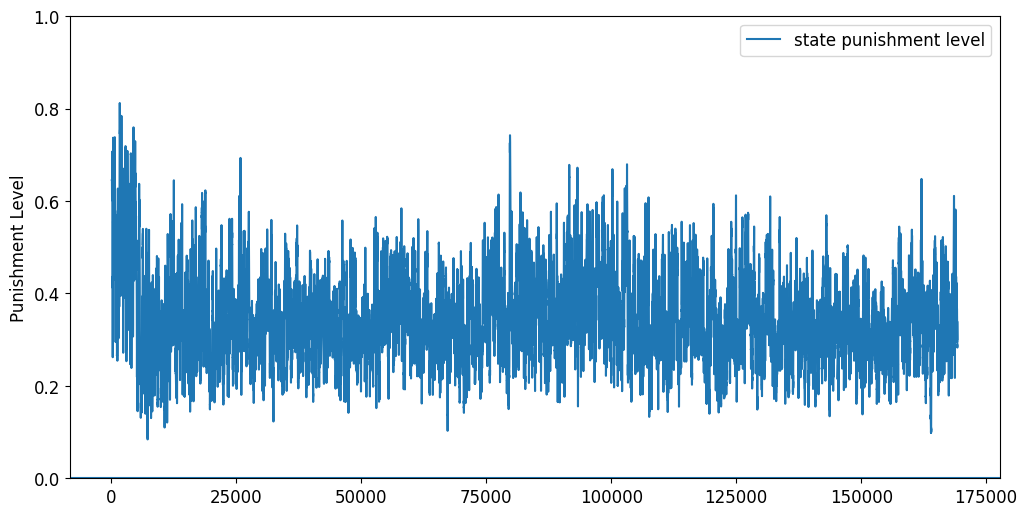

In [108]:
# only plot the state punishment level
plt.figure(figsize=(12, 6))
wsize = 100
plt.plot(state_punishment_level.rolling(window=wsize).mean(), label='state punishment level', color='tab:blue')
plt.ylabel('Punishment Level')
plt.axhline()
plt.ylim(0, 1)
plt.legend()
plt.show()

In [115]:
social_harm_received_smooth

array([ 0.315 ,  0.315 ,  0.315 , ..., 15.84  , 15.57  , 15.2925])

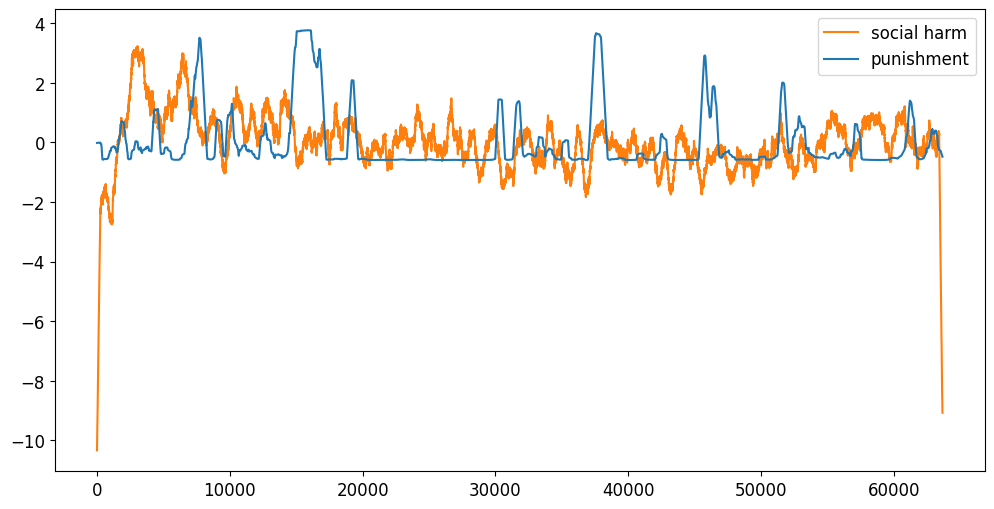

In [60]:
# plot the social harm and punishment levels together
wsize = 500
plt.figure(figsize=(12, 6))
social_harm_received_smooth = moving_avg(social_harm_received, wsize)
state_punishment_level_smooth = moving_avg(state_punishment_level, wsize)
zscore_social_harm_received = zscore(social_harm_received_smooth)
zscore_state_punishment_level = zscore(state_punishment_level_smooth)
plt.plot(np.arange(len(zscore_social_harm_received)), zscore_social_harm_received, label='social harm', color='tab:orange')
plt.plot(np.arange(len(zscore_state_punishment_level)), zscore_state_punishment_level, label='punishment', color='tab:blue')
plt.legend()
# plt.xlim(0, 120000)
plt.show()


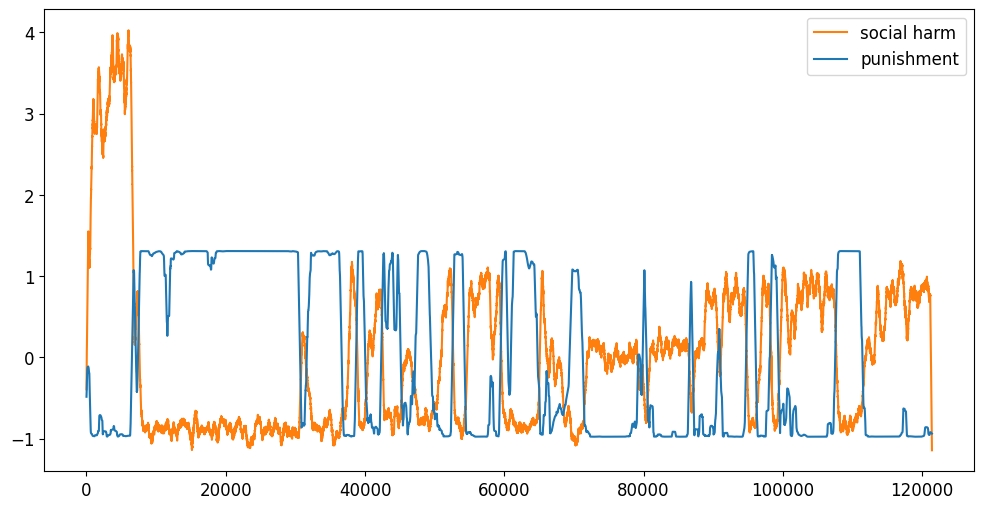

In [139]:
# plot the social harm and punishment levels together
wsize = 500
plt.figure(figsize=(12, 6))
social_harm_received_smooth = moving_avg(social_harm_received, wsize)
state_punishment_level_smooth = moving_avg(state_punishment_level, wsize)
zscore_social_harm_received = zscore(social_harm_received_smooth)
zscore_state_punishment_level = zscore(state_punishment_level_smooth)
plt.plot(np.arange(len(zscore_social_harm_received)), zscore_social_harm_received, label='social harm', color='tab:orange')
plt.plot(np.arange(len(zscore_state_punishment_level)), zscore_state_punishment_level, label='punishment', color='tab:blue')
plt.legend()
plt.show()


## cross corr analyses

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ============================================================
# 0) LOAD DATA (ONLY PLACE WHERE DATA ENTERS THE PIPELINE)
# ============================================================
# These must exist in your session. Replace with your own loading if needed.
# social_harm = ...
# punishment_levels = ...
# social_harm = np.asarray(social_harm, dtype=float)
# punishment_levels = np.asarray(punishment_levels, dtype=float)

assert social_harm.ndim == 1 and punishment_levels.ndim == 1
assert len(social_harm) == len(punishment_levels)

# ============================================================
# 1) PARAMETERS
# ============================================================
k = 400           # smoothing window for harm (set 1 to disable)
max_lag = 2000    # max lag for cross-correlation (steps)
train_frac = 0.7  # train/test split
start_timepoint = 10000
# ============================================================
# 2) HELPERS
# ============================================================
def moving_avg(x, k):
    if k <= 1:
        return x.copy()
    return np.convolve(x, np.ones(k)/k, mode="same")

def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / (x.std() + 1e-12)

def mse(a, b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean((a-b)**2))

def fit_ols(y, X, train_idx):
    model = sm.OLS(y[train_idx], X[train_idx]).fit()
    pred = model.predict(X)
    return model, pred

def crosscorr(h, s, max_lag):
    """
    corr(h_t, s_{t+lag}) for lag in [-max_lag, +max_lag].
    Positive lag => harm leads punishment.
    """
    h = zscore(h)
    s = zscore(s)
    lags = np.arange(-max_lag, max_lag+1)
    cc = np.empty_like(lags, dtype=float)
    for i, L in enumerate(lags):
        if L < 0:
            hh = h[-L:]
            ss = s[:len(hh)]
        elif L > 0:
            hh = h[:-L]
            ss = s[L:]
        else:
            hh = h
            ss = s
        if len(hh) < 5:
            cc[i] = np.nan
        else:
            cc[i] = np.corrcoef(hh, ss)[0, 1]
    return lags, cc

# ============================================================
# 3) PREP DATA
# ============================================================
h = np.array(social_harm[start_timepoint:])
s = np.array(punishment_levels[start_timepoint:])
s = moving_avg(s, k)
# s = moving_avg(s_raw, k)
h_smooth = moving_avg(h, k)

ds = np.diff(s)   # Δs_t
dh = np.diff(h)   # Δh_t

T = len(h)
N = T - 1
split = int(train_frac * N)
train_idx = np.arange(split)
test_idx = np.arange(split, N)

st = s[:-1]
ht = h_smooth[:-1]

print(f"T={T} (N for diffs={N}); train={len(train_idx)}, test={len(test_idx)}")

# ============================================================
# 4) (A) TRACKING: Δs_t ~ 1 + h_smooth_t + s_t
# ============================================================
X_track = np.column_stack([np.ones(N), ht, st])
model_track, pred_track = fit_ols(ds, X_track, train_idx)

print("\n=== Tracking model: Δs_t ~ 1 + h_smooth_t + s_t ===")
print(model_track.summary())

# Noise-only comparator: Δs_t ~ 1 + s_t
X_noise = np.column_stack([np.ones(N), st])
model_noise, pred_noise = fit_ols(ds, X_noise, train_idx)

mse_track = mse(ds[test_idx], pred_track[test_idx])
mse_noise = mse(ds[test_idx], pred_noise[test_idx])

print("\nOut-of-sample MSE (lower is better):")
print(f"  noise-only (Δs~s): {mse_noise:.6g}")
print(f"  tracking (Δs~h+s): {mse_track:.6g}")

plt.figure(figsize=(9,4))
plt.plot(ds[test_idx], label="actual Δs (test)")
plt.plot(pred_noise[test_idx], label="pred noise-only")
plt.plot(pred_track[test_idx], label="pred tracking")
plt.axhline(0, linestyle="--")
plt.title("Δs prediction on test set")
plt.xlabel("test index (time)")
plt.ylabel("Δ punishment")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 5) (B) SUPPRESSION: Δh_t ~ 1 + s_t + h_smooth_t
# ============================================================
X_suppress = np.column_stack([np.ones(N), st, ht])
model_suppress, pred_suppress = fit_ols(dh, X_suppress, train_idx)

print("\n=== Suppression model: Δh_t ~ 1 + s_t + h_smooth_t ===")
print(model_suppress.summary())

plt.figure(figsize=(9,4))
plt.plot(dh[test_idx], label="actual Δh (test)")
plt.plot(pred_suppress[test_idx], label="pred suppression")
plt.axhline(0, linestyle="--")
plt.title("Δh prediction on test set")
plt.xlabel("test index (time)")
plt.ylabel("Δ harm")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 6) (C) CROSS-CORRELATION: corr(h_t, s_{t+lag})
# ============================================================
h_smooth = h_smooth[lag:]
s = s[lag:] - s[:-lag]
lags, cc = crosscorr(h_smooth, s, max_lag=max_lag)

plt.figure(figsize=(10,4))
plt.plot(lags, cc)
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--")
plt.title("Cross-correlation: corr(h_t, s_{t+lag})  (positive lag = harm leads)")
plt.xlabel("lag (steps)")
plt.ylabel("correlation")
plt.tight_layout()
plt.show()

valid = np.isfinite(cc)
lags_v = lags[valid]
cc_v = cc[valid]

# best lags on each side
pos_mask = lags_v >= 0
neg_mask = lags_v <= 0
if np.any(pos_mask):
    best_pos_lag = lags_v[pos_mask][np.argmax(cc_v[pos_mask])]
    best_pos_corr = cc[lags == best_pos_lag][0]
    print(f"\nPeak corr at lag>=0: lag={best_pos_lag}, corr={best_pos_corr:.4f}")
if np.any(neg_mask):
    best_neg_lag = lags_v[neg_mask][np.argmax(cc_v[neg_mask])]
    best_neg_corr = cc[lags == best_neg_lag][0]
    print(f"Peak corr at lag<=0: lag={best_neg_lag}, corr={best_neg_corr:.4f}")


In [24]:
f = [
    "res/runs_debug3/validation_punishment_structure_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251219-004358",
    "res/runs_debug3/simple_params_v5_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-152834",
    "res/runs_debug3/corrected_simple_params_gamma0.95_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225406",
    "res/runs_debug3/corrected_simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-225255",
    "res/runs_debug3/simple_params_v4_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251216-224938",
    "res/runs_debug3/original_params_learningparamsv2_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251215-152637",
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-163058',
    'res/runs_debug2/p25_simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162807',
    'res/runs_debug2/simple_params_epsilon0.0_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_2a_pknown_sknown_20251209-162411'
][0]
f= 'res/runs_debug3/validate_10agents_complex_params_corrected_values_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260101-203440'# parameters
f = 'res/runs_debug3/validate_3agents_complex_params_corrected_values_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_iqn_sp_r0.005_v4_m10_cvFalse_meTrue_3a_pknown_sknown_20260101-203024'
f = 'res/runs_debug3/validate_ppo_10agents_orginal_params_v2_prob_ext_charm_immed_silly_pnoobs_pothnoobs_noapp_norep_none_ppo_dual_sp_r0.005_v4_m10_cvFalse_meTrue_10a_pknown_sknown_20260104-200742'

wsize = 1
# Load social harm and punishment data
social_harm = pd.read_csv(f'{f}/Mean_mean_social_harm_received_data.csv')
punishment_levels = pd.read_csv(f'{f}/Global_average_punishment_level_data.csv')
vote_increase_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_increase_data.csv')
vote_decrease_freq = pd.read_csv(f'{f}/Mean_mean_action_freq_vote_decrease_data.csv')


# remove missing values
social_harm = social_harm.rename(columns={'Value': 'social_harm'})
punishment_levels = punishment_levels.rename(columns={'Value': 'punishment_levels'})
vote_increase_freq = vote_increase_freq.rename(columns={'Value': 'vote_increase_freq'})
vote_decrease_freq = vote_decrease_freq.rename(columns={'Value': 'vote_decrease_freq'})
df_harm_and_punishment = pd.concat([social_harm, punishment_levels], axis=1)
df_harm_and_punishment = df_harm_and_punishment.dropna()
social_harm = df_harm_and_punishment['social_harm'].rolling(window=wsize).mean()
punishment_levels = df_harm_and_punishment['punishment_levels'].rolling(window=wsize).mean()

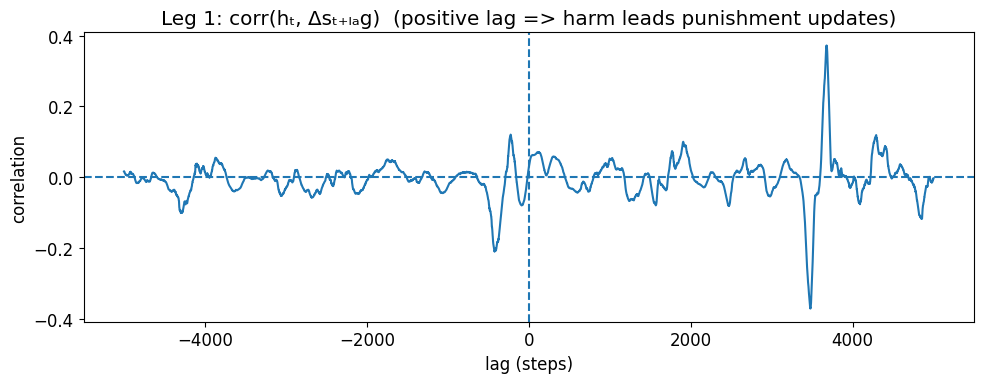

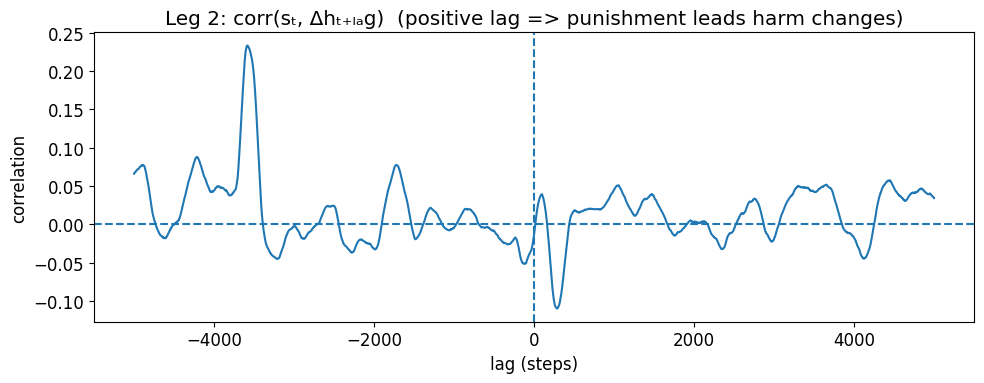


Expected if delayed negative feedback is present:
 - Leg 1 peak (max) at lag >= 0
 - Leg 2 trough (min) at lag >= 0

Leg 1 (harm -> Δs): (3679, 0.37243147690710743)
Leg 2 (s -> Δh):   (289, -0.10988992397102235)


In [25]:
# ============================================================
# (C) Lag/Delay evidence for the two legs of the loop
#   Leg 1: harm -> punishment updates   corr(h_t, Δs_{t+lag})
#   Leg 2: punishment -> harm changes   corr(s_t, Δh_{t+lag})
#
# All data must be loaded/defined AT THE TOP.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 0) LOAD DATA HERE
# ----------------------------
# social_harm = ...
# punishment_levels = ...

# social_harm = np.asarray(social_harm, dtype=float)
# punishment_levels = np.asarray(punishment_levels, dtype=float)
assert social_harm.ndim == 1 and punishment_levels.ndim == 1
assert len(social_harm) == len(punishment_levels)
T = len(social_harm)

# ----------------------------
# 1) PARAMETERS (edit freely)
# ----------------------------
k_h = 200      # smooth harm (set 1 to disable)
k_s = 200          # optionally smooth punishment too (try 1, 50, 200)
max_lag = 5000   # lags in steps to evaluate
min_pairs = 50   # minimum aligned samples per lag
start_timepoint = 10000
# ----------------------------
# 2) HELPERS
# ----------------------------
def moving_avg(x, k):
    if k <= 1:
        return x.copy()
    return np.convolve(x, np.ones(k)/k, mode="same")

def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / (x.std() + 1e-12)

def lagged_corr(x, y, lags, min_pairs=50):
    """
    Compute corr(x_t, y_{t+lag}) across lags.
    Positive lag => x leads y.
    """
    x = zscore(x)
    y = zscore(y)
    cc = np.full_like(lags, np.nan, dtype=float)
    for i, L in enumerate(lags):
        if L < 0:
            xx = x[-L:]
            yy = y[:len(xx)]
        elif L > 0:
            xx = x[:-L]
            yy = y[L:]
        else:
            xx = x
            yy = y
        if len(xx) >= min_pairs:
            cc[i] = np.corrcoef(xx, yy)[0, 1]
    return cc

def peak_info(cc, lags, direction="max", lag_domain="pos"):
    mask = np.isfinite(cc)
    if lag_domain == "pos":
        mask &= (lags >= 0)
    elif lag_domain == "neg":
        mask &= (lags <= 0)
    if not np.any(mask):
        return None
    vals = cc[mask]
    idx = int(np.argmax(vals)) if direction == "max" else int(np.argmin(vals))
    return int(lags[mask][idx]), float(vals[idx])

# ----------------------------
# 3) PREP SIGNALS
# ----------------------------
h = np.array(social_harm[start_timepoint:])
s = np.array(punishment_levels[start_timepoint:])

h_smooth = moving_avg(h, k_h)
s_smooth = moving_avg(s, k_s)

ds = np.diff(s_smooth)   # Δs_t, length T-1
dh = np.diff(h_smooth)   # Δh_t, length T-1

# Drivers at time t (also length T-1)
h_t = h_smooth[:-1]
s_t = s_smooth[:-1]

lags = np.arange(-max_lag, max_lag + 1)

# ----------------------------
# 4) LEG-SPECIFIC LAG CORRS
# ----------------------------
# Leg 1 (expected positive at lag>=0): harm leads punishment updates
cc_h_to_ds = lagged_corr(h_t, ds, lags, min_pairs=min_pairs)

# Leg 2 (expected negative at lag>=0): punishment leads harm changes
cc_s_to_dh = lagged_corr(s_t, dh, lags, min_pairs=min_pairs)

# ----------------------------
# 5) PLOTS
# ----------------------------
plt.figure(figsize=(10, 4))
plt.plot(lags, cc_h_to_ds)
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--")
plt.title("Leg 1: corr(hₜ, Δsₜ₊ₗₐg)  (positive lag => harm leads punishment updates)")
plt.xlabel("lag (steps)")
plt.ylabel("correlation")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(lags, cc_s_to_dh)
plt.axvline(0, linestyle="--")
plt.axhline(0, linestyle="--")
plt.title("Leg 2: corr(sₜ, Δhₜ₊ₗₐg)  (positive lag => punishment leads harm changes)")
plt.xlabel("lag (steps)")
plt.ylabel("correlation")
plt.tight_layout()
plt.show()

# ----------------------------
# 6) QUICK SUMMARIES
# ----------------------------
# Expectation for delayed negative feedback:
# - Leg 1: peak (max) at lag >= 0
# - Leg 2: trough (min / most negative) at lag >= 0
info1 = peak_info(cc_h_to_ds, lags, direction="max", lag_domain="pos")
info2 = peak_info(cc_s_to_dh, lags, direction="min", lag_domain="pos")

print("\nExpected if delayed negative feedback is present:")
print(" - Leg 1 peak (max) at lag >= 0")
print(" - Leg 2 trough (min) at lag >= 0\n")
print("Leg 1 (harm -> Δs):", info1)
print("Leg 2 (s -> Δh):  ", info2)


## lagged linear regression (variant of cross corr)

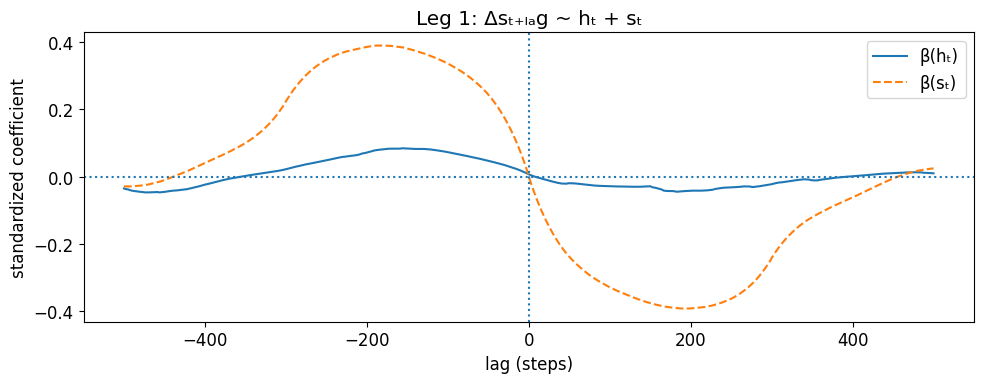

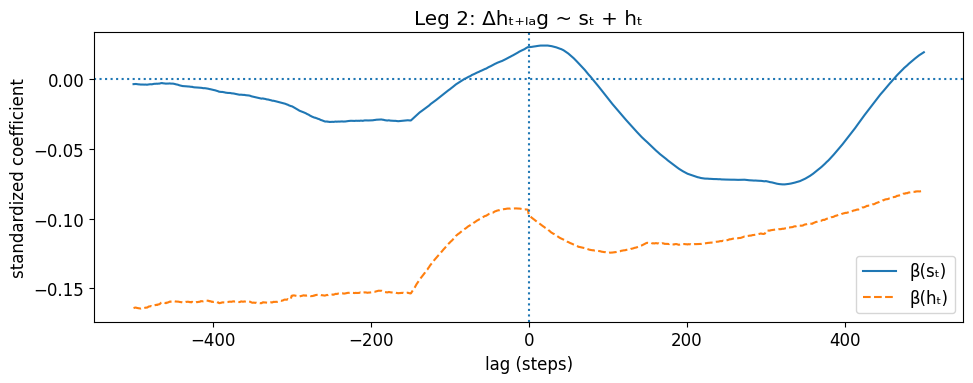


Expected if delayed negative feedback is present:
 - Leg 1: β(hₜ) positive at lag >= 0
 - Leg 2: β(sₜ) negative at lag >= 0

Leg 1 peak β(hₜ): (476, 0.01271291567819341)
Leg 2 trough β(sₜ): (320, -0.07547525648833132)


In [26]:
# ============================================================
# (C) Lag/Delay evidence for the two legs of the loop
#
#   Leg 1: harm -> punishment updates
#          Δs_{t+lag} ~ h_t + s_t
#
#   Leg 2: punishment -> harm changes
#          Δh_{t+lag} ~ s_t + h_t
#
# All data must be loaded/defined AT THE TOP.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 0) LOAD DATA HERE
# ----------------------------
# social_harm = ...
# punishment_levels = ...

social_harm = np.asarray(social_harm, dtype=float)
punishment_levels = np.asarray(punishment_levels, dtype=float)

assert social_harm.ndim == 1 and punishment_levels.ndim == 1
assert len(social_harm) == len(punishment_levels)

T = len(social_harm)

# ----------------------------
# 1) PARAMETERS
# ----------------------------
start_timepoint = 0

k_h = 300        # smooth harm (set 1 to disable)
k_s = 300        # smooth punishment (set 1 to disable)

max_lag = 500   # lags in steps to evaluate
min_pairs = 50   # minimum aligned samples per lag

zscore_vars = True   # standardize before regression

# ----------------------------
# 2) HELPERS
# ----------------------------
def moving_avg(x, k):
    if k <= 1:
        return x.copy()
    return np.convolve(x, np.ones(k) / k, mode="same")

def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / (x.std() + 1e-12)

def lagged_regression(x1, x2, y, lags, min_pairs=50, zscore_vars=True):
    """
    For each lag L, regress y_{t+L} ~ x1_t + x2_t
    Returns arrays: beta_x1, beta_x2, R^2
    """
    x1 = np.asarray(x1, float)
    x2 = np.asarray(x2, float)
    y  = np.asarray(y, float)

    if zscore_vars:
        x1 = zscore(x1)
        x2 = zscore(x2)
        y  = zscore(y)

    b1 = np.full(len(lags), np.nan)
    b2 = np.full(len(lags), np.nan)
    r2 = np.full(len(lags), np.nan)

    for i, L in enumerate(lags):
        if L < 0:
            X1 = x1[-L:]
            X2 = x2[-L:]
            Y  = y[:len(X1)]
        elif L > 0:
            X1 = x1[:-L]
            X2 = x2[:-L]
            Y  = y[L:]
        else:
            X1, X2, Y = x1, x2, y

        if len(Y) < min_pairs:
            continue

        X = np.column_stack([np.ones(len(Y)), X1, X2])
        beta, *_ = np.linalg.lstsq(X, Y, rcond=None)

        yhat = X @ beta
        ssr = np.sum((Y - yhat) ** 2)
        sst = np.sum((Y - Y.mean()) ** 2)

        b1[i] = beta[1]
        b2[i] = beta[2]
        r2[i] = 1 - ssr / sst if sst > 0 else np.nan

    return b1, b2, r2

def peak_info(arr, lags, direction="max", lag_domain="pos"):
    mask = np.isfinite(arr)
    if lag_domain == "pos":
        mask &= (lags >= 0)
    elif lag_domain == "neg":
        mask &= (lags <= 0)
    if not np.any(mask):
        return None
    vals = arr[mask]
    idx = int(np.argmax(vals)) if direction == "max" else int(np.argmin(vals))
    return int(lags[mask][idx]), float(vals[idx])

# ----------------------------
# 3) PREP SIGNALS
# ----------------------------
h = social_harm[start_timepoint:]
s = punishment_levels[start_timepoint:]

h_smooth = moving_avg(h, k_h)
s_smooth = moving_avg(s, k_s)

dh = np.diff(h_smooth)   # Δh_t
ds = np.diff(s_smooth)   # Δs_t

# predictors at time t
h_t = h_smooth[:-1]
s_t = s_smooth[:-1]

lags = np.arange(-max_lag, max_lag + 1)

# ----------------------------
# 4) LAGGED REGRESSIONS
# ----------------------------

# Leg 1: harm -> punishment update
b_h_to_ds, b_s_to_ds, r2_ds = lagged_regression(
    h_t, s_t, ds, lags,
    min_pairs=min_pairs,
    zscore_vars=zscore_vars
)

# Leg 2: punishment -> harm change
b_s_to_dh, b_h_to_dh, r2_dh = lagged_regression(
    s_t, h_t, dh, lags,
    min_pairs=min_pairs,
    zscore_vars=zscore_vars
)

# ----------------------------
# 5) PLOTS
# ----------------------------
plt.figure(figsize=(10, 4))
plt.plot(lags, b_h_to_ds, label="β(hₜ)")
plt.plot(lags, b_s_to_ds, label="β(sₜ)", linestyle="--")
plt.axvline(0, linestyle=":")
plt.axhline(0, linestyle=":")
plt.title("Leg 1: Δsₜ₊ₗₐg ~ hₜ + sₜ")
plt.xlabel("lag (steps)")
plt.ylabel("standardized coefficient")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(lags, b_s_to_dh, label="β(sₜ)")
plt.plot(lags, b_h_to_dh, label="β(hₜ)", linestyle="--")
plt.axvline(0, linestyle=":")
plt.axhline(0, linestyle=":")
plt.title("Leg 2: Δhₜ₊ₗₐg ~ sₜ + hₜ")
plt.xlabel("lag (steps)")
plt.ylabel("standardized coefficient")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 6) QUICK SUMMARIES
# ----------------------------
info_leg1 = peak_info(b_h_to_ds, lags, direction="max", lag_domain="pos")
info_leg2 = peak_info(b_s_to_dh, lags, direction="min", lag_domain="pos")

print("\nExpected if delayed negative feedback is present:")
print(" - Leg 1: β(hₜ) positive at lag >= 0")
print(" - Leg 2: β(sₜ) negative at lag >= 0\n")

print("Leg 1 peak β(hₜ):", info_leg1)
print("Leg 2 trough β(sₜ):", info_leg2)


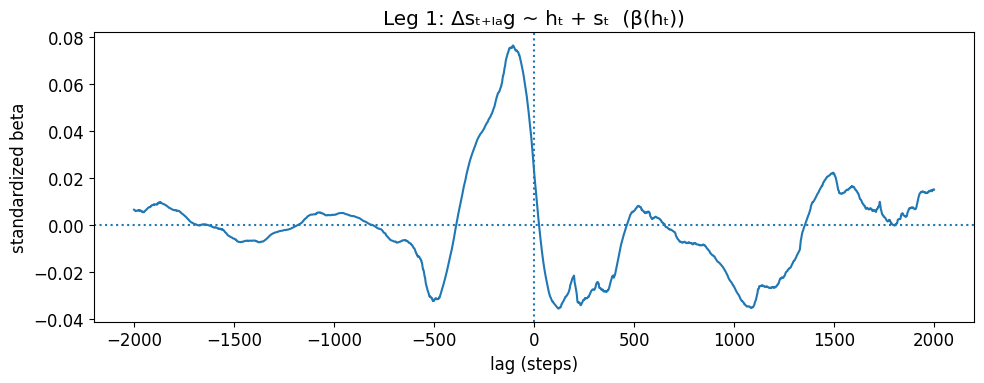

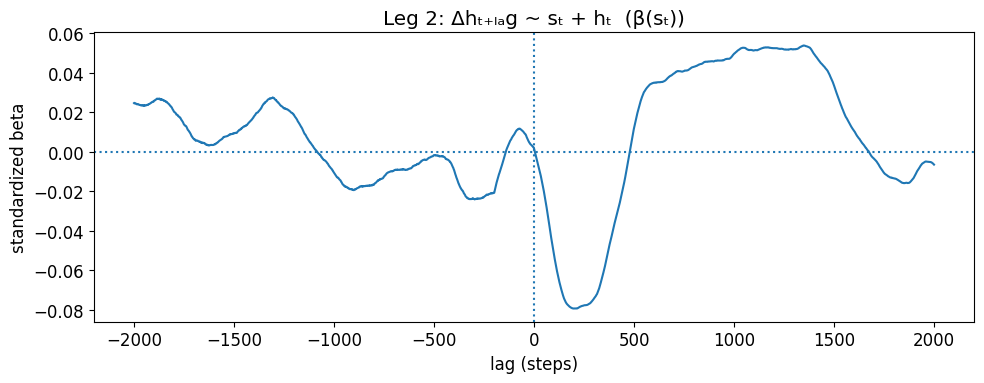


Expected delayed negative feedback:
 - Leg 1: β(hₜ) > 0 at lag ≥ 0
 - Leg 2: β(sₜ) < 0 at lag ≥ 0

Leg 1 peak β(hₜ): (0, 0.022521607081371773)
Leg 2 trough β(sₜ): (201, -0.07927689500868905)


In [27]:
# ============================================================
# MAXIMUM-SPEED Lagged Partial Regression (Numba + closed form)
#
#   Leg 1: Δs_{t+lag} ~ h_t + s_t
#   Leg 2: Δh_{t+lag} ~ s_t + h_t
#
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# ----------------------------
# 0) LOAD DATA HERE
# ----------------------------
# social_harm = ...
# punishment_levels = ...

social_harm = np.asarray(social_harm, dtype=float)
punishment_levels = np.asarray(punishment_levels, dtype=float)

assert social_harm.ndim == 1
assert punishment_levels.ndim == 1
assert len(social_harm) == len(punishment_levels)

# ----------------------------
# 1) PARAMETERS
# ----------------------------
start_timepoint = 0
k_h = 400
k_s = 400
max_lag = 2000
min_pairs = 50

# ----------------------------
# 2) HELPERS
# ----------------------------
def moving_avg(x, k):
    if k <= 1:
        return x.copy()
    return np.convolve(x, np.ones(k) / k, mode="same")

def zscore(x):
    x = np.asarray(x, float)
    return (x - x.mean()) / (x.std() + 1e-12)

# ----------------------------
# 3) PREP SIGNALS
# ----------------------------
h = social_harm[start_timepoint:]
s = punishment_levels[start_timepoint:]

h_s = zscore(moving_avg(h, k_h))
s_s = zscore(moving_avg(s, k_s))

dh = zscore(np.diff(h_s))
ds = zscore(np.diff(s_s))

h_t = h_s[:-1]
s_t = s_s[:-1]

lags = np.arange(-max_lag, max_lag + 1)

# ----------------------------
# 4) CORE FAST KERNEL
# ----------------------------
@njit
def lagged_partial_beta(x, z, y, lags, min_pairs):
    """
    Computes standardized beta for:
        y_{t+lag} ~ x_t + z_t

    Closed-form:
        beta_x = (r_yx - r_yz * r_xz) / (1 - r_xz^2)
    """
    n_lags = len(lags)
    beta = np.full(n_lags, np.nan)

    for i in range(n_lags):
        L = lags[i]

        if L < 0:
            xx = x[-L:]
            zz = z[-L:]
            yy = y[:len(xx)]
        elif L > 0:
            xx = x[:-L]
            zz = z[:-L]
            yy = y[L:]
        else:
            xx = x
            zz = z
            yy = y

        n = len(yy)
        if n < min_pairs:
            continue

        r_yx = np.dot(yy, xx) / n
        r_yz = np.dot(yy, zz) / n
        r_xz = np.dot(xx, zz) / n

        denom = 1.0 - r_xz * r_xz
        if denom > 1e-12:
            beta[i] = (r_yx - r_yz * r_xz) / denom

    return beta

# ----------------------------
# 5) RUN FAST ANALYSIS
# ----------------------------

# Leg 1: Δs ~ h + s
beta_h_to_ds = lagged_partial_beta(h_t, s_t, ds, lags, min_pairs)

# Leg 2: Δh ~ s + h
beta_s_to_dh = lagged_partial_beta(s_t, h_t, dh, lags, min_pairs)

# ----------------------------
# 6) PLOTS
# ----------------------------
plt.figure(figsize=(10, 4))
plt.plot(lags, beta_h_to_ds)
plt.axvline(0, linestyle=":")
plt.axhline(0, linestyle=":")
plt.title("Leg 1: Δsₜ₊ₗₐg ~ hₜ + sₜ  (β(hₜ))")
plt.xlabel("lag (steps)")
plt.ylabel("standardized beta")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(lags, beta_s_to_dh)
plt.axvline(0, linestyle=":")
plt.axhline(0, linestyle=":")
plt.title("Leg 2: Δhₜ₊ₗₐg ~ sₜ + hₜ  (β(sₜ))")
plt.xlabel("lag (steps)")
plt.ylabel("standardized beta")
plt.tight_layout()
plt.show()

# ----------------------------
# 7) QUICK SUMMARY
# ----------------------------
def peak_info(arr, lags, direction="max"):
    mask = np.isfinite(arr) & (lags >= 0)
    if not np.any(mask):
        return None
    vals = arr[mask]
    idx = np.argmax(vals) if direction == "max" else np.argmin(vals)
    return int(lags[mask][idx]), float(vals[idx])

print("\nExpected delayed negative feedback:")
print(" - Leg 1: β(hₜ) > 0 at lag ≥ 0")
print(" - Leg 2: β(sₜ) < 0 at lag ≥ 0\n")

print("Leg 1 peak β(hₜ):", peak_info(beta_h_to_ds, lags, "max"))
print("Leg 2 trough β(sₜ):", peak_info(beta_s_to_dh, lags, "min"))
